In [1]:
#LOADING PACKAGES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime



#import psycopg as psql

import configparser

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc


from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
import tensorflow as tf


from keras.regularizers import l2


from tensorflow.keras.utils import timeseries_dataset_from_array, normalize

from itertools import combinations


config = configparser.ConfigParser()
config.read('config.ini')



devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(devices[0], True)

2023-05-29 09:00:26.364435: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-29 09:00:26.533240: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-29 09:00:26.884119: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/kuba/anaconda3/envs/Handpi_classifier_ubu/lib/
2023-05-29 09:00:26.884196: W tensorflow/com

In [2]:
ADC_channels = ['P1_1', 'P1_2', 'P2_1', 'P2_2', 'P3_1', 'P3_2', 'P4_1', 'P4_2', 'P5_1', 'P5_2']
IMU_channels = ['Euler_x', 'Euler_y', 'Euler_z', 'Acc_x', 'Acc_y', 'Acc_z']

sign_types = ['static', 'dynamic']
sign_types_dict = {'a': sign_types[0],
                   'ą': sign_types[1],
                   'b': sign_types[0],
                   'c': sign_types[0],
                   'ć': sign_types[1],
                   'ch': sign_types[1],
                   'cz': sign_types[1],
                   'd': sign_types[1],
                   'e': sign_types[0],
                   'ę': sign_types[1],
                   'f': sign_types[1],
                   'g': sign_types[1],
                   'h': sign_types[1],
                   'i': sign_types[0],
                   'j': sign_types[1],
                   'k': sign_types[1],
                   'l': sign_types[0],
                   'ł': sign_types[1],
                   'm': sign_types[0],
                   'n': sign_types[0],
                   'ń': sign_types[1],
                   'o': sign_types[0],
                   'ó': sign_types[1],
                   'p': sign_types[0],
                   'r': sign_types[0],
                   'rz': sign_types[1],
                   's': sign_types[0],
                   'ś': sign_types[1],
                   'sz': sign_types[1],
                   't': sign_types[0],
                   'u': sign_types[0],
                   'w': sign_types[0],
                   'y': sign_types[0],
                   'z': sign_types[1],
                   'ź': sign_types[1],
                   'ż': sign_types[1]}


SAMPLE_SIZE = 75

In [3]:
# LOADING
#df = pd.read_csv("G:\Git_repos\HandPi-ETL\gesty.csv")
#df = pd.read_csv('G:/Git_repos/HandPi-ETL/wd_aug.csv')
#df = pd.concat([df, pd.read_csv('G:/Git_repos/HandPi-ETL/wd.csv')], ignore_index=True )
df = pd.read_csv("/mnt/g/Git_repos/HandPi-ETL/gesty_pp.csv")
df = df[df['exam_id'] != ('tt',15)]

In [4]:
# ADDING AUGMENTED DATA
adf = pd.read_csv("/mnt/g/Git_repos/HandPi-ETL/gesty_pp_aug.csv")
adf.columns = df.columns[0:19]
df = pd.concat([df, adf ], ignore_index=True)

In [5]:
# DATA CURING
df.fillna(method='backfill', inplace=True)
print(f'NaN containment:{df.isnull().any()}')
num_rows = df.shape[0] // SAMPLE_SIZE
num_ts = num_rows*SAMPLE_SIZE
df = df.iloc[:num_ts]


list_combinations = list()

sample_set = set(ADC_channels)
for n in range(3,4):
    list_combinations += list(combinations(sample_set, n))
    
    
acc_list = []

NaN containment:exam_id       False
P1_1          False
P1_2          False
P2_1          False
P2_2          False
P3_1          False
P3_2          False
P4_1          False
P4_2          False
P5_1          False
P5_2          False
Euler_x       False
Euler_y       False
Euler_z       False
Acc_x         False
Acc_y         False
Acc_z         False
sign          False
timestamp     False
gesture_id     True
dtype: bool


2023-05-29 09:00:42.661957: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-29 09:00:42.663884: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-29 09:00:42.663929: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-29 09:00:42.663943: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

2023-05-29 09:00:47.560485: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-05-29 09:00:48.122269: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2023-05-29 09:00:49.533477: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fcaf0002910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-29 09:00:49.533510: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2023-05-29 09:00:49.539353: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-29 09:00:49.634308: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2023-05-29 09:00:49.657853: I tensorflow/compiler/jit/xla_compilation_cache.c

225/225 [==============================] - ETA: 0s - loss: 4.0839 - categorical_accuracy: 0.4194
Epoch 1: val_categorical_accuracy improved from -inf to 0.03890, saving model to logs/fit/20230529-090042/models/model.01-0.04.hdf5
225/225 [==============================] - 167s 709ms/step - loss: 4.0839 - categorical_accuracy: 0.4194 - val_loss: 5.5425 - val_categorical_accuracy: 0.0389 - lr: 0.0020
Epoch 2/60
225/225 [==============================] - ETA: 0s - loss: 0.6281 - categorical_accuracy: 0.9053
Epoch 2: val_categorical_accuracy improved from 0.03890 to 0.53352, saving model to logs/fit/20230529-090042/models/model.02-0.53.hdf5
225/225 [==============================] - 158s 701ms/step - loss: 0.6281 - categorical_accuracy: 0.9053 - val_loss: 1.6330 - val_categorical_accuracy: 0.5335 - lr: 0.0020
Epoch 3/60
225/225 [==============================] - ETA: 0s - loss: 0.3710 - categorical_accuracy: 0.9518
Epoch 3: val_categorical_accuracy improved from 0.53352 to 0.91803, saving m

2023-05-29 09:38:15.951420: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.44GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-29 09:38:15.951487: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.44GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-29 09:38:15.951492: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-29 09:38:15.951494: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

0.9892323613166809


KeyError: 'train_loss'

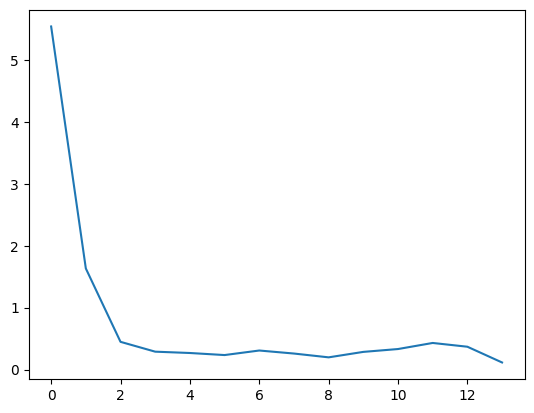

In [6]:
for selected_features in list_combinations:
    
    # droplist = [x for x in ADC_channels if x not in selected_features]
    
    # df.drop(columns =droplist)
    
    x = df[list(selected_features)+IMU_channels].values
    y = df['sign'].values
    x=x[:num_ts*SAMPLE_SIZE]
    y=y[:num_ts*SAMPLE_SIZE]
    Y_resh = np.reshape(y,(num_ts//SAMPLE_SIZE,SAMPLE_SIZE,1))
    Y = Y_resh[:,1,:]
    num_classes = len(np.unique(y))

    #Y_enc = [int.from_bytes(char.encode('utf-8'), byteorder="big") for char in Y ]

    Y_enc = pd.get_dummies(Y.flatten())



    X_resh = np.reshape(x,(num_ts//SAMPLE_SIZE, SAMPLE_SIZE, x.shape[1]))
    X_train, X_test, Y_train, Y_test = train_test_split(X_resh, Y_enc, test_size=0.2, random_state=0, stratify=Y)

    X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.2, random_state=0, stratify=Y_test)
    

    train_dataset = (X_train, Y_train)
    test_dataset = (X_test, Y_test)
    val_dataset = (X_val, Y_val)



    #train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    #test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    # MODEL CONSTANTS
    LAYERS = np.dot(1,[75, 75, 75])                # number of units in hidden and output layers
    M_TRAIN = X_train.shape[0]                     # number of training examples (2D)
    M_TEST = X_test.shape[0]                       # number of test examples (2D),full=X_test.shape[0]
    N = X_train.shape[2]                           # number of features
    BATCH = 256                           # batch size
    EPOCH = 60                                    # number of epochs
    LR = 2e-3                          # learning rate of the gradient descent
    LAMBD = 3e-2                         # lambda in L2 regularizaion
    DP = 0.5                           # dropout rate
    RDP = 0                           # recurrent dropout rate

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    checkpoint = ModelCheckpoint(filepath=log_dir+'/models/'+'model.{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5',
                                 monitor='val_categorical_accuracy',
                                 verbose=1,
                                 save_best_only=True,
                                 save_weights_only=False,
                                 mode='max')

    lr_decay = ReduceLROnPlateau(monitor='loss',
                                 patience=1, verbose=1,
                                 factor=0.5, min_lr=1e-6)

    early_stop = EarlyStopping(monitor='categorical_accuracy', min_delta=0.02,
                               patience=7, verbose=1, mode='auto',
                               baseline=0, restore_best_weights=True)

    initial_learning_rate = LR
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True)

    # MODEL DEFINITION
    model = Sequential()
    model.add(layers.Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='sigmoid', input_shape=(75, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.GRU(units=LAYERS[0],
                          activation='selu', recurrent_activation='hard_sigmoid',
                          kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
                          dropout=DP, recurrent_dropout=RDP,
                          return_sequences=True, return_state=False,
                          stateful=False, unroll=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='sigmoid', input_shape=(75, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.GRU(units=LAYERS[1],
                          activation='selu', recurrent_activation='hard_sigmoid',
                          kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
                          dropout=DP, recurrent_dropout=RDP,
                          return_sequences=True, return_state=False,
                          stateful=False, unroll=False))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='sigmoid', input_shape=(75, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.GRU(units=LAYERS[2],
                          activation='selu', recurrent_activation='hard_sigmoid',
                          kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
                          dropout=DP, recurrent_dropout=RDP,
                          return_sequences=False, return_state=False,
                          stateful=False, unroll=False))
    
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(36, activation='softmax'))

    opt = optimizers.Adam(learning_rate=LR,  clipnorm=1.)

    # MODEL COMPILATION
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['categorical_accuracy'])

    print(model.summary())
    print(selected_features)

    # CONVERTING & ENCODING LABELS


    # SPLITTING






    # TRAINING
    history = model.fit(X_train, Y_train, epochs=EPOCH, batch_size=BATCH,
                        shuffle=True,validation_data=val_dataset,
                        callbacks=[
                                    early_stop
                                    ,lr_decay
                                    ,checkpoint
                                    ,tensorboard_callback]
                        )


    #@model = load_model('logs/fit/20230111-125954model.82-0.54.hdf5')


    # EVALUATION
    train_loss, train_acc = model.evaluate(X_train, Y_train,
                                           batch_size=M_TRAIN, verbose=0)
    test_loss, test_acc = model.evaluate(X_test[:M_TEST], Y_test[:M_TEST],
                                         batch_size=M_TEST, verbose=0)


    # ACCURACY AND LOSS PLOTS

    print(max(history.history['val_categorical_accuracy']))

    plt.plot(history.history['val_loss'])
    plt.plot(history.history['train_loss'])
    plt.title('Model loss and accuracy')
    plt.ylabel('Loss/Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Loss', 'Accuracy'], loc='upper left')
    plt.show()


    # CONFUSION MATRIX
    oh_dict=dict(zip([i for i in range(num_classes)],list(sign_types_dict.keys())))

    y_pred = model.predict(X_test)
    y_int_pred_class = np.argmax(y_pred, axis=1)
    y_int_test_class = np.argmax(Y_test.values, axis=1)

    y_test_class = [oh_dict[i] for i in y_int_test_class]
    y_pred_class=[oh_dict[i] for i in y_int_pred_class]

    confusion_mat = confusion_matrix(y_test_class, y_pred_class, labels=list(sign_types_dict.keys()))
    plt.imshow(confusion_mat, cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks([cl for cl in range(num_classes)], sign_types_dict.keys())
    plt.yticks([cl for cl in range(num_classes)], sign_types_dict.keys())
    plt.show()

    
    acc_list.append([test_acc, selected_features])
    
    tf.keras.backend.clear_session()

    # tf.math.confusion_matrix(Y_test,y_pred)
    # #%%
    # # ROC PLOT
    # fpr = {}
    # tpr = {}
    # roc_auc = {}
    #
    # for i in range(3):
    #     fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_pred[:, i])
    #     roc_auc[i] = auc(fpr[i], tpr[i])
    #
    # plt.figure()
    # for i in range(3):
    #     plt.plot(fpr[i], tpr[i], label='ROC curve for class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    # plt.plot([0, 1], [0, 1], 'k--')
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.0])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('ROC curves for all classes')
    # plt.legend(loc="lower right")
    # plt.show()

In [7]:
#LOADING PACKAGES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime



#import psycopg as psql

import configparser

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc


from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
import tensorflow as tf


from keras.regularizers import l2


from tensorflow.keras.utils import timeseries_dataset_from_array, normalize

from itertools import combinations


config = configparser.ConfigParser()
config.read('config.ini')



devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(devices[0], True)

In [8]:
ADC_channels = ['P1_1', 'P1_2', 'P2_1', 'P2_2', 'P3_1', 'P3_2', 'P4_1', 'P4_2', 'P5_1', 'P5_2']
IMU_channels = ['Euler_x', 'Euler_y', 'Euler_z', 'Acc_x', 'Acc_y', 'Acc_z']

sign_types = ['static', 'dynamic']
sign_types_dict = {'a': sign_types[0],
                   'ą': sign_types[1],
                   'b': sign_types[0],
                   'c': sign_types[0],
                   'ć': sign_types[1],
                   'ch': sign_types[1],
                   'cz': sign_types[1],
                   'd': sign_types[1],
                   'e': sign_types[0],
                   'ę': sign_types[1],
                   'f': sign_types[1],
                   'g': sign_types[1],
                   'h': sign_types[1],
                   'i': sign_types[0],
                   'j': sign_types[1],
                   'k': sign_types[1],
                   'l': sign_types[0],
                   'ł': sign_types[1],
                   'm': sign_types[0],
                   'n': sign_types[0],
                   'ń': sign_types[1],
                   'o': sign_types[0],
                   'ó': sign_types[1],
                   'p': sign_types[0],
                   'r': sign_types[0],
                   'rz': sign_types[1],
                   's': sign_types[0],
                   'ś': sign_types[1],
                   'sz': sign_types[1],
                   't': sign_types[0],
                   'u': sign_types[0],
                   'w': sign_types[0],
                   'y': sign_types[0],
                   'z': sign_types[1],
                   'ź': sign_types[1],
                   'ż': sign_types[1]}


SAMPLE_SIZE = 75

In [9]:
# LOADING
#df = pd.read_csv("G:\Git_repos\HandPi-ETL\gesty.csv")
#df = pd.read_csv('G:/Git_repos/HandPi-ETL/wd_aug.csv')
#df = pd.concat([df, pd.read_csv('G:/Git_repos/HandPi-ETL/wd.csv')], ignore_index=True )
df = pd.read_csv("/mnt/g/Git_repos/HandPi-ETL/gesty_pp.csv")
df = df[df['exam_id'] != ('tt',15)]

In [10]:
# ADDING AUGMENTED DATA
adf = pd.read_csv("/mnt/g/Git_repos/HandPi-ETL/gesty_pp_aug.csv")
adf.columns = df.columns[0:19]
df = pd.concat([df, adf ], ignore_index=True)

In [11]:
# DATA CURING
df.fillna(method='backfill', inplace=True)
print(f'NaN containment:{df.isnull().any()}')
num_rows = df.shape[0] // SAMPLE_SIZE
num_ts = num_rows*SAMPLE_SIZE
df = df.iloc[:num_ts]


list_combinations = list()

sample_set = set(ADC_channels)
for n in range(3,4):
    list_combinations += list(combinations(sample_set, n))
    
    
acc_list = []

NaN containment:exam_id       False
P1_1          False
P1_2          False
P2_1          False
P2_2          False
P3_1          False
P3_2          False
P4_1          False
P4_2          False
P5_1          False
P5_2          False
Euler_x       False
Euler_y       False
Euler_z       False
Acc_x         False
Acc_y         False
Acc_z         False
sign          False
timestamp     False
gesture_id     True
dtype: bool


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_6 (Batc  (None, 75, 9)            36        
 hNormalization)                                                 
                                                                 
 conv1d_3 (Conv1D)           (None, 73, 64)            1792      
                                                                 
 batch_normalization_7 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru_3 (GRU)                 (None, 73, 75)            31725     
                                                                 
 batch_normalization_8 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                      

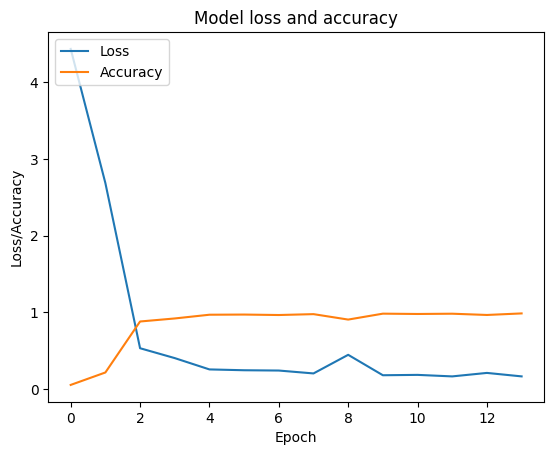

360/360 [==============================] - 15s 40ms/step


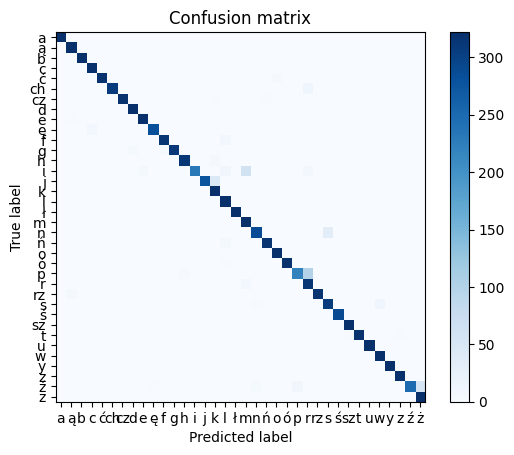

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

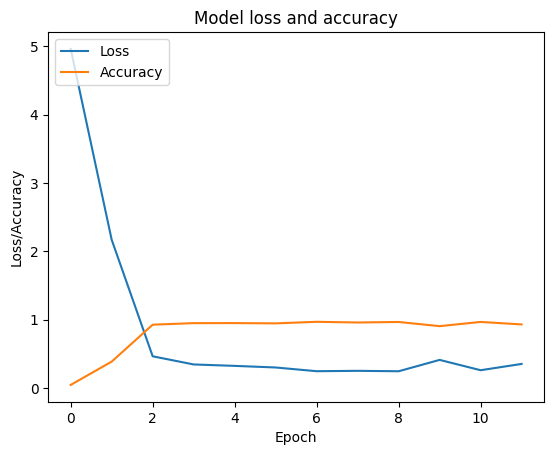

360/360 [==============================] - 14s 38ms/step


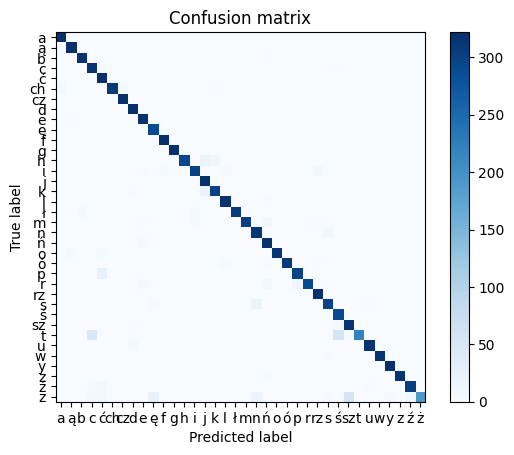

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

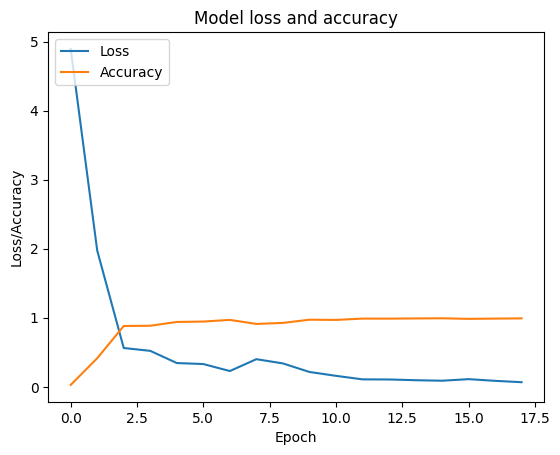

360/360 [==============================] - 15s 40ms/step


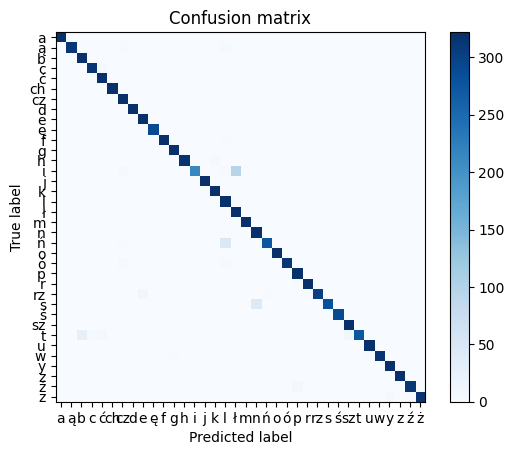

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

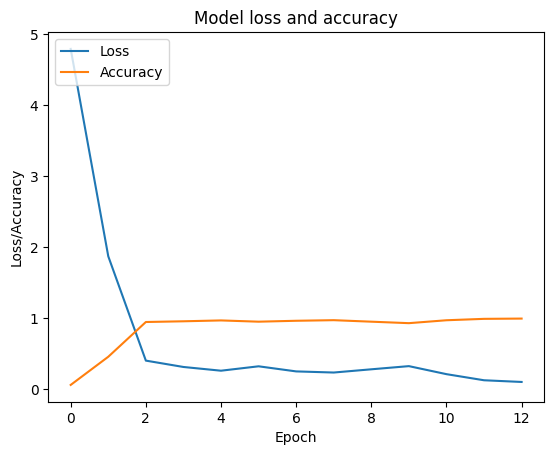

360/360 [==============================] - 14s 37ms/step


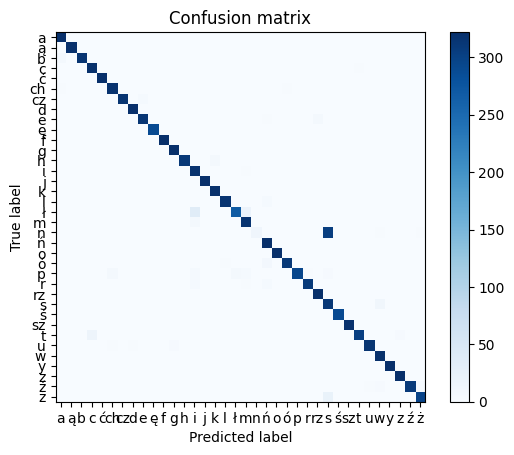

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

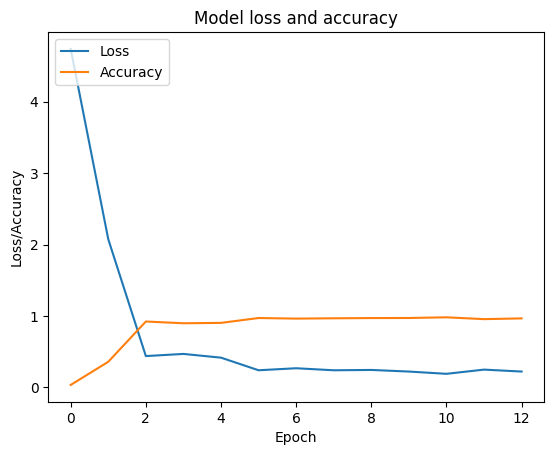

360/360 [==============================] - 13s 37ms/step


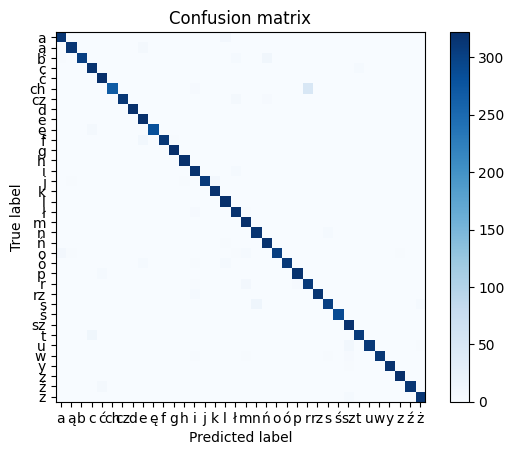

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

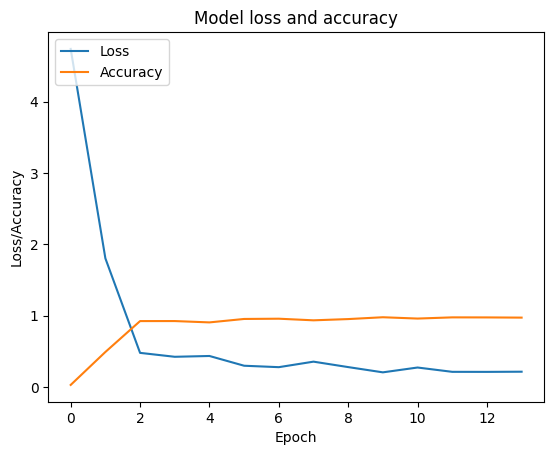

360/360 [==============================] - 14s 37ms/step


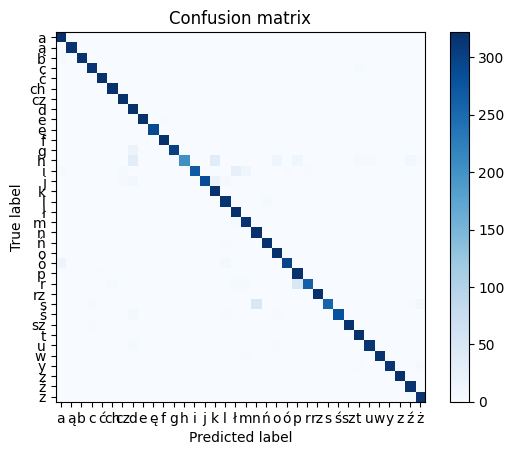

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

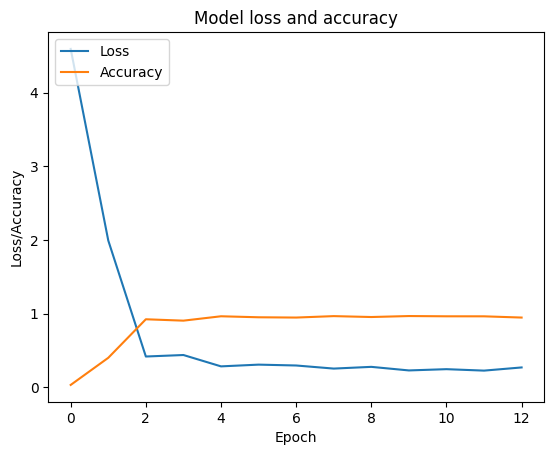

360/360 [==============================] - 14s 38ms/step


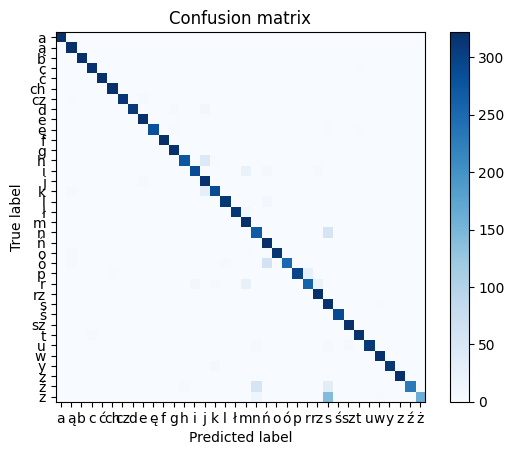

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

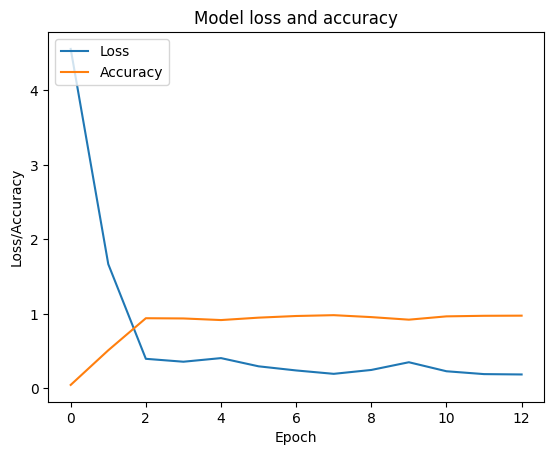

360/360 [==============================] - 14s 38ms/step


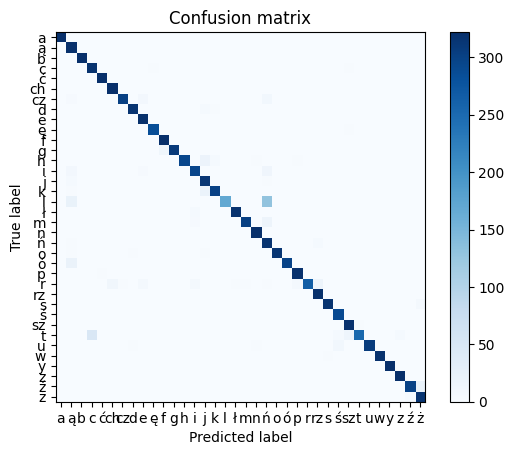

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

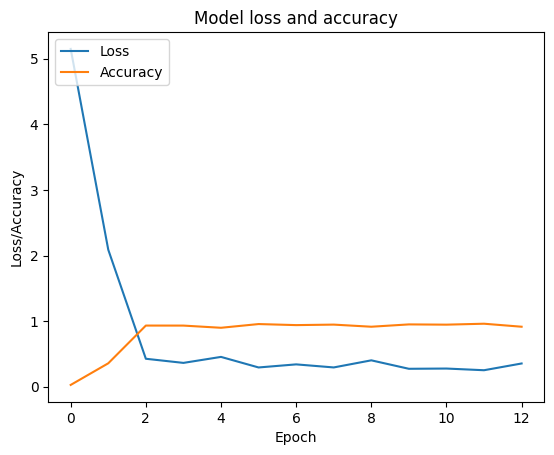

360/360 [==============================] - 14s 39ms/step


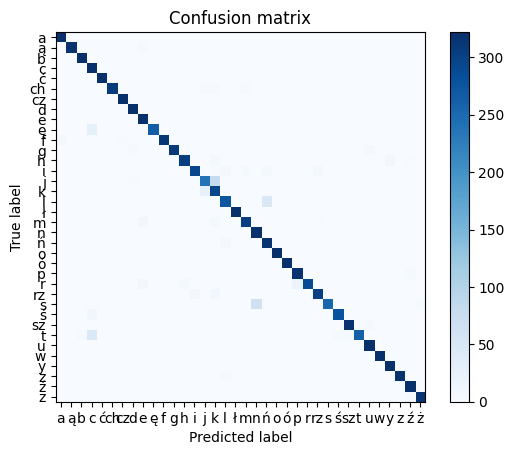

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

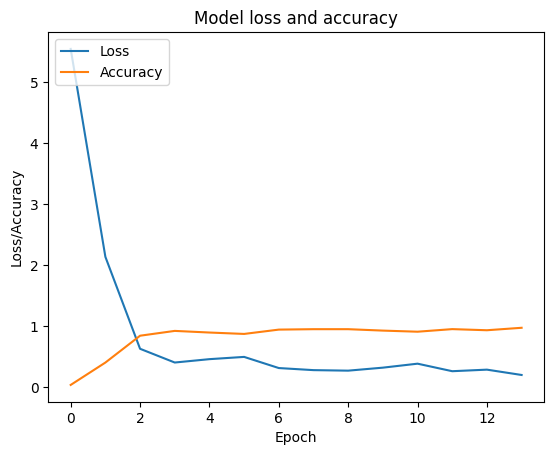

360/360 [==============================] - 14s 38ms/step


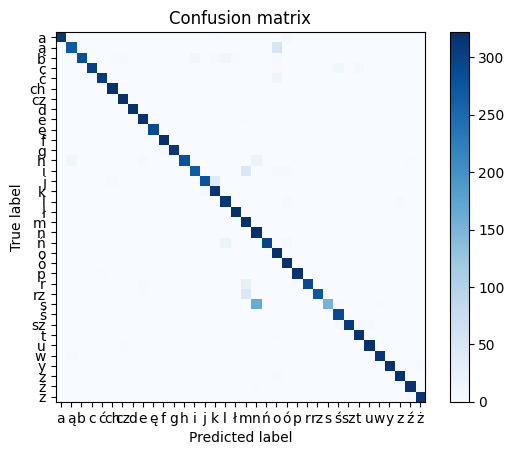

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

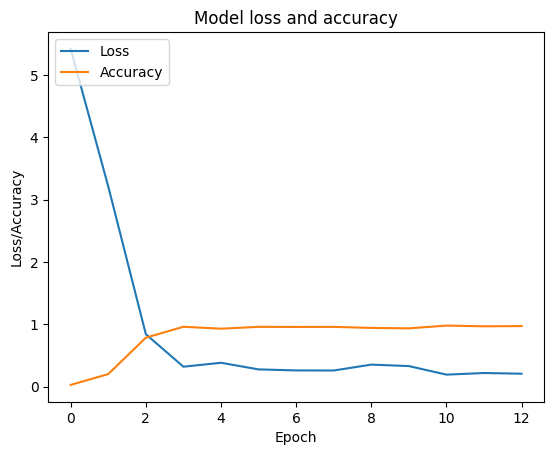

360/360 [==============================] - 14s 38ms/step


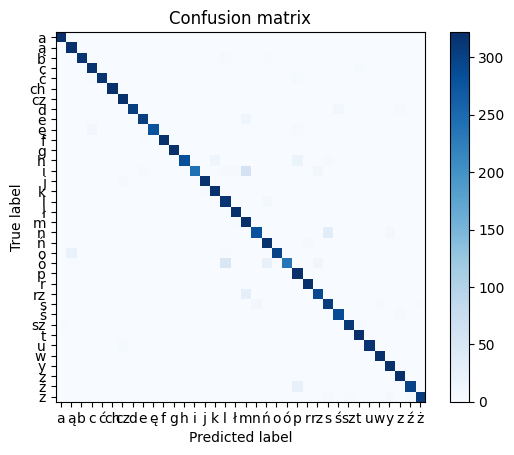

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

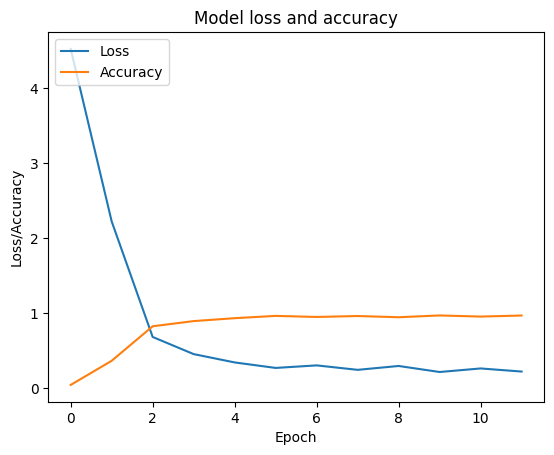

360/360 [==============================] - 14s 38ms/step


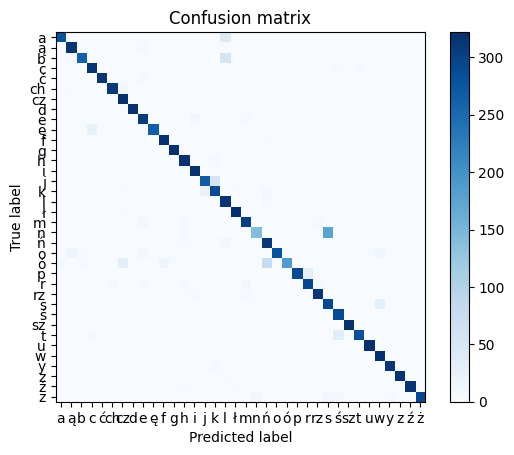

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

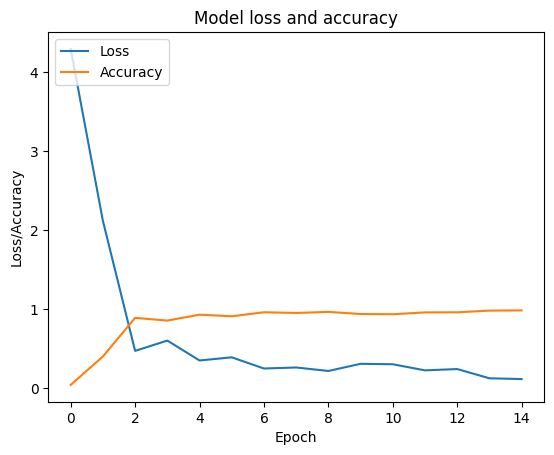

360/360 [==============================] - 14s 38ms/step


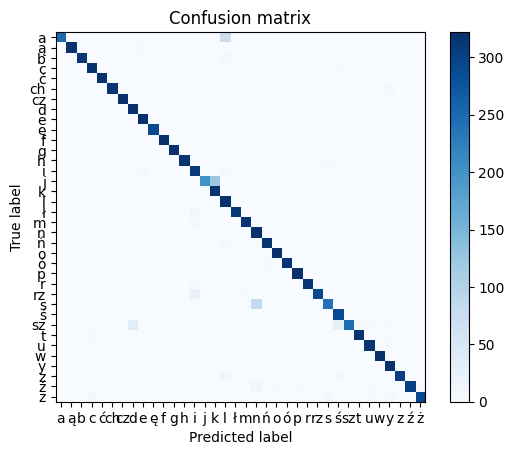

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

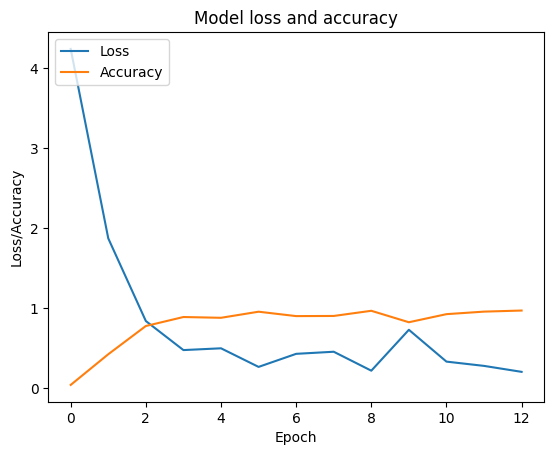

360/360 [==============================] - 14s 37ms/step


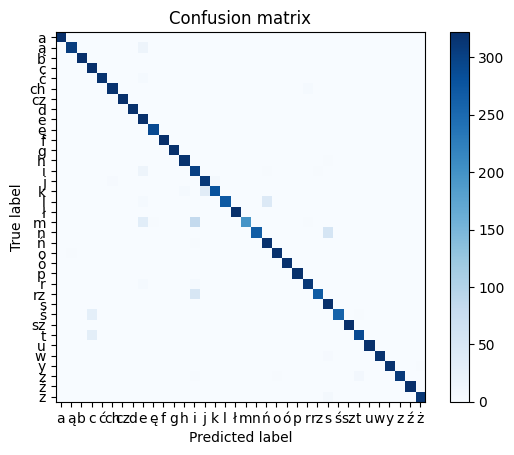

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

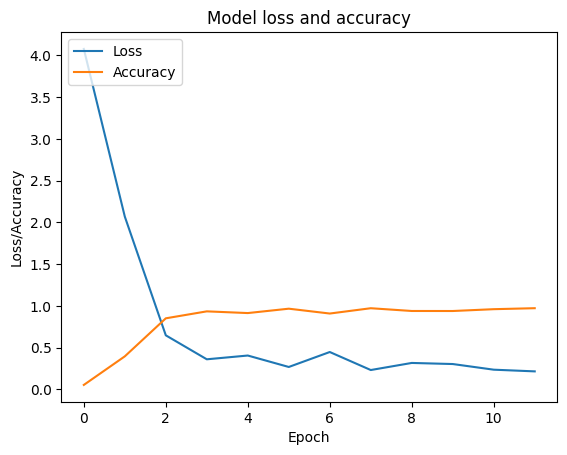

360/360 [==============================] - 14s 38ms/step


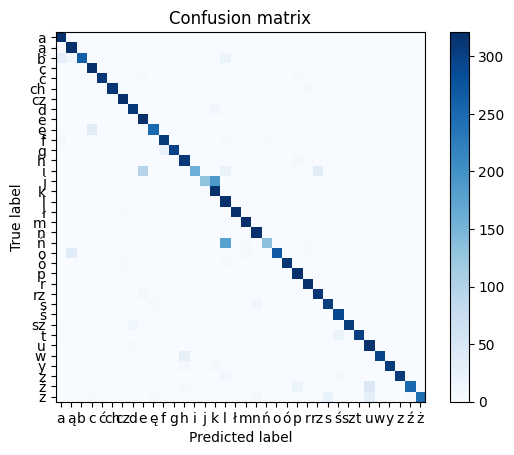

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

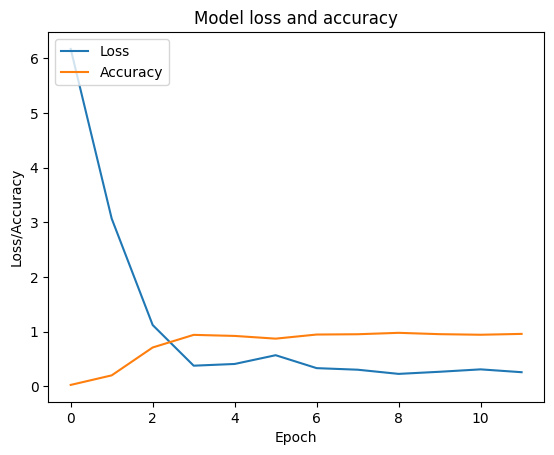

360/360 [==============================] - 13s 37ms/step


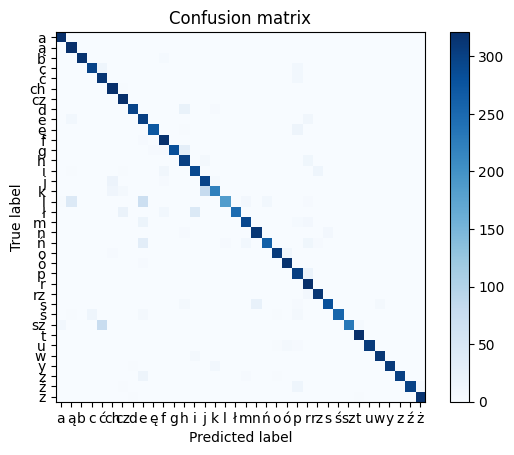

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

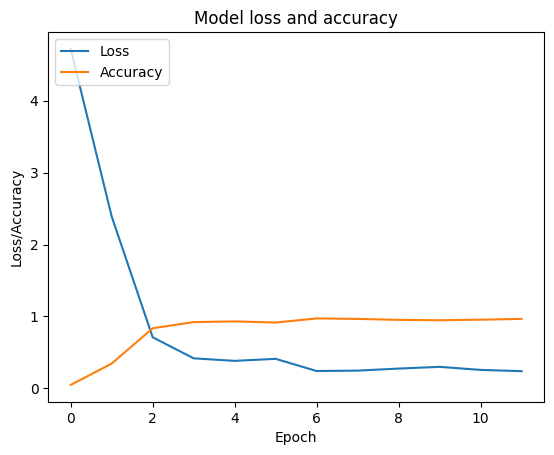

360/360 [==============================] - 14s 37ms/step


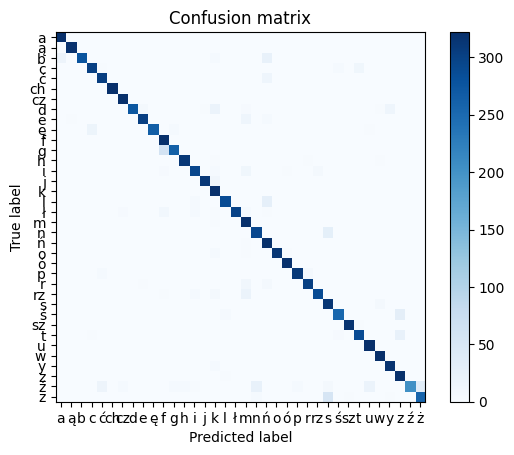

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

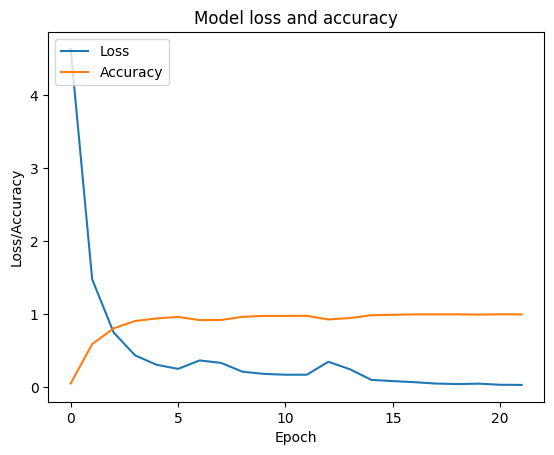

360/360 [==============================] - 14s 38ms/step


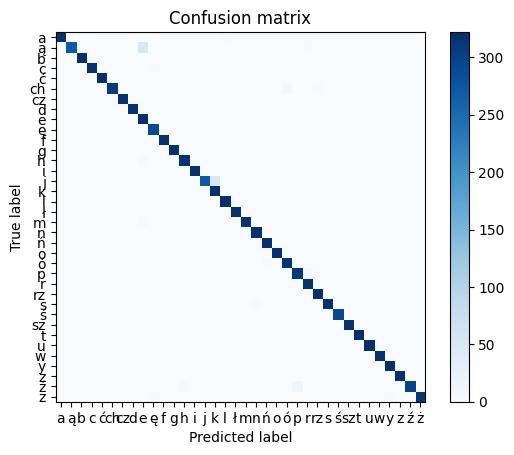

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

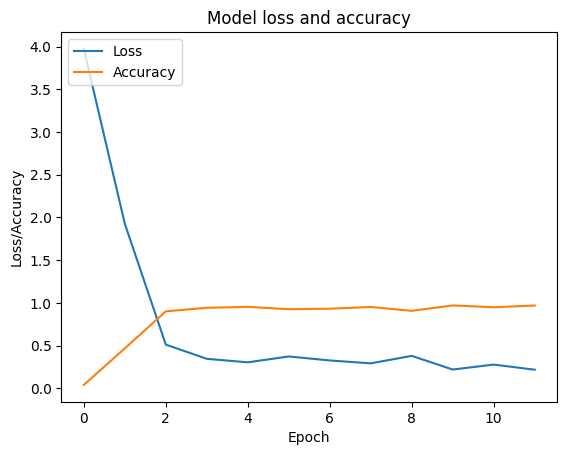

360/360 [==============================] - 13s 35ms/step


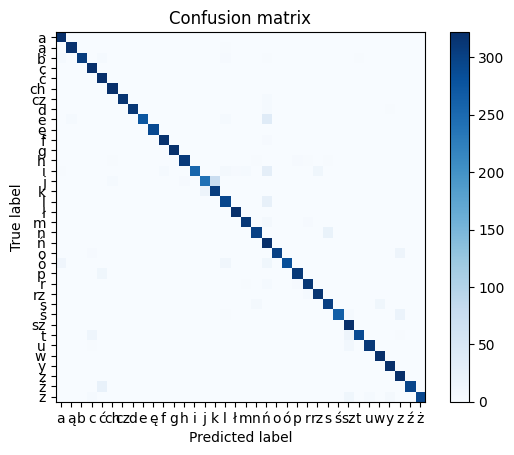

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

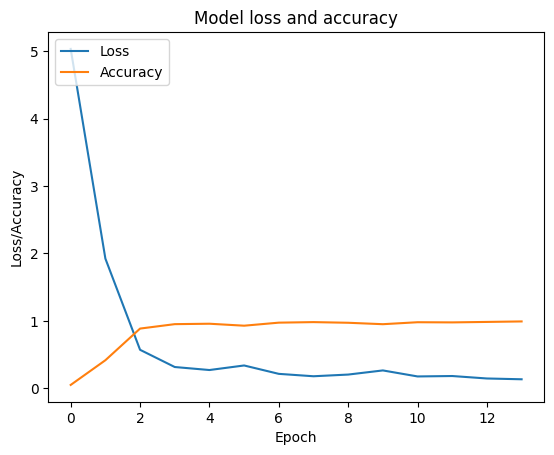

360/360 [==============================] - 14s 39ms/step


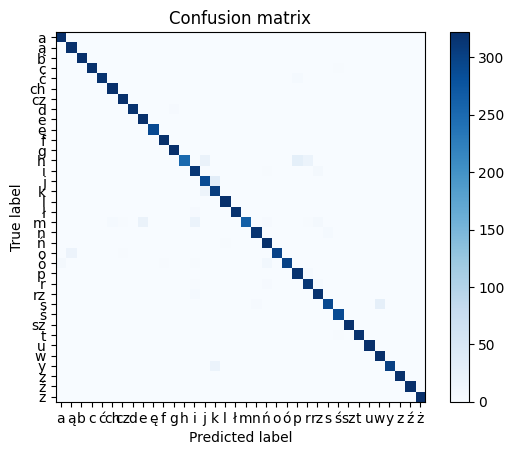

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

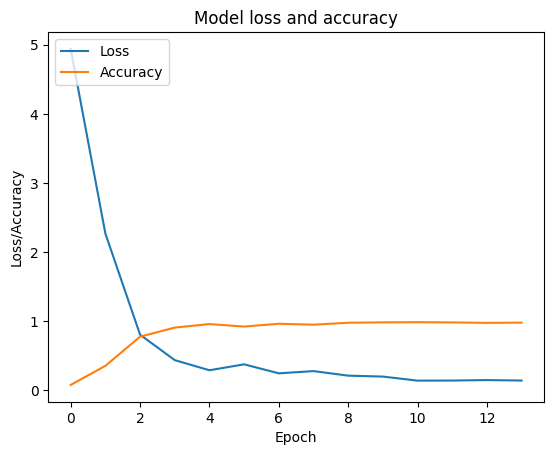

360/360 [==============================] - 14s 38ms/step


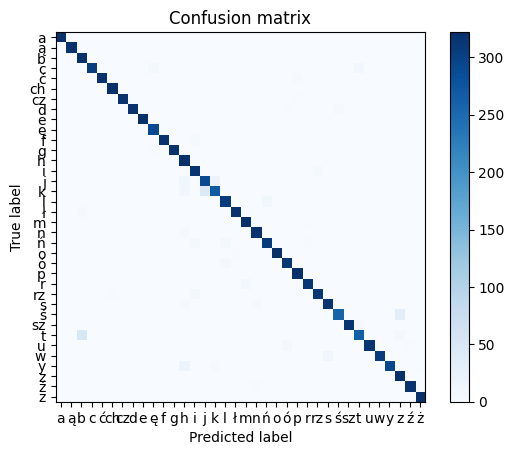

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

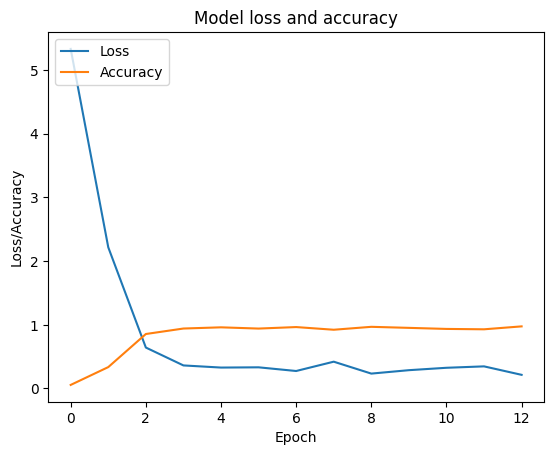

360/360 [==============================] - 14s 40ms/step


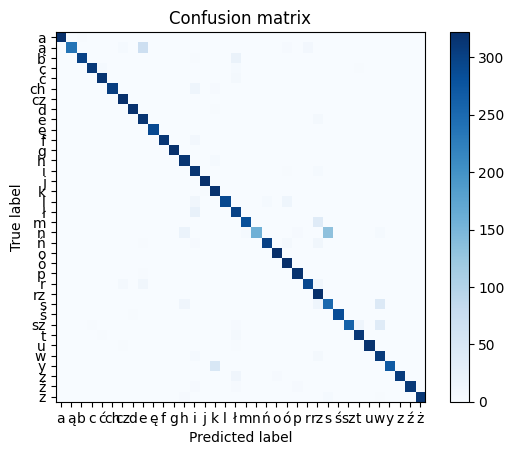

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

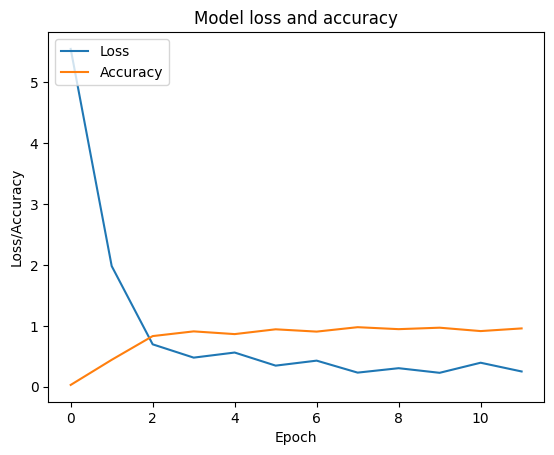

360/360 [==============================] - 13s 36ms/step


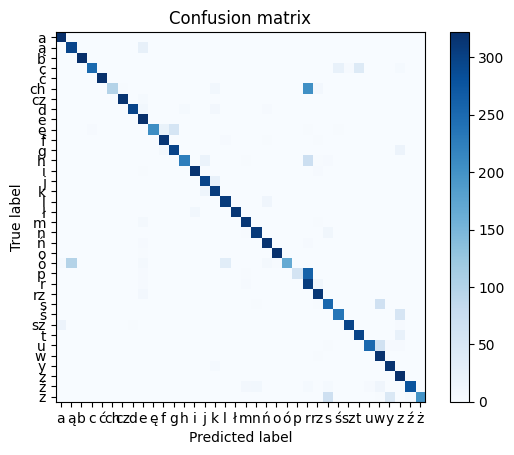

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

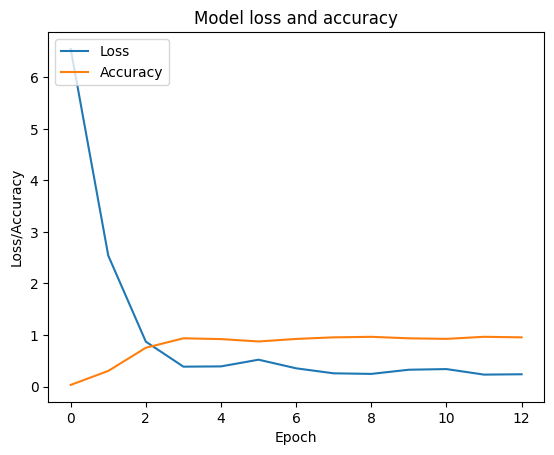

360/360 [==============================] - 13s 37ms/step


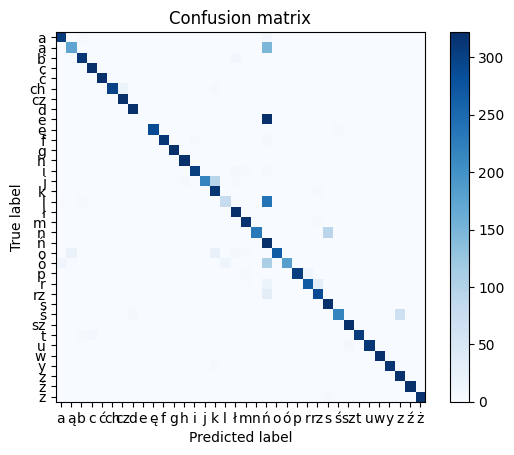

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

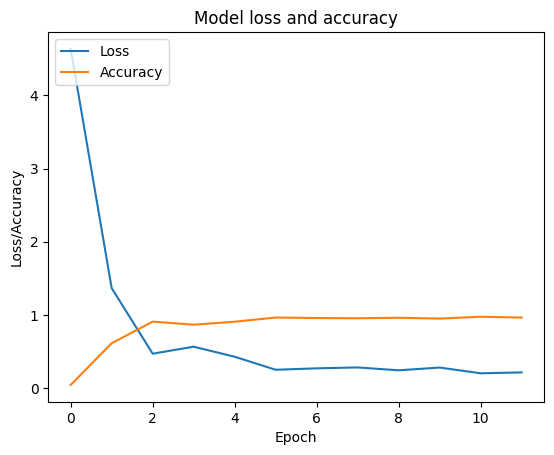

360/360 [==============================] - 14s 39ms/step


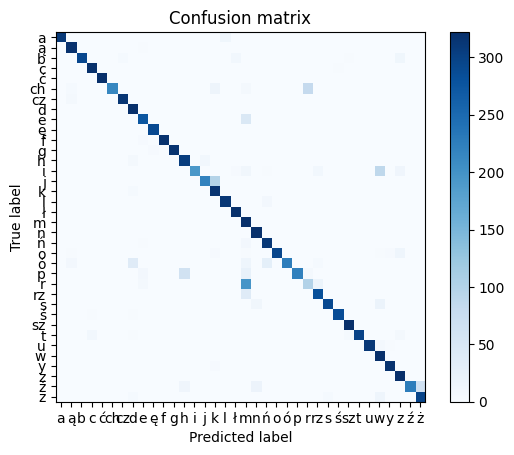

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

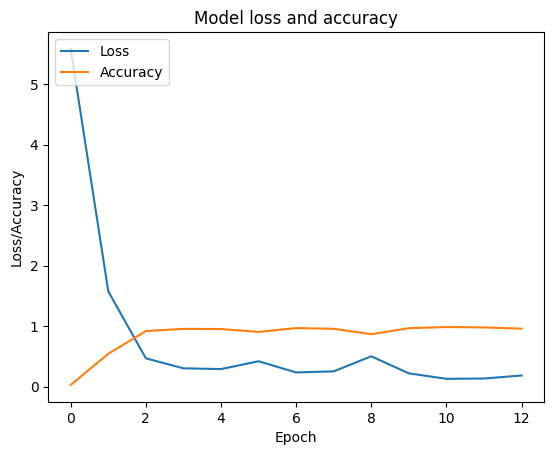

360/360 [==============================] - 13s 36ms/step


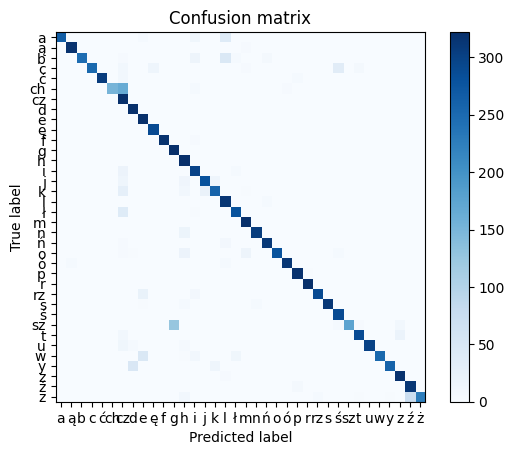

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

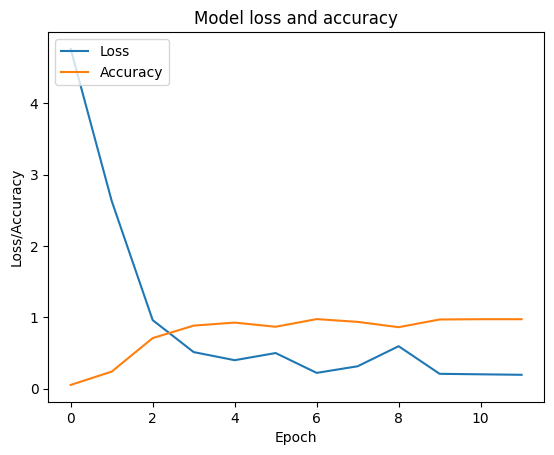

360/360 [==============================] - 15s 39ms/step


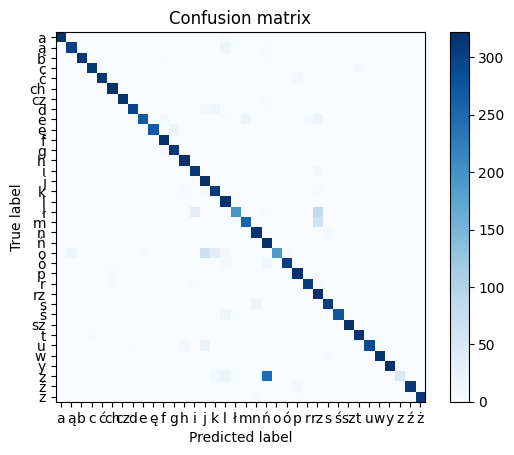

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

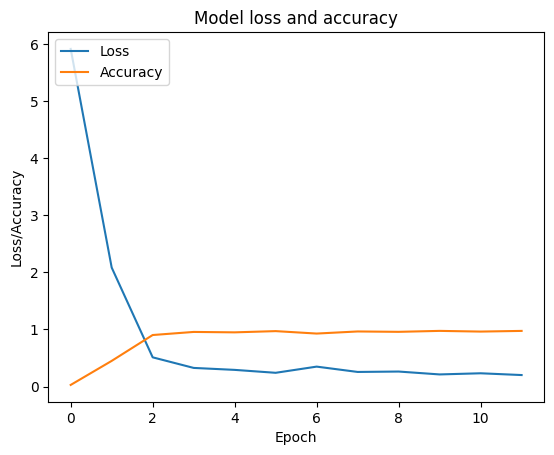

360/360 [==============================] - 13s 35ms/step


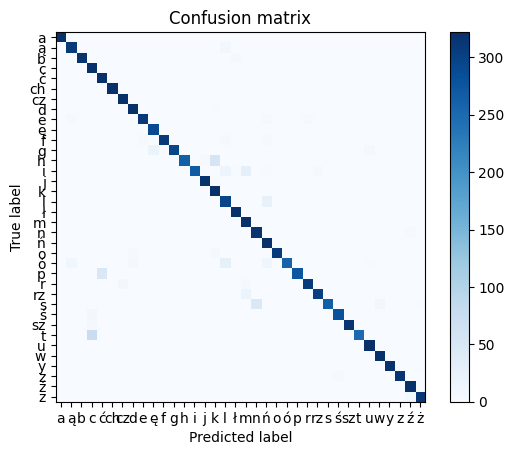

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

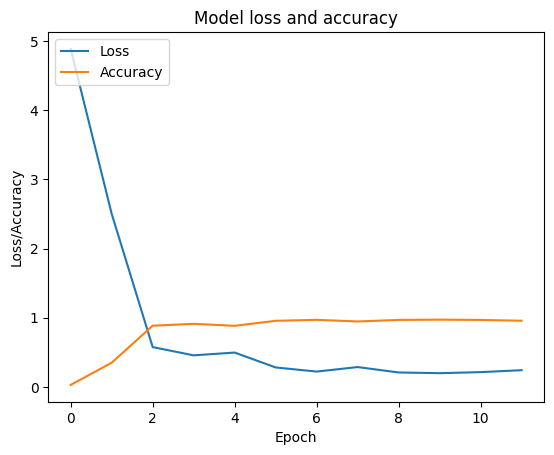

360/360 [==============================] - 14s 38ms/step


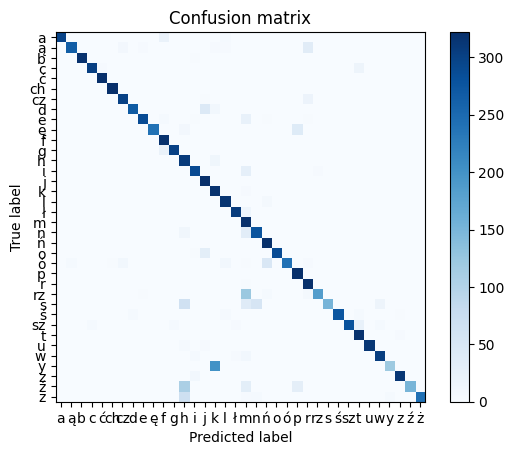

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

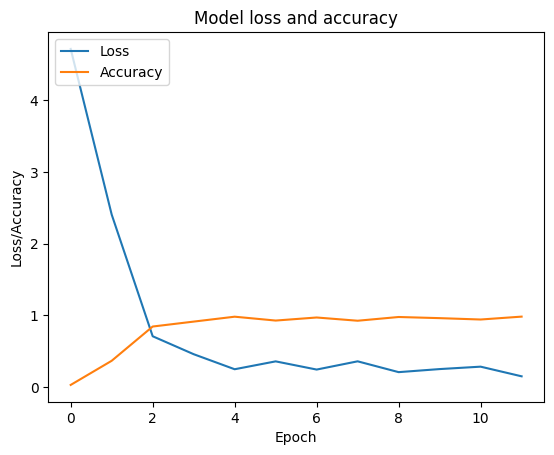

360/360 [==============================] - 14s 39ms/step


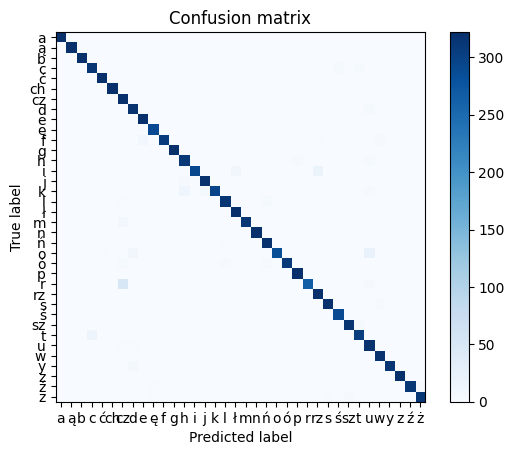

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

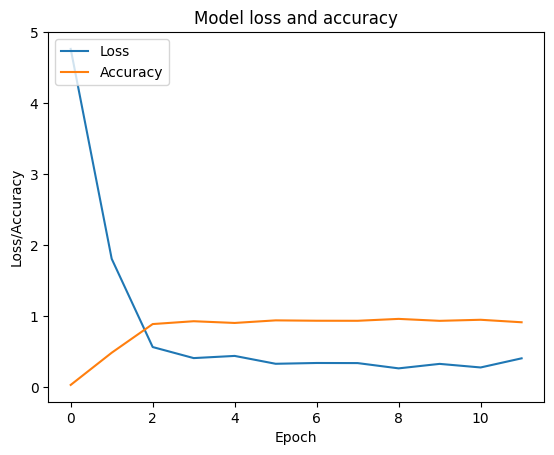

360/360 [==============================] - 14s 39ms/step


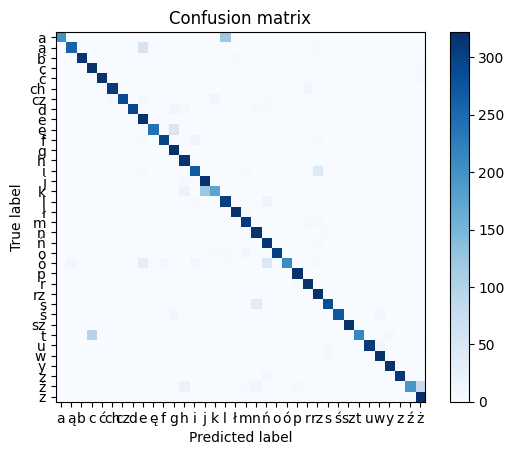

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

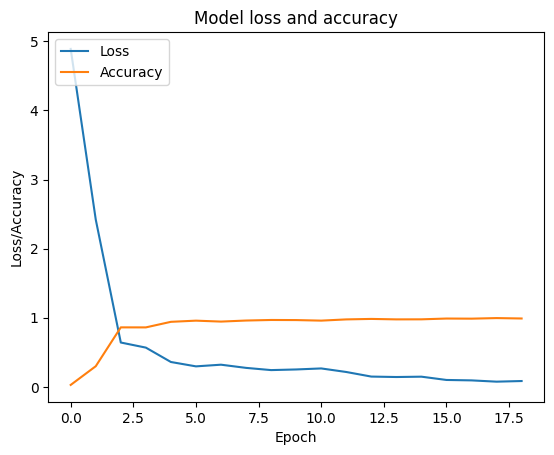

360/360 [==============================] - 15s 40ms/step


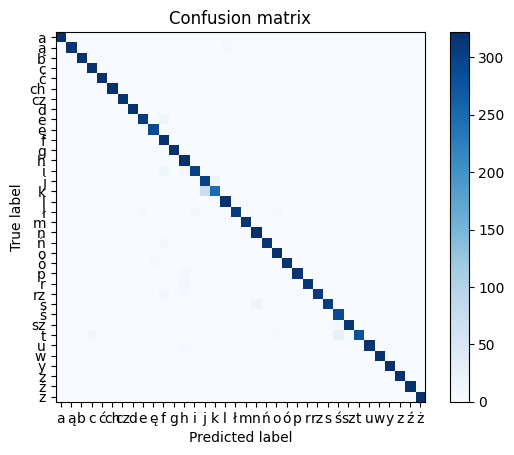

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

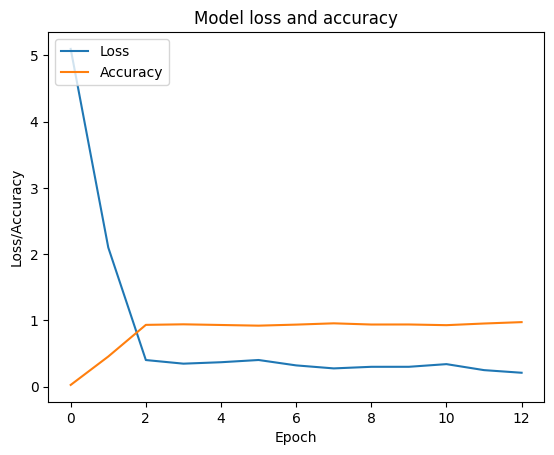

360/360 [==============================] - 14s 38ms/step


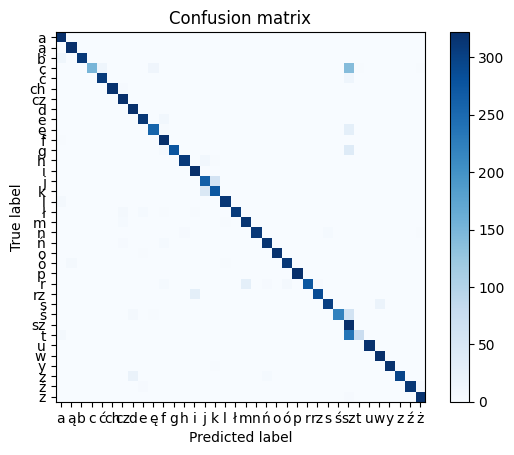

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

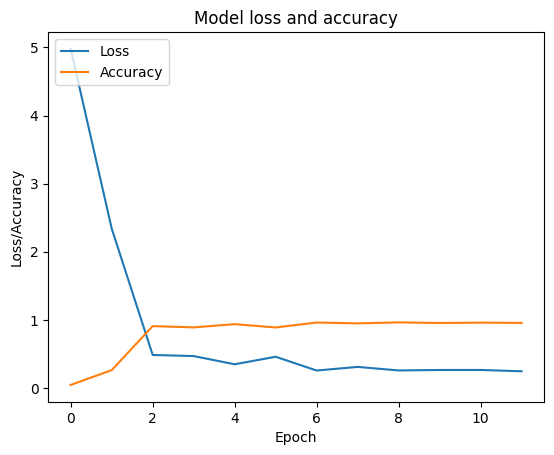

360/360 [==============================] - 14s 38ms/step


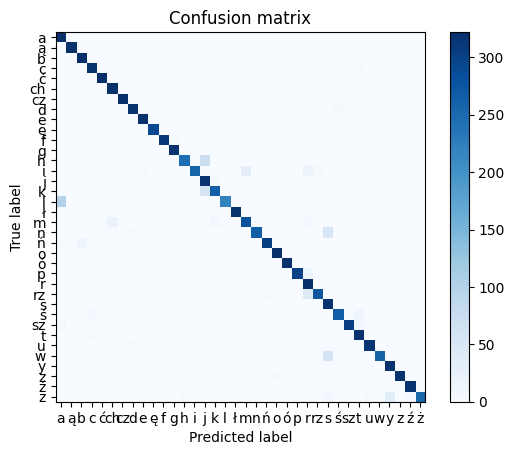

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

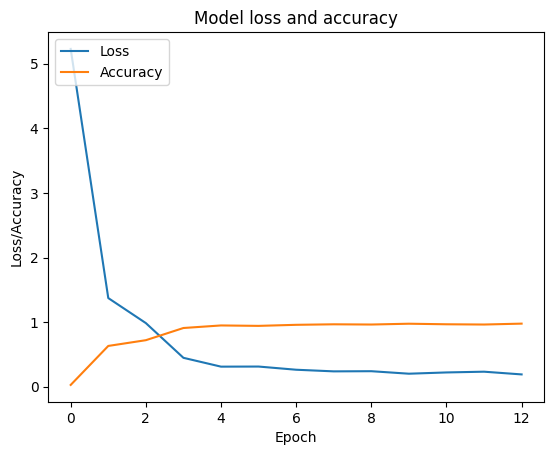

360/360 [==============================] - 14s 39ms/step


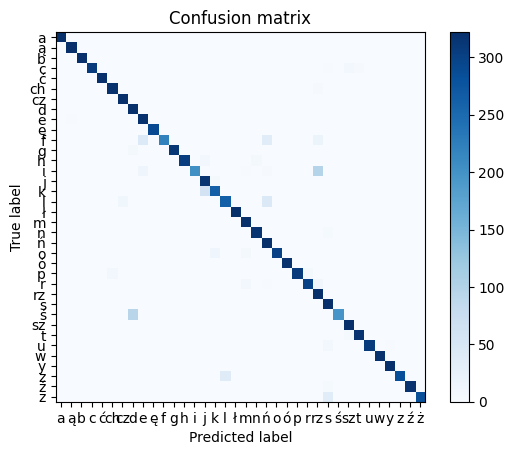

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

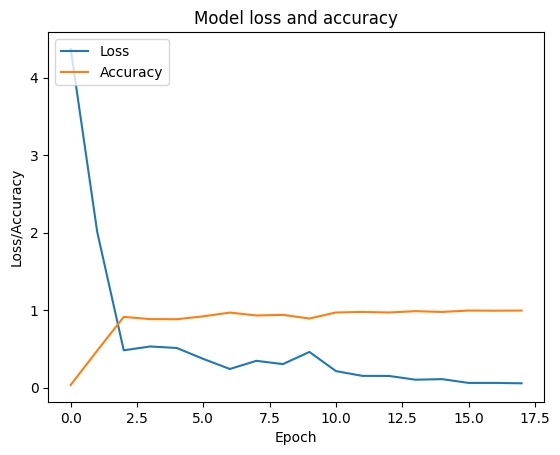

360/360 [==============================] - 15s 40ms/step


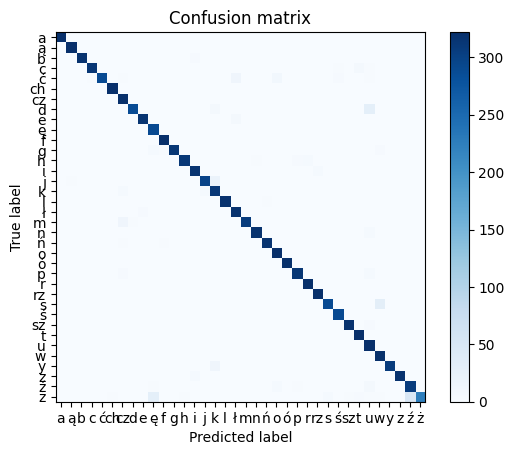

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

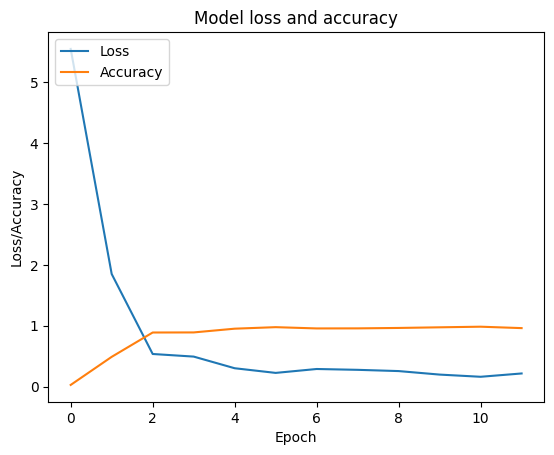

360/360 [==============================] - 14s 38ms/step


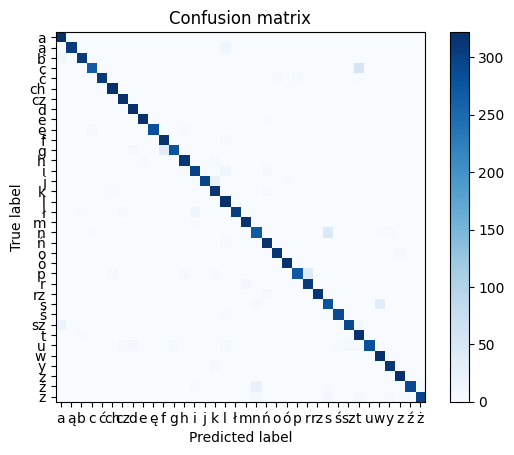

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

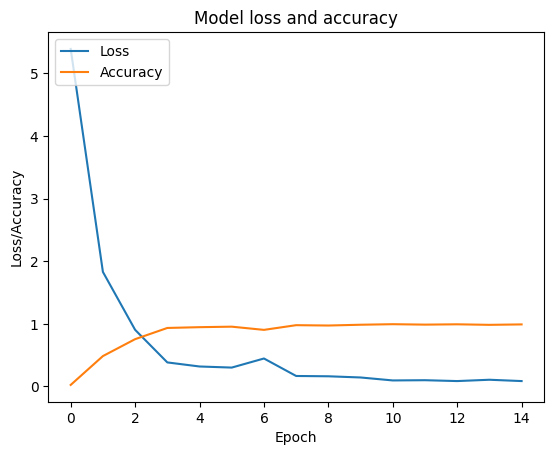

360/360 [==============================] - 14s 39ms/step


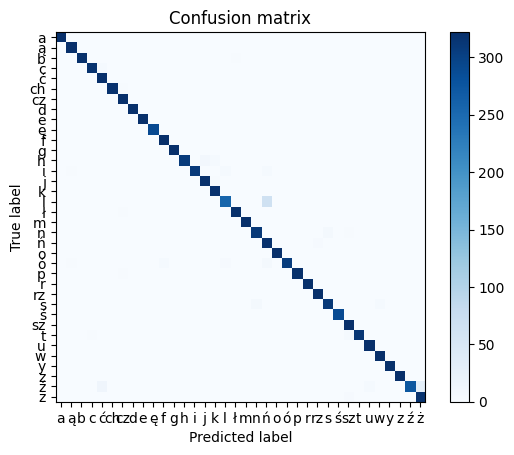

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

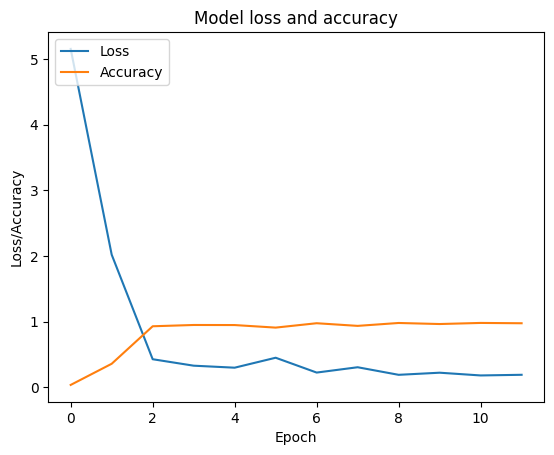

360/360 [==============================] - 13s 36ms/step


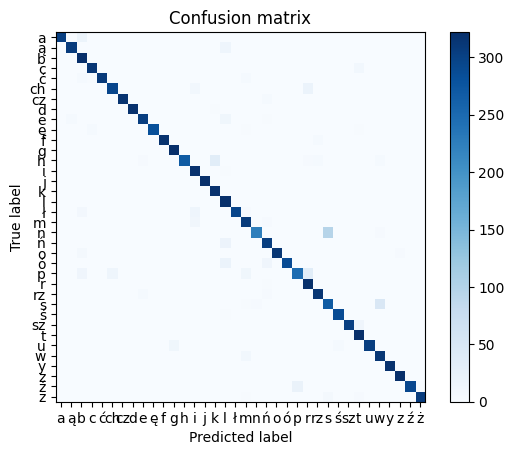

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

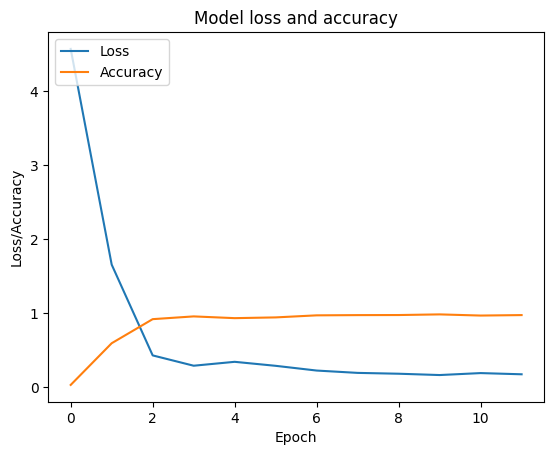

360/360 [==============================] - 14s 39ms/step


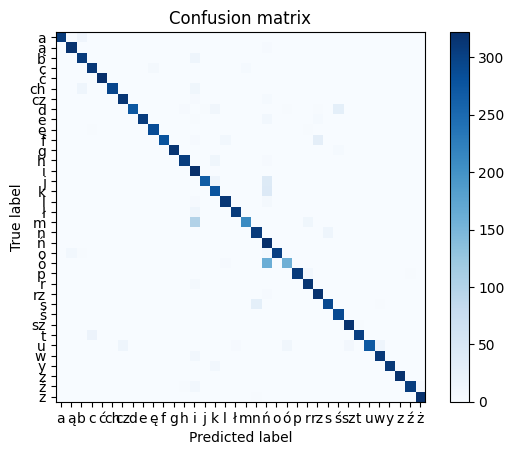

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

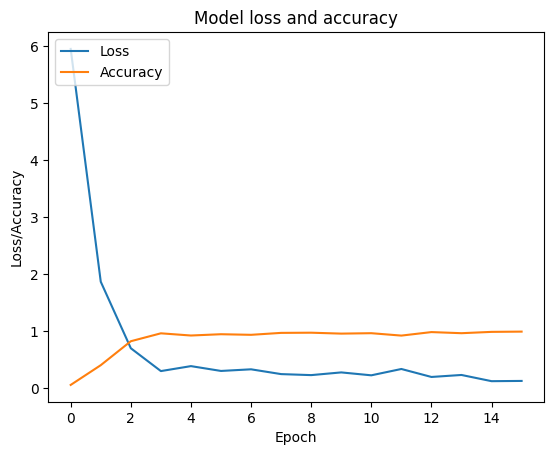

360/360 [==============================] - 14s 37ms/step


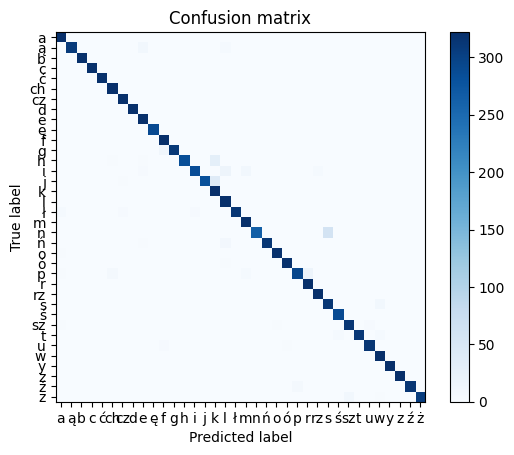

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

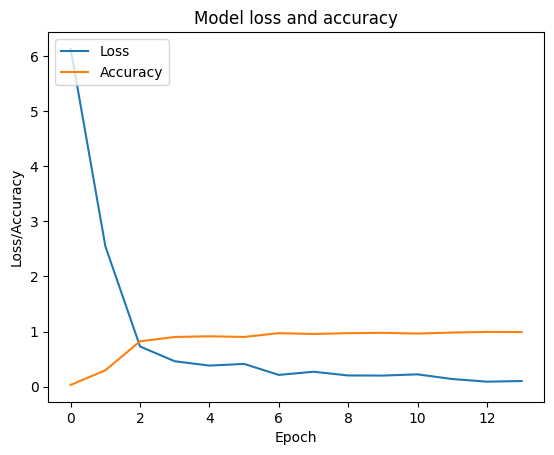

360/360 [==============================] - 15s 40ms/step


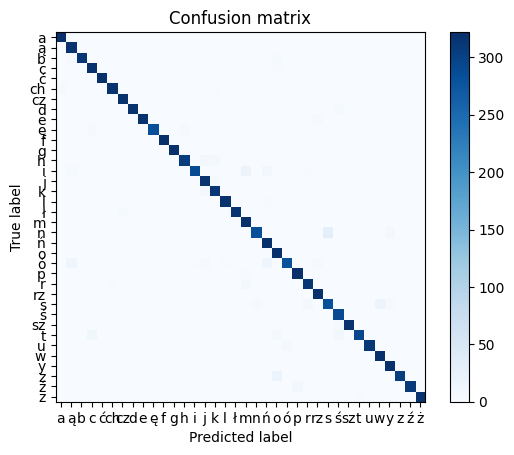

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

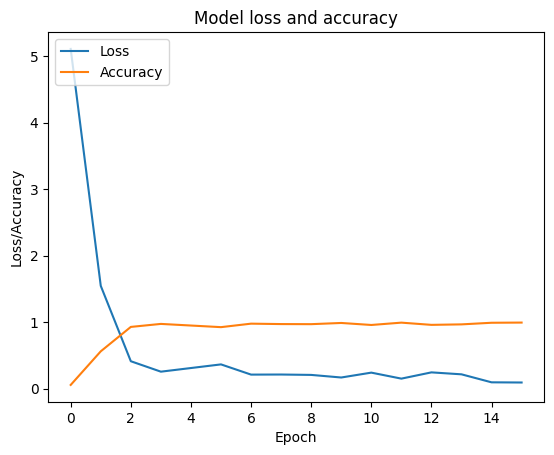

360/360 [==============================] - 14s 37ms/step


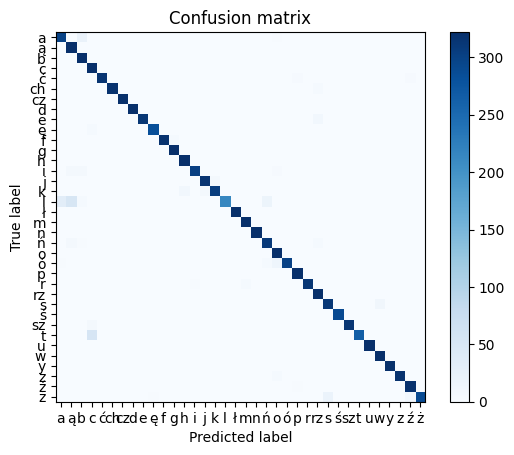

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

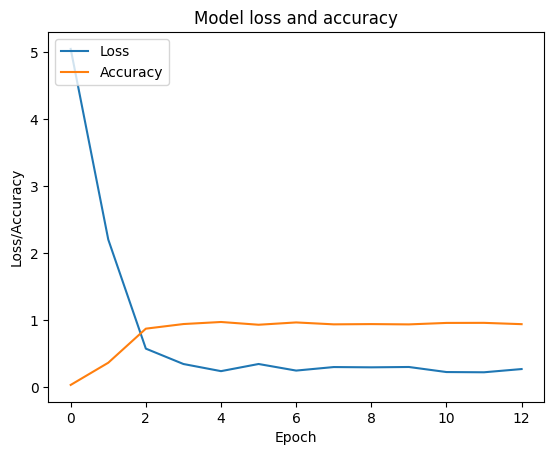

360/360 [==============================] - 14s 39ms/step


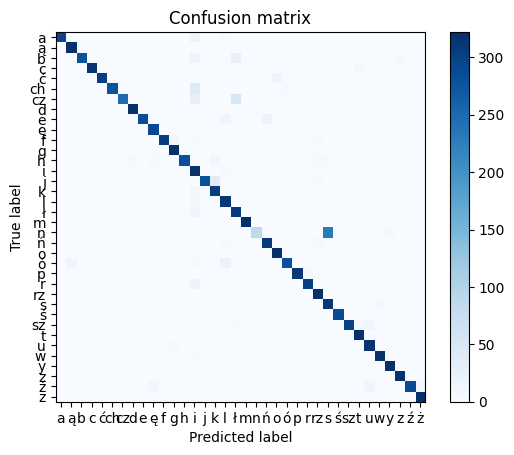

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

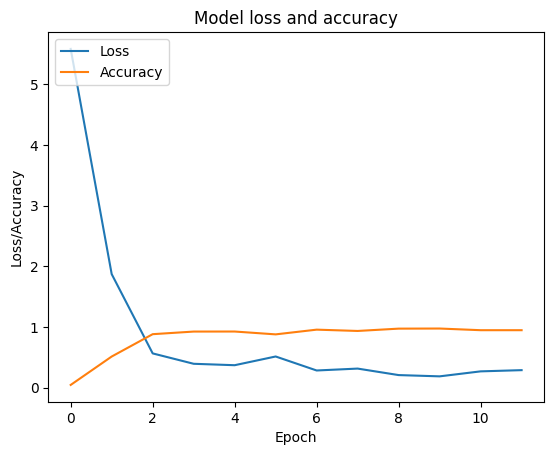

360/360 [==============================] - 14s 39ms/step


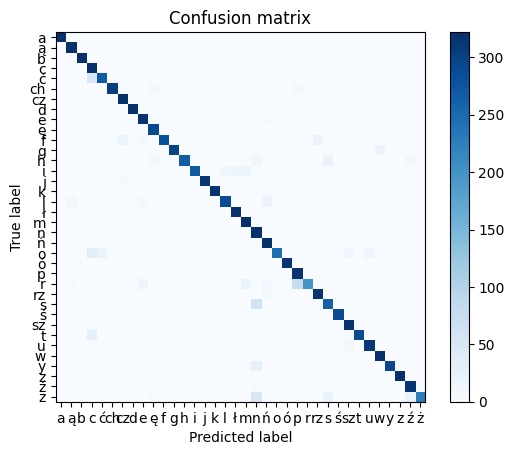

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

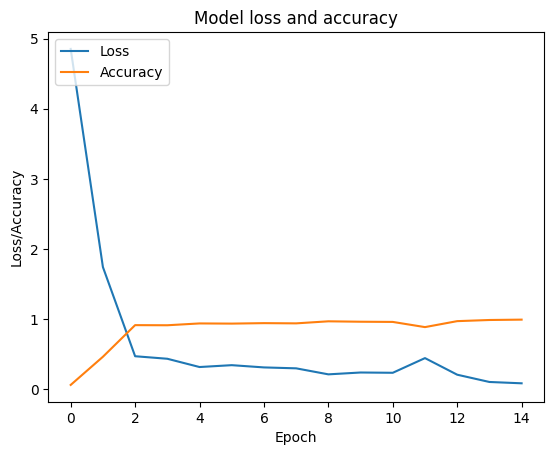

360/360 [==============================] - 15s 40ms/step


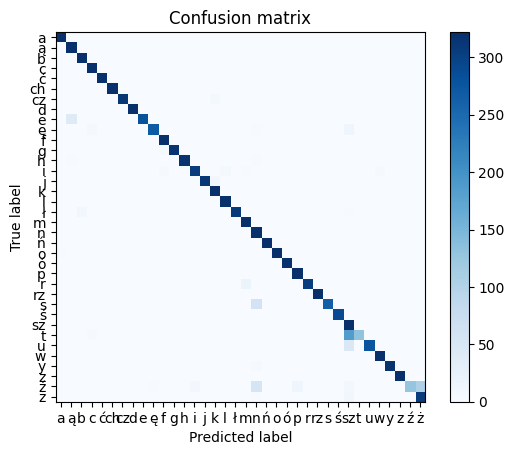

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

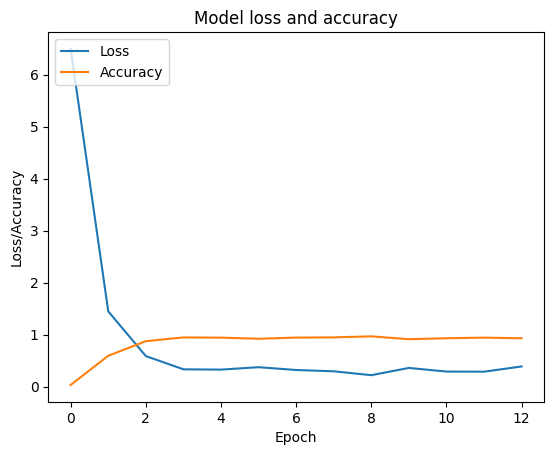

360/360 [==============================] - 14s 38ms/step


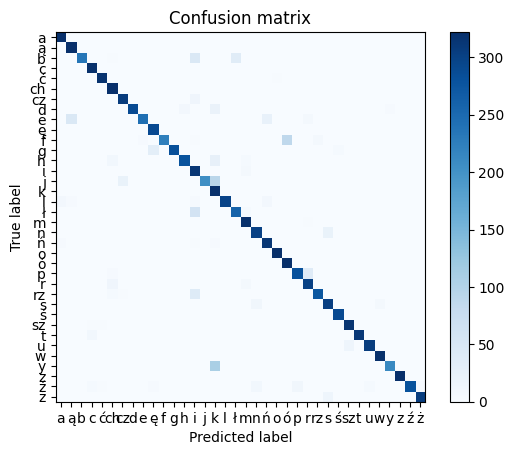

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

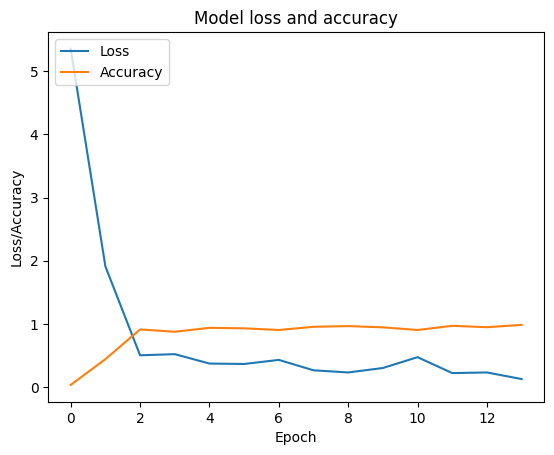

360/360 [==============================] - 15s 41ms/step


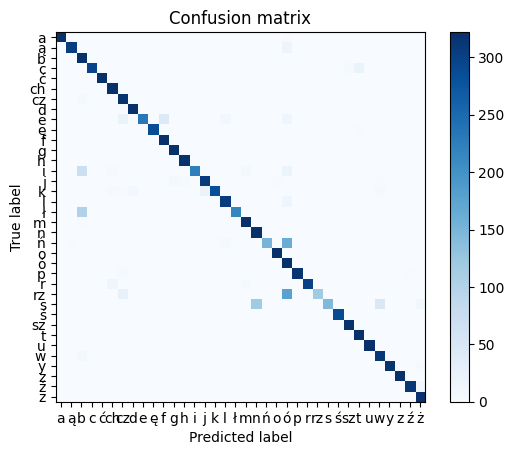

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

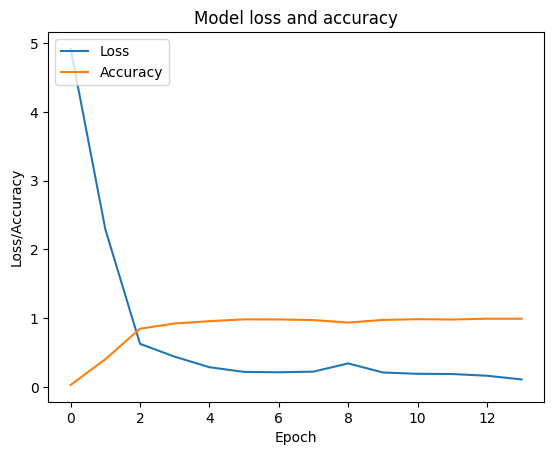

360/360 [==============================] - 14s 38ms/step


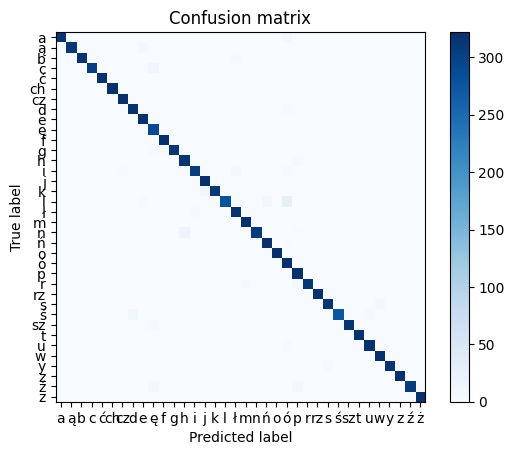

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

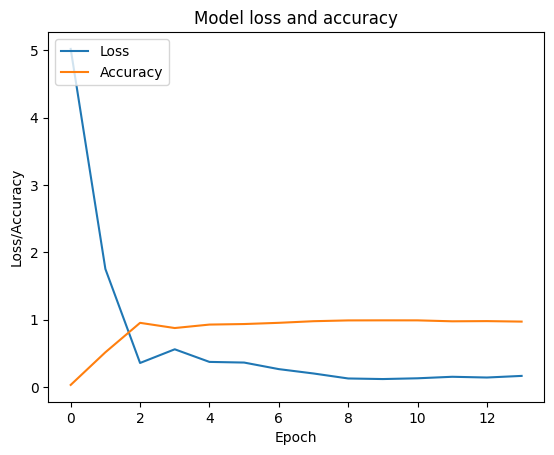

360/360 [==============================] - 15s 40ms/step


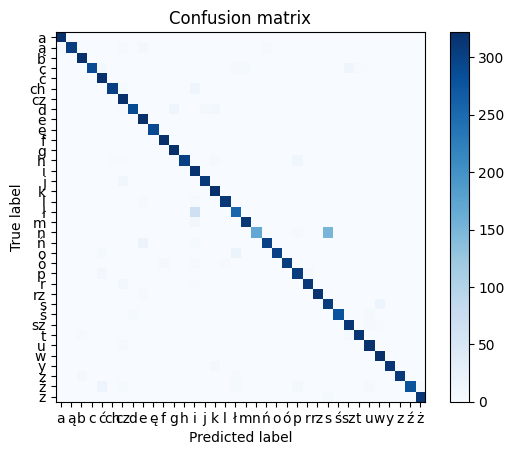

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

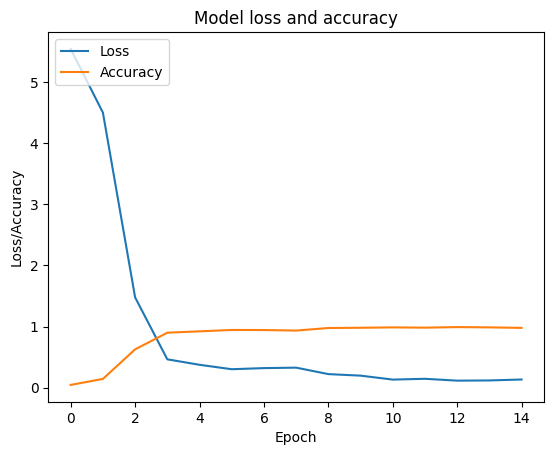

360/360 [==============================] - 16s 39ms/step


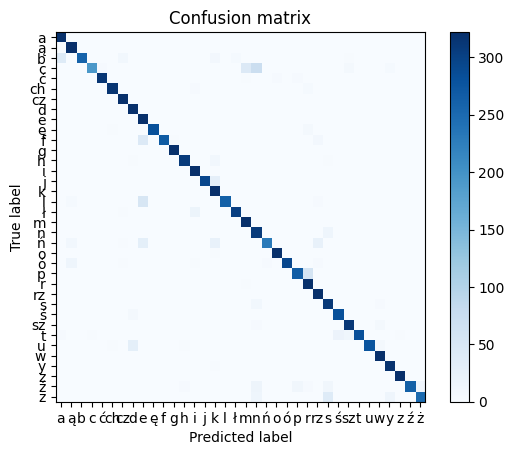

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

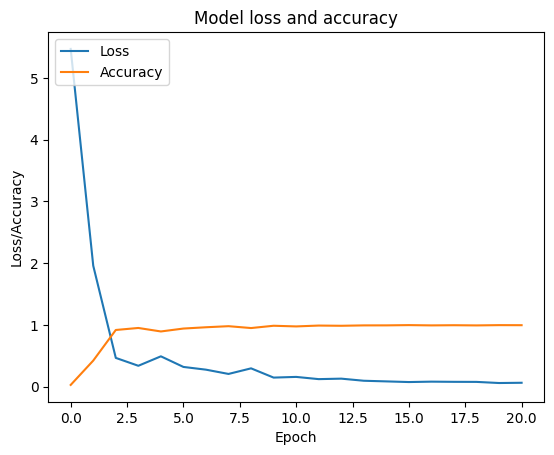

360/360 [==============================] - 14s 39ms/step


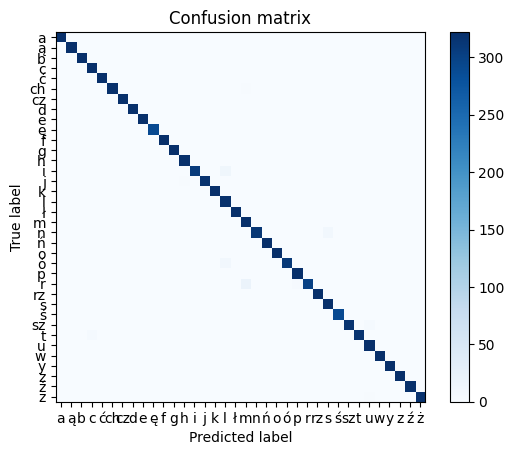

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

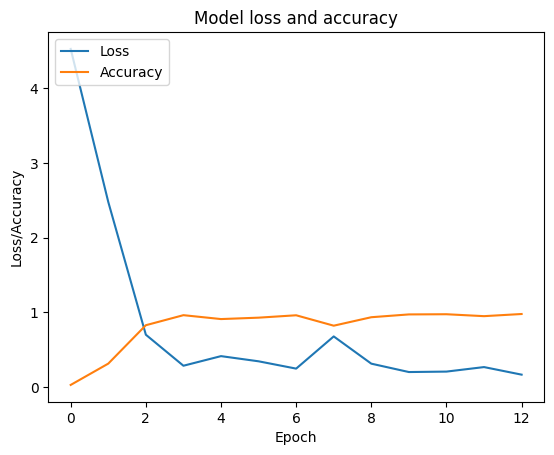

360/360 [==============================] - 15s 41ms/step


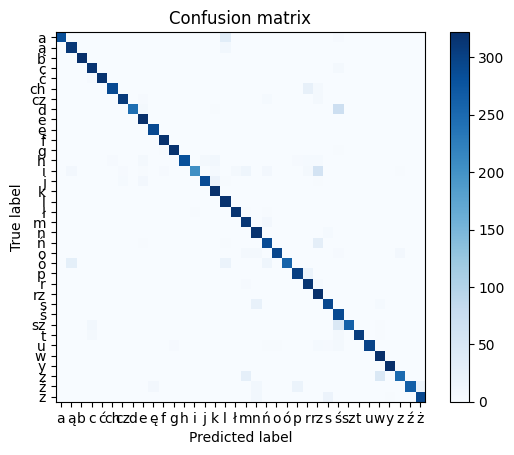

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

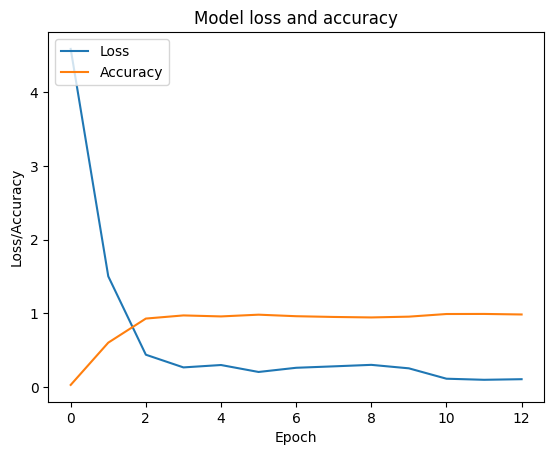

360/360 [==============================] - 14s 39ms/step


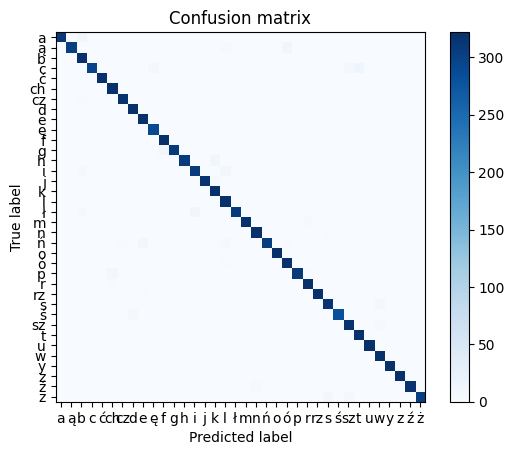

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

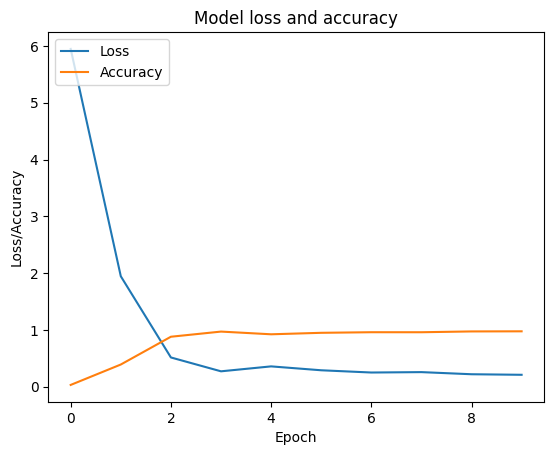

360/360 [==============================] - 14s 39ms/step


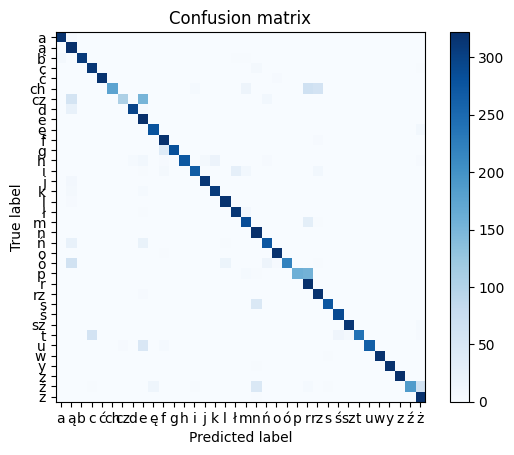

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

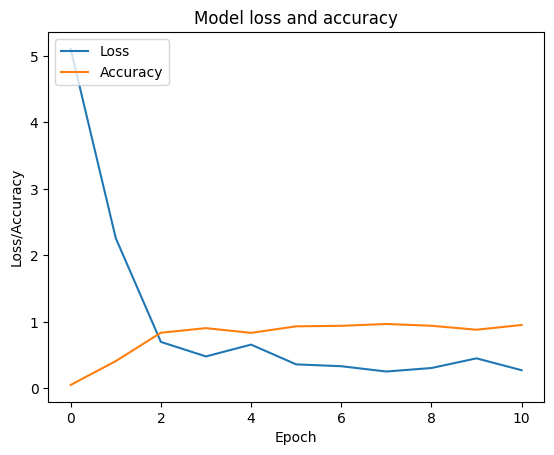

360/360 [==============================] - 14s 38ms/step


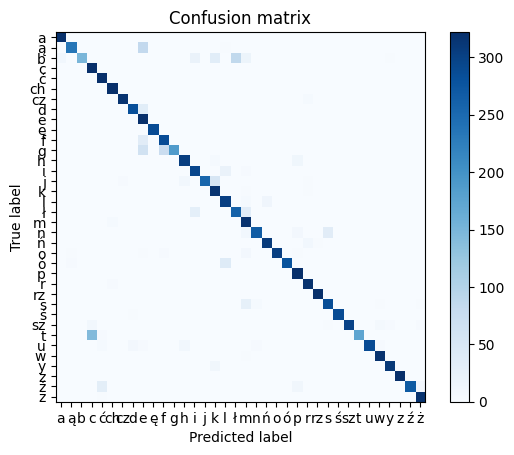

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

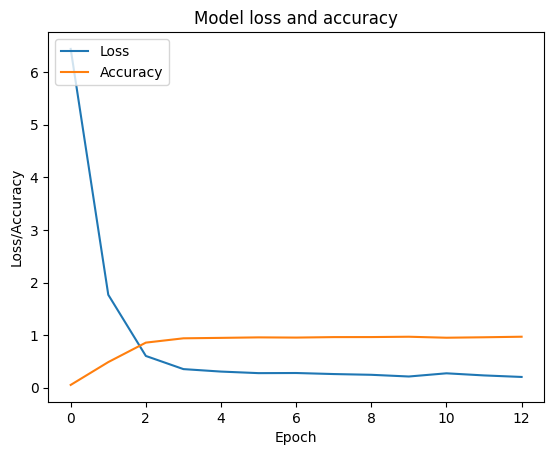

360/360 [==============================] - 14s 38ms/step


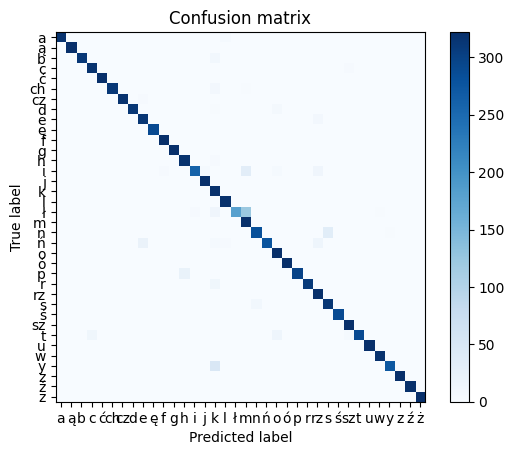

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

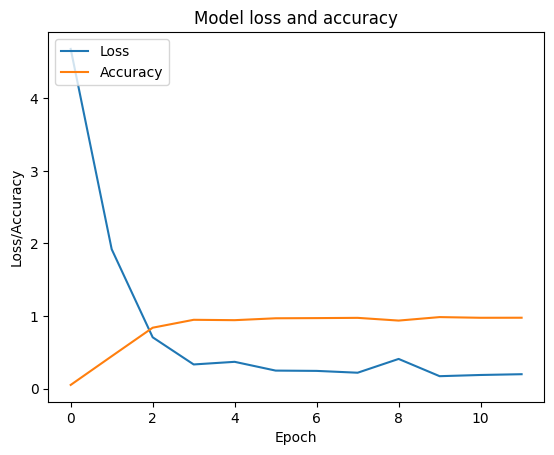

360/360 [==============================] - 14s 39ms/step


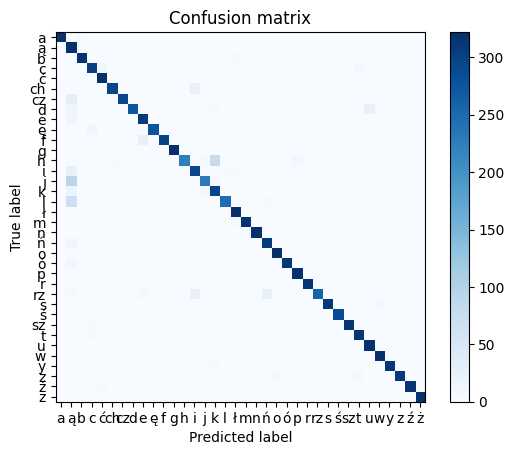

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

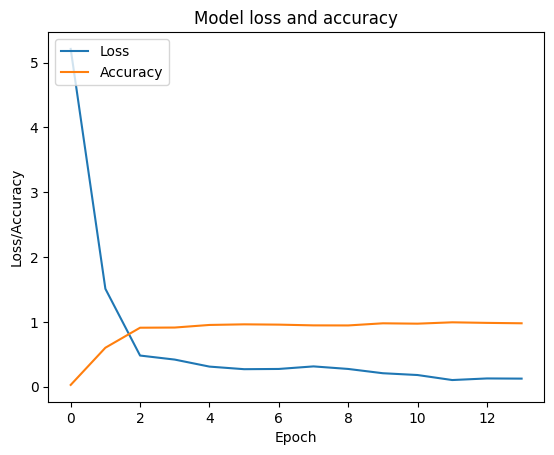

360/360 [==============================] - 15s 40ms/step


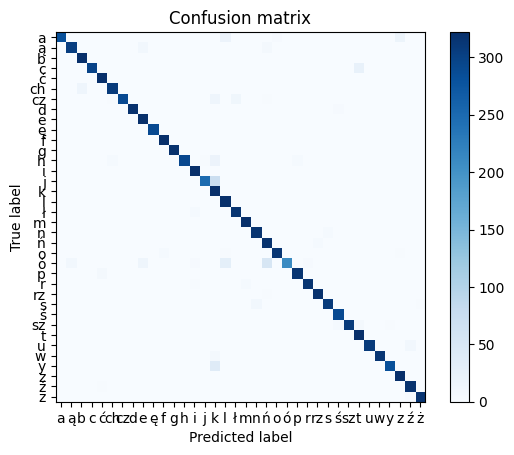

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

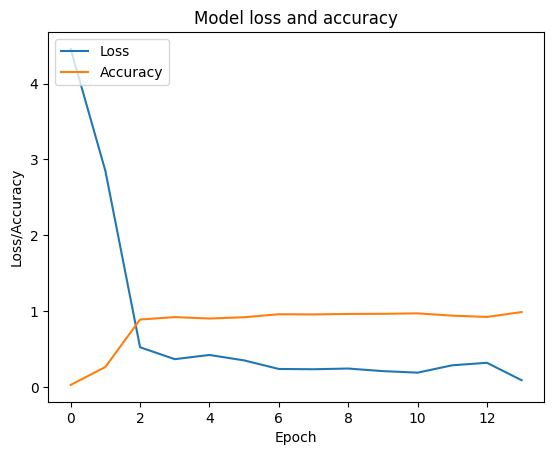

360/360 [==============================] - 14s 39ms/step


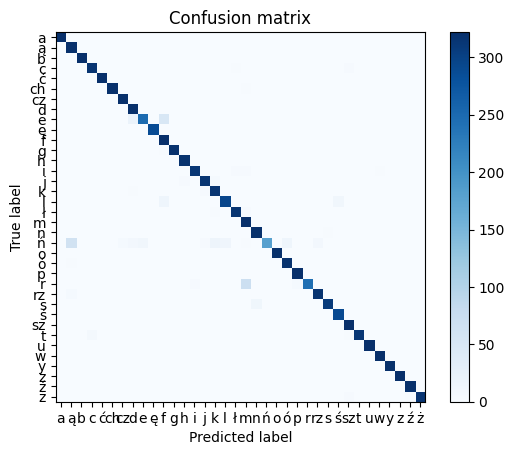

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

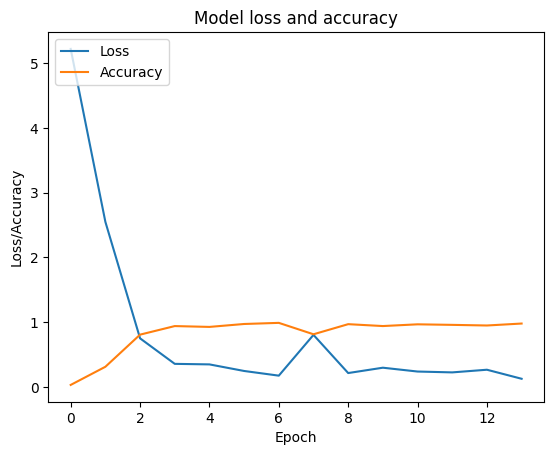

360/360 [==============================] - 14s 39ms/step


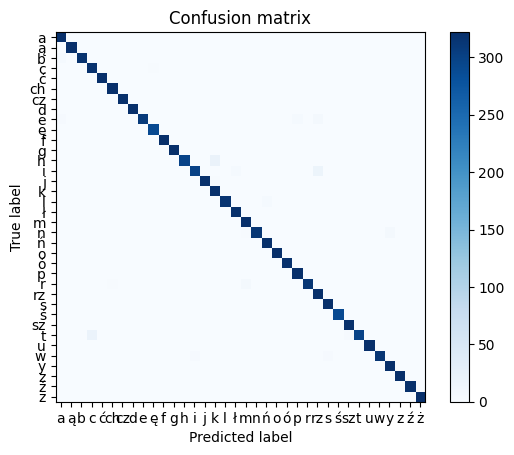

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

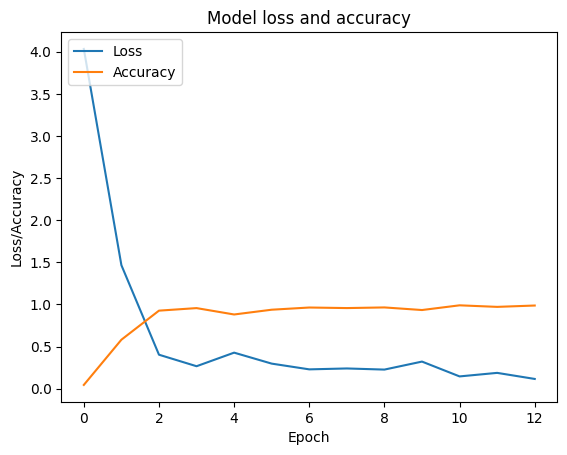

360/360 [==============================] - 14s 37ms/step


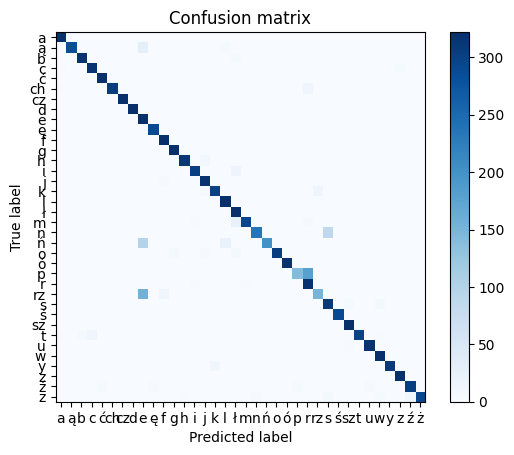

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

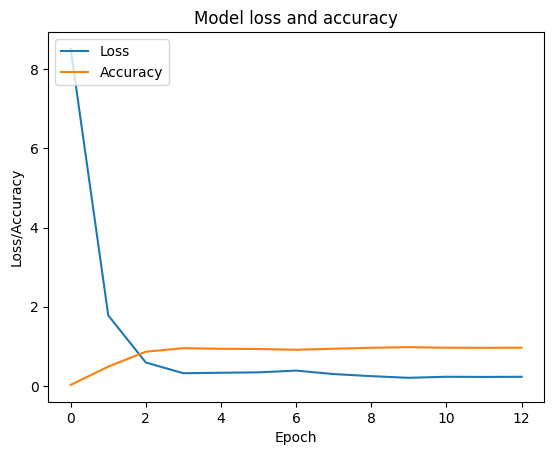

360/360 [==============================] - 15s 37ms/step


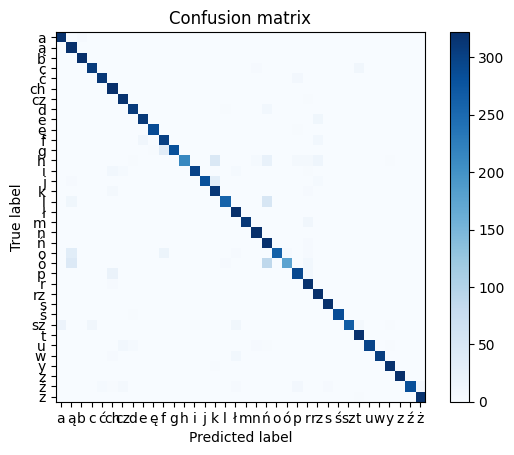

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

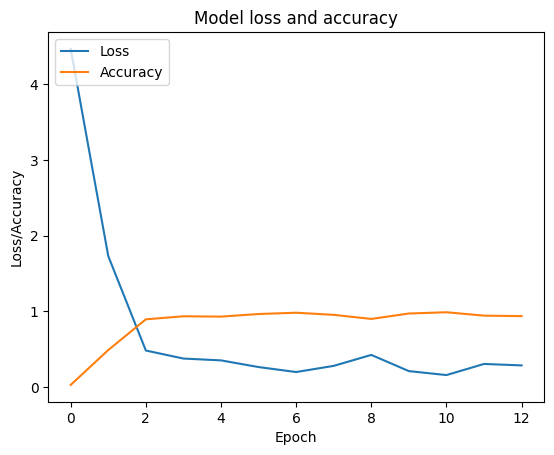

360/360 [==============================] - 14s 38ms/step


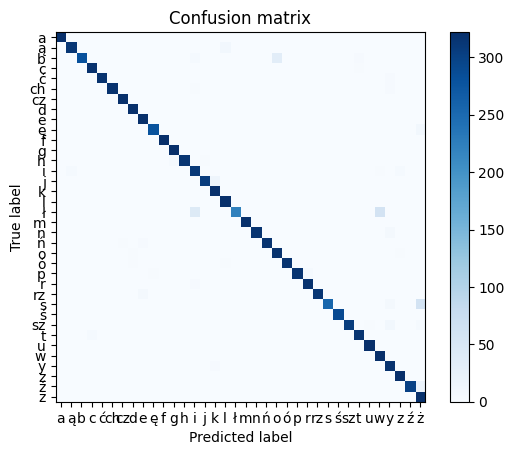

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

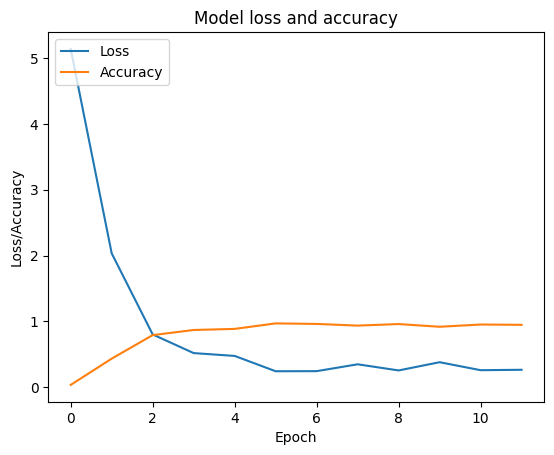

360/360 [==============================] - 15s 42ms/step


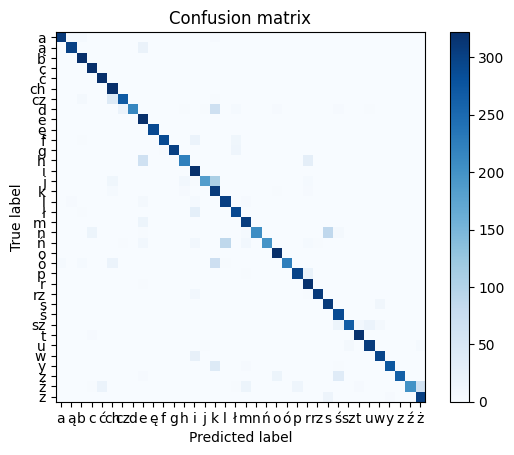

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

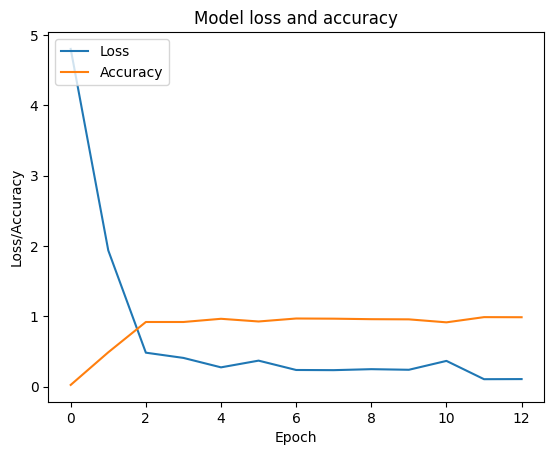

360/360 [==============================] - 15s 40ms/step


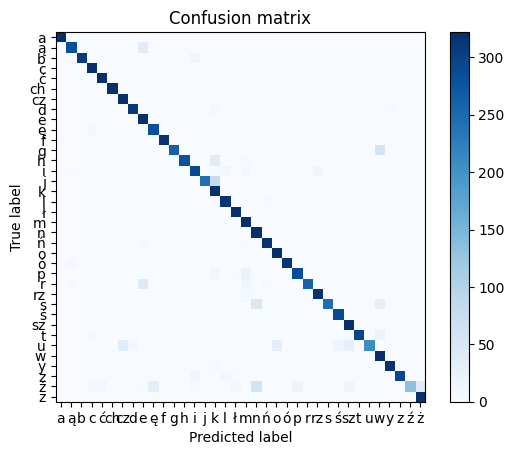

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

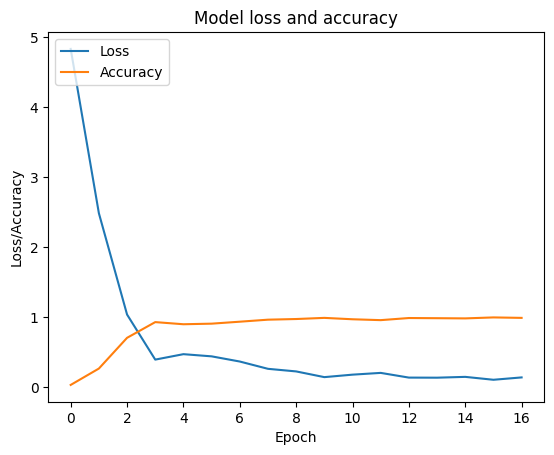

360/360 [==============================] - 15s 41ms/step


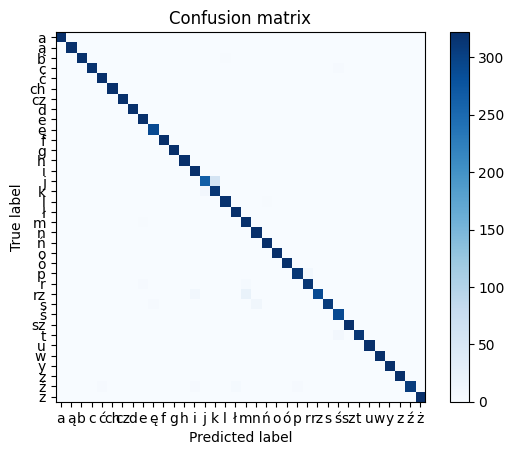

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

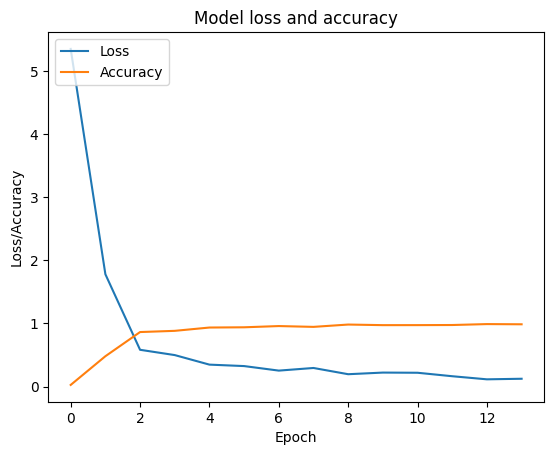

360/360 [==============================] - 14s 39ms/step


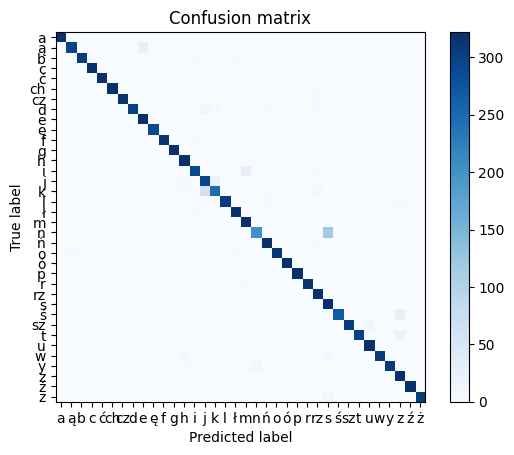

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

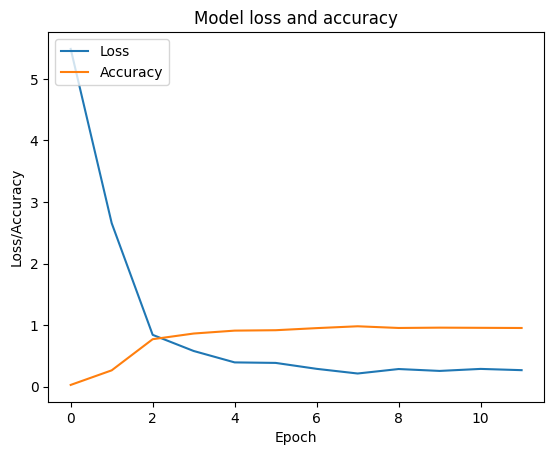

360/360 [==============================] - 15s 40ms/step


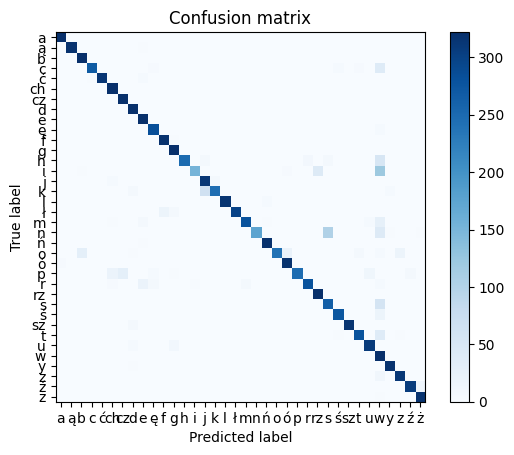

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

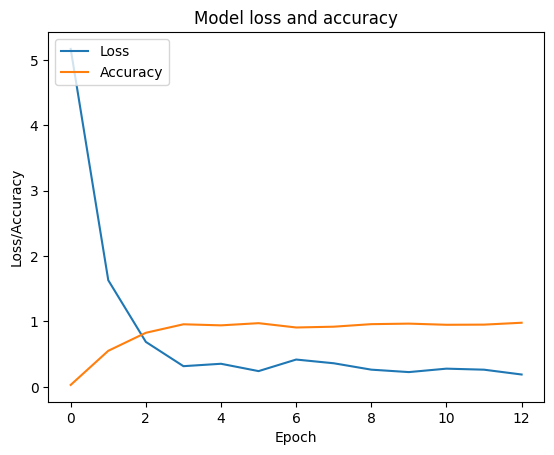

360/360 [==============================] - 14s 37ms/step


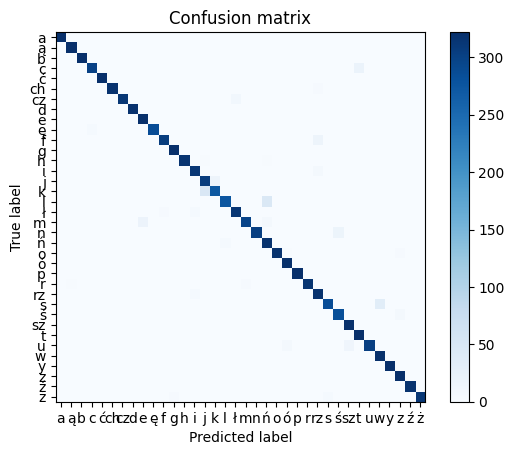

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

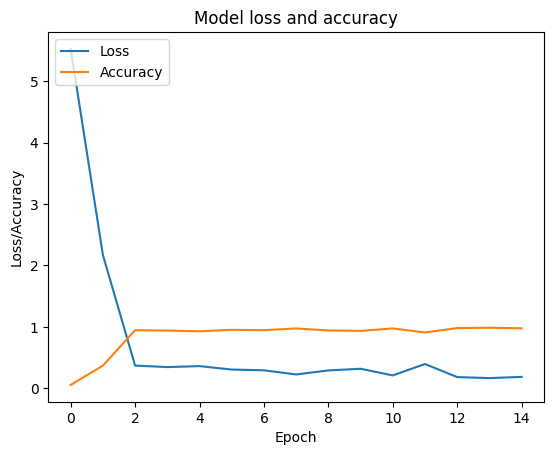

360/360 [==============================] - 15s 41ms/step


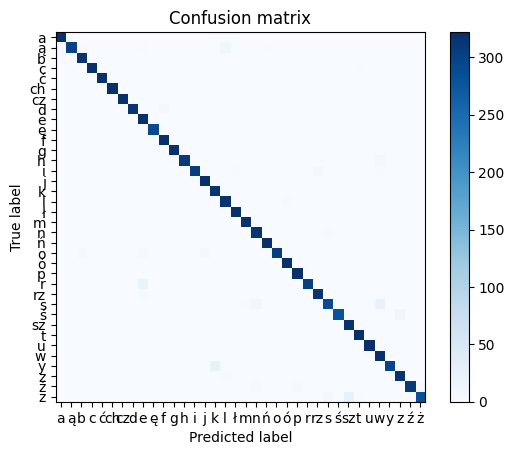

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

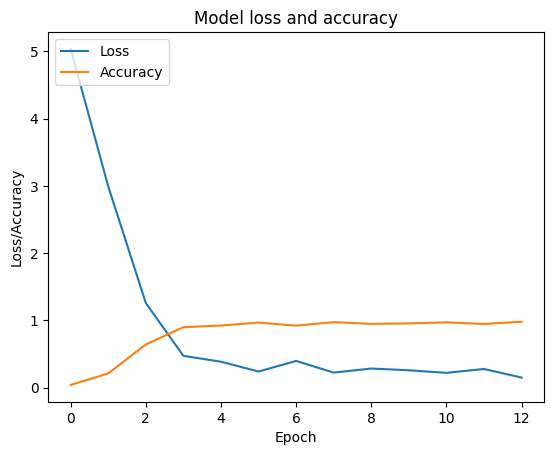

360/360 [==============================] - 14s 39ms/step


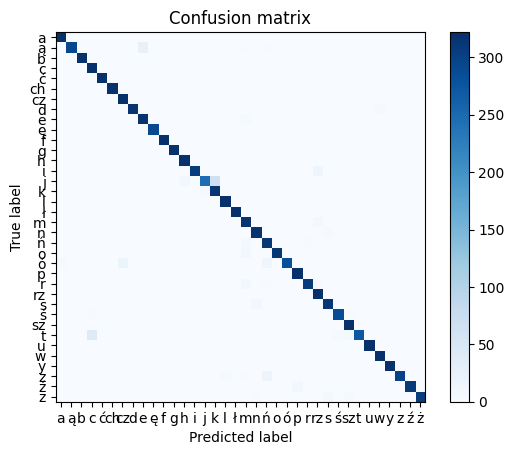

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

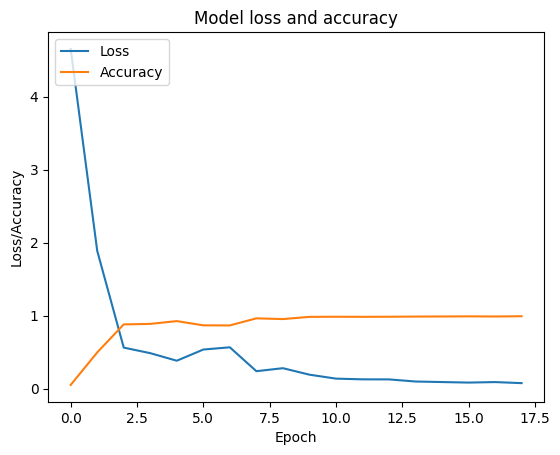

360/360 [==============================] - 15s 41ms/step


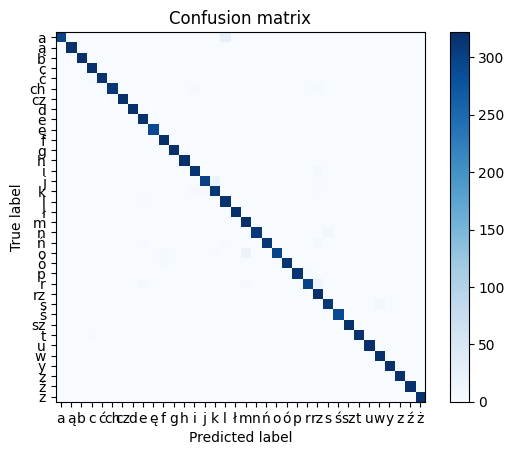

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

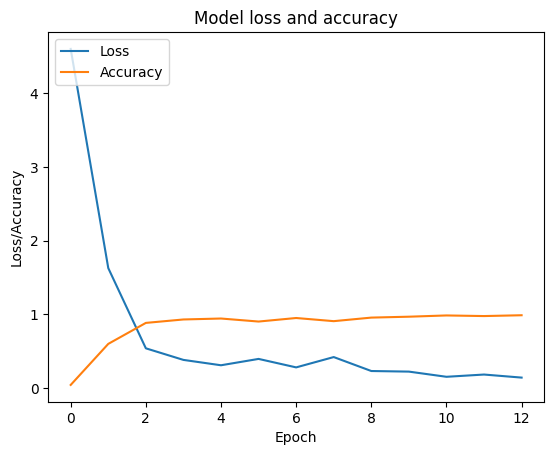

360/360 [==============================] - 15s 39ms/step


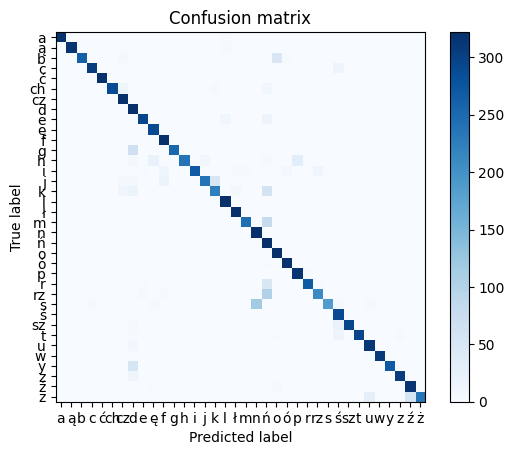

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

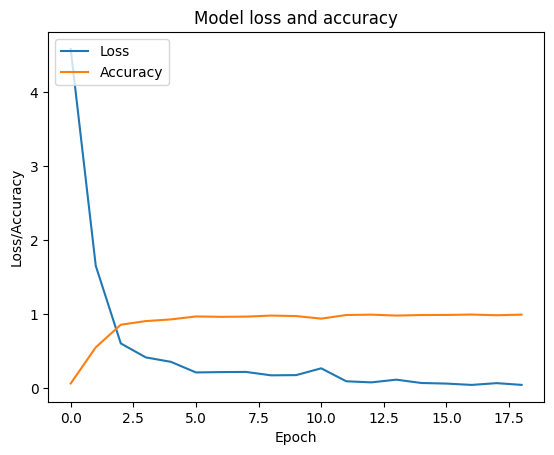

360/360 [==============================] - 14s 39ms/step


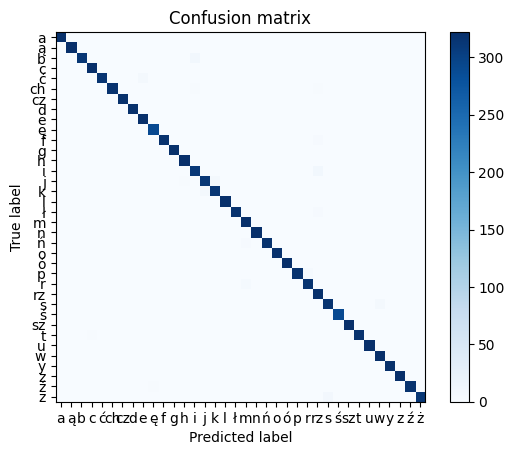

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

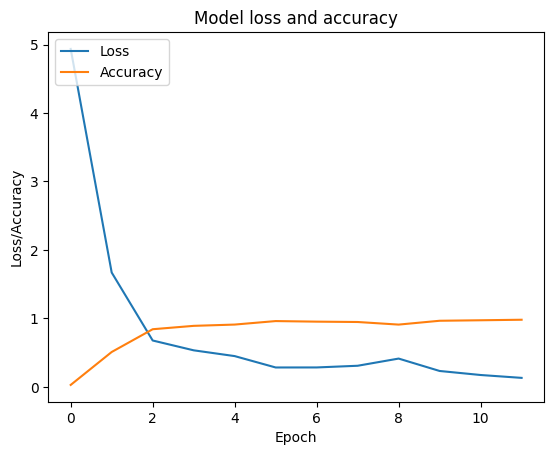

360/360 [==============================] - 15s 40ms/step


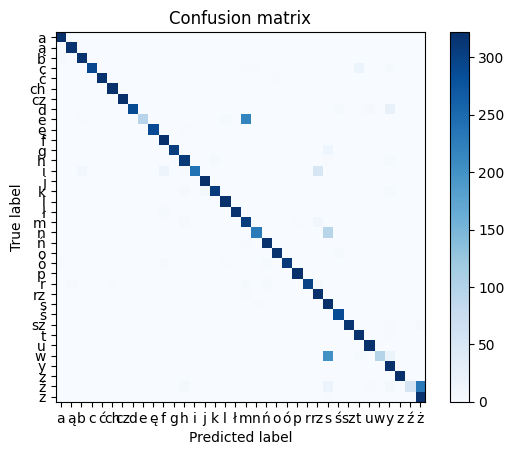

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

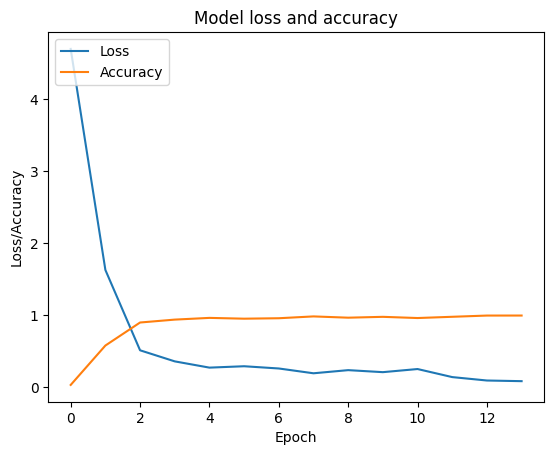

360/360 [==============================] - 16s 42ms/step


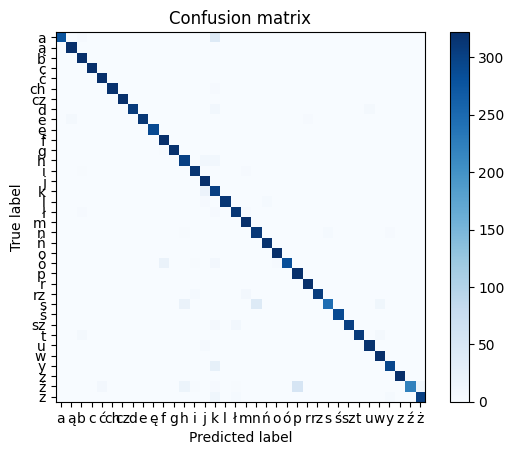

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

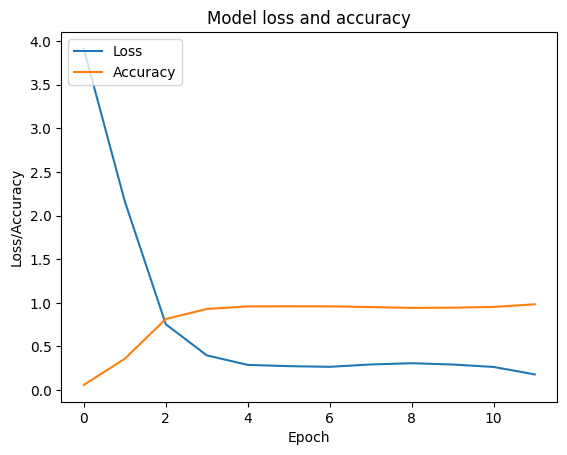

360/360 [==============================] - 14s 38ms/step


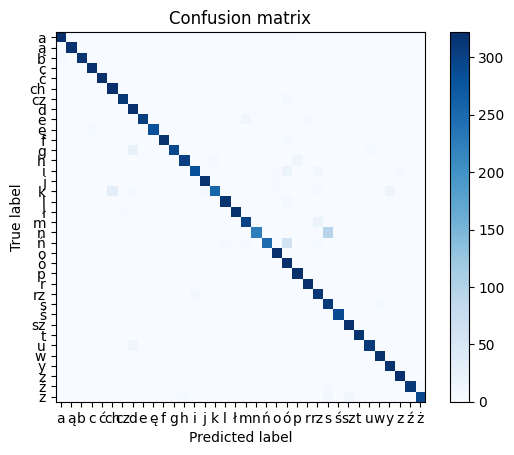

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

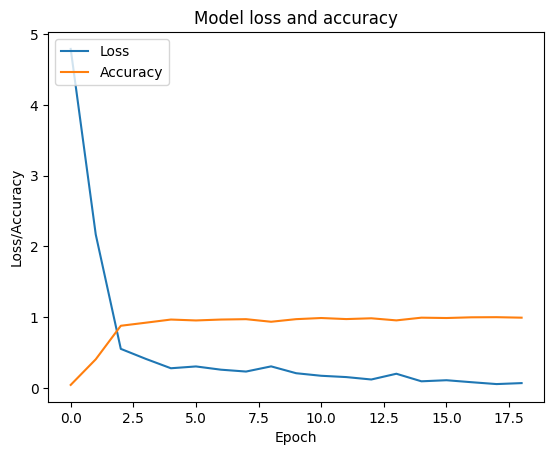

360/360 [==============================] - 13s 36ms/step


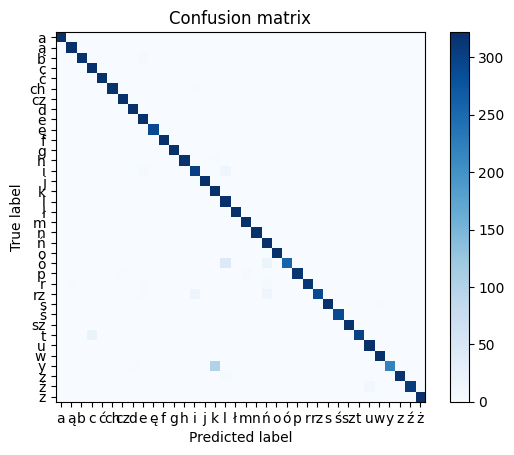

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

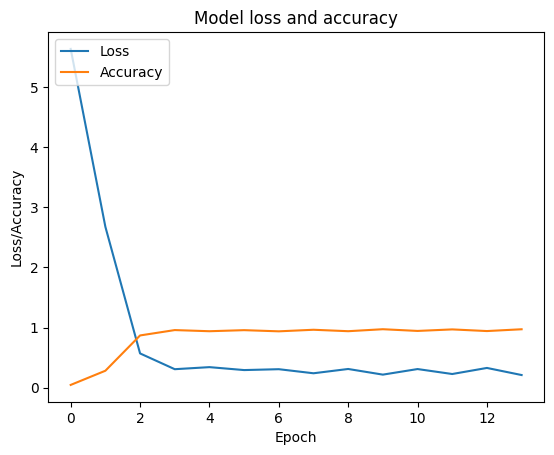

360/360 [==============================] - 14s 39ms/step


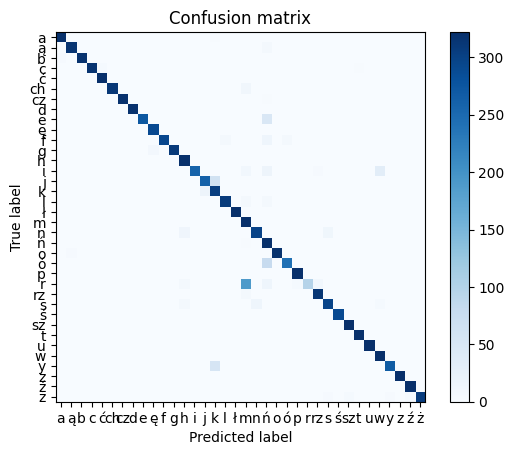

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

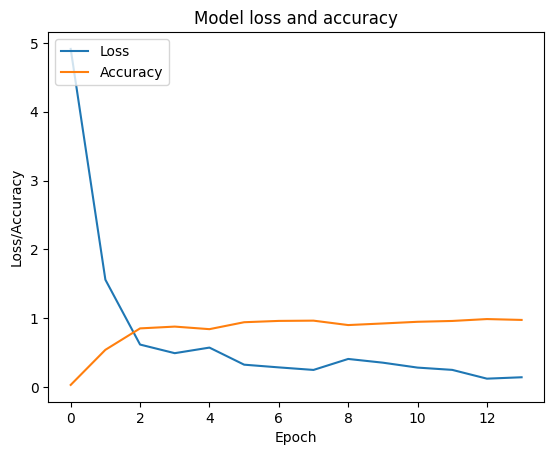

360/360 [==============================] - 14s 38ms/step


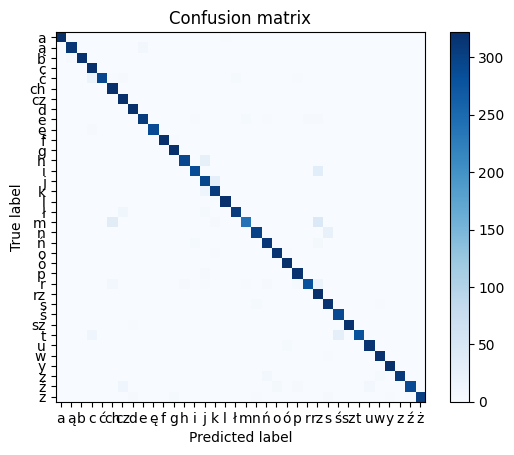

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

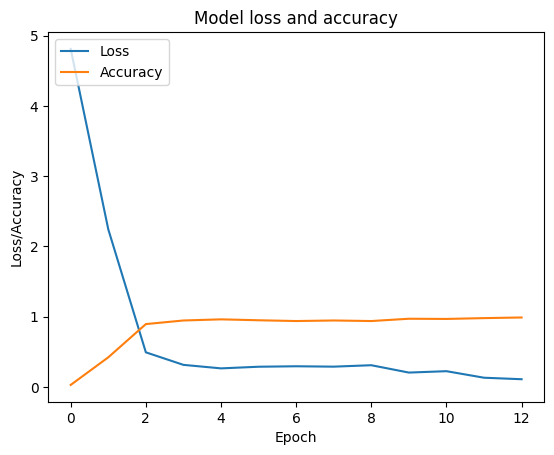

360/360 [==============================] - 14s 39ms/step


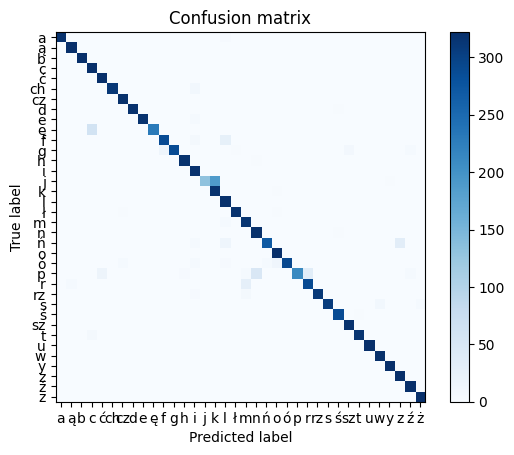

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

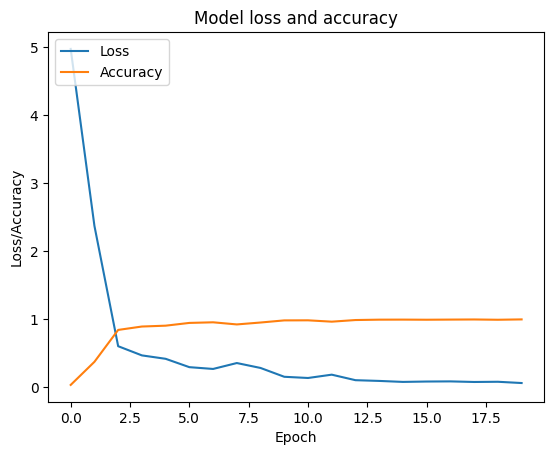

360/360 [==============================] - 14s 39ms/step


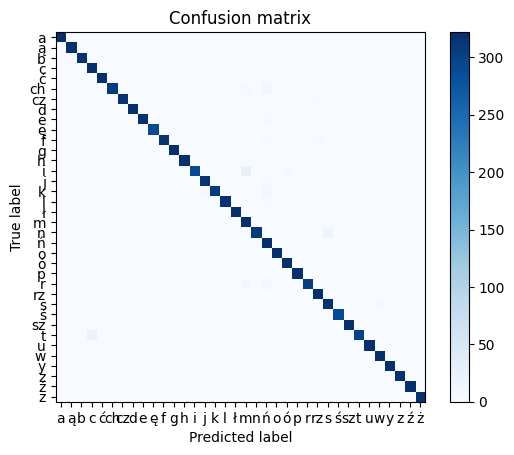

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

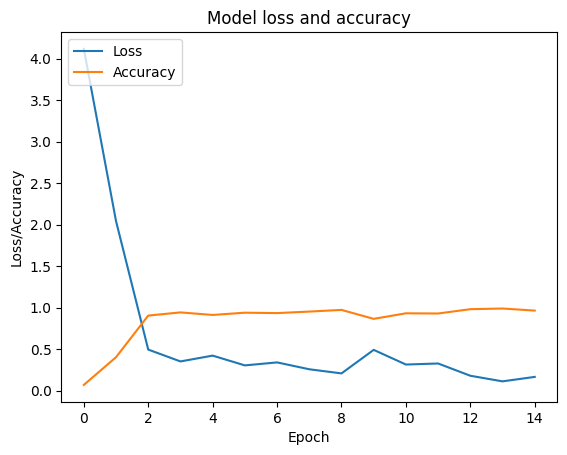

360/360 [==============================] - 15s 40ms/step


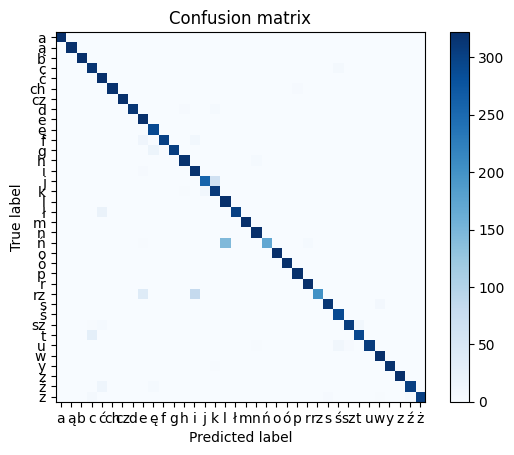

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

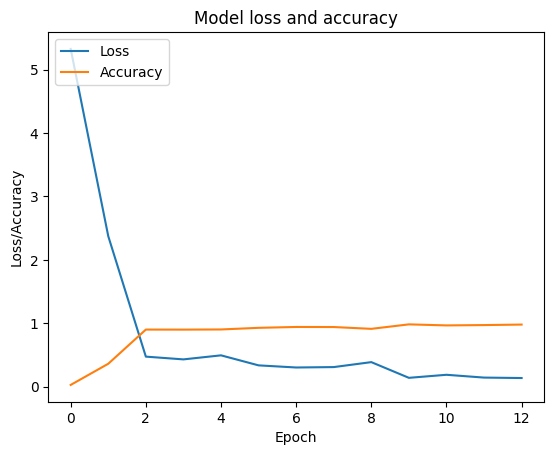

360/360 [==============================] - 14s 39ms/step


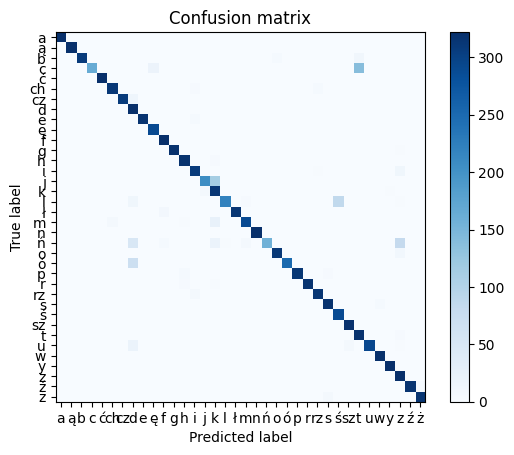

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

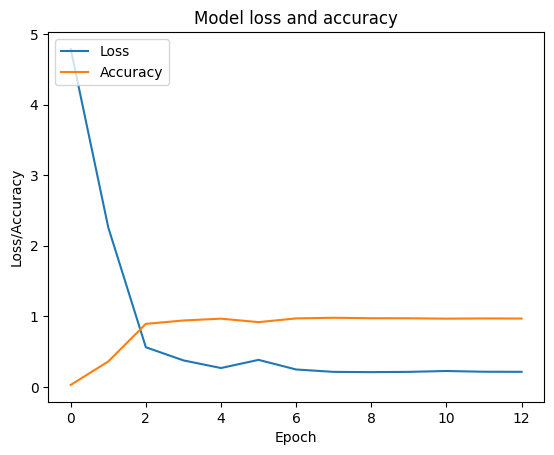

360/360 [==============================] - 16s 39ms/step


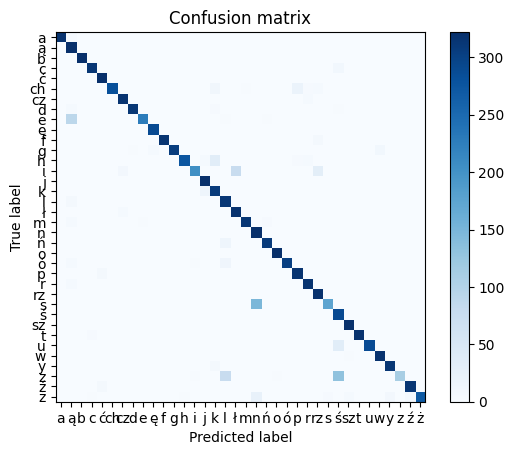

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

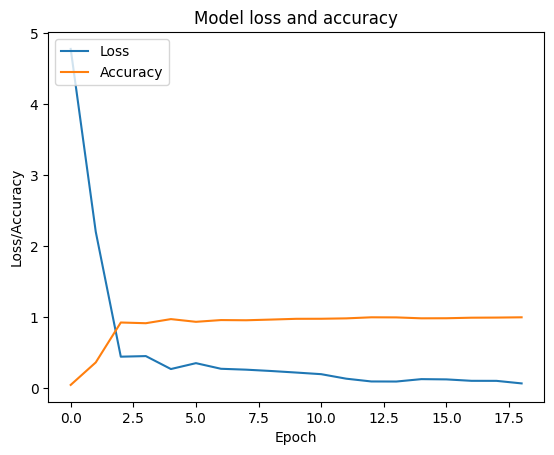

360/360 [==============================] - 14s 39ms/step


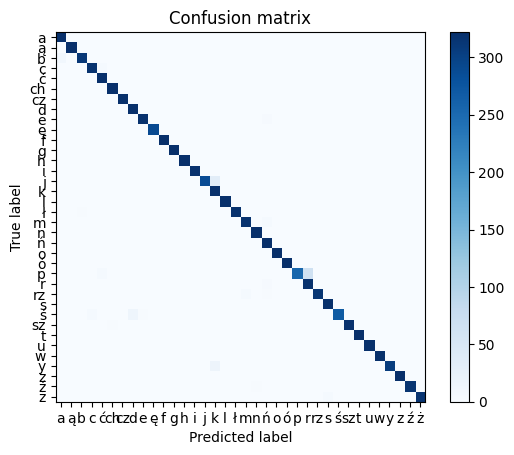

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

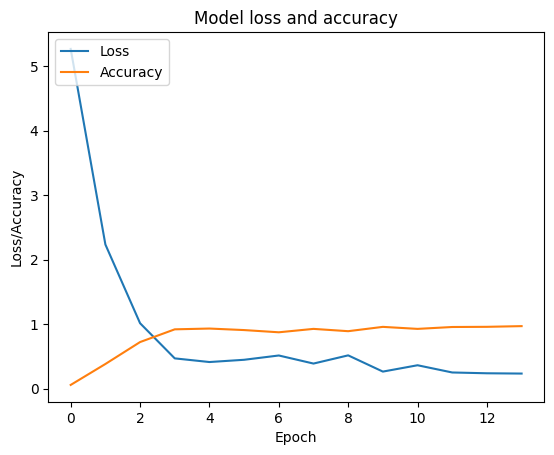

360/360 [==============================] - 15s 40ms/step


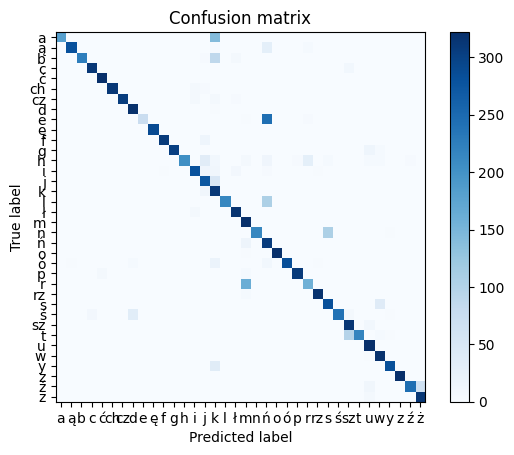

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

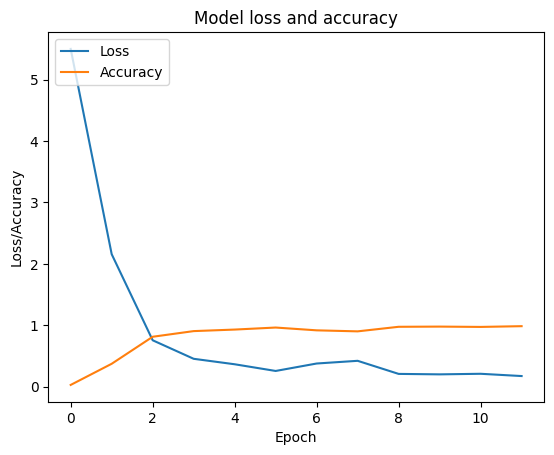

360/360 [==============================] - 14s 39ms/step


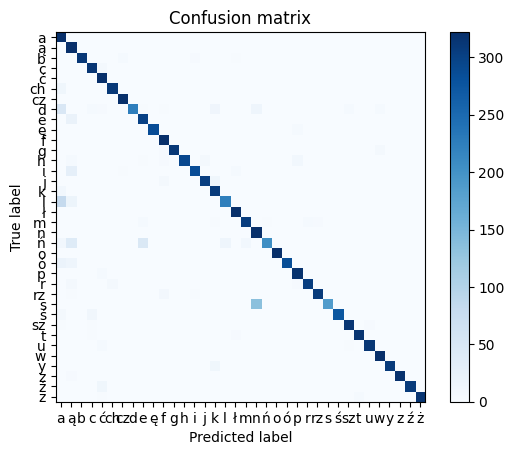

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

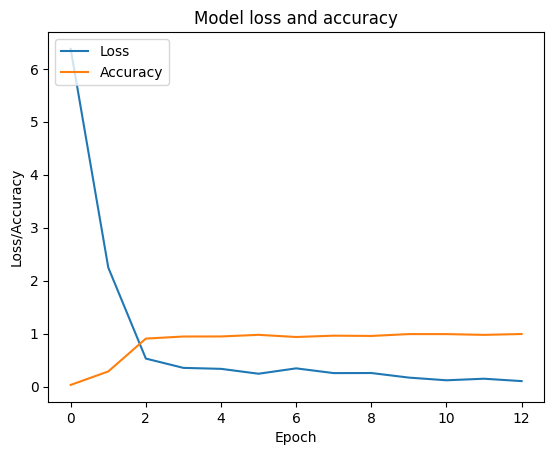

360/360 [==============================] - 16s 39ms/step


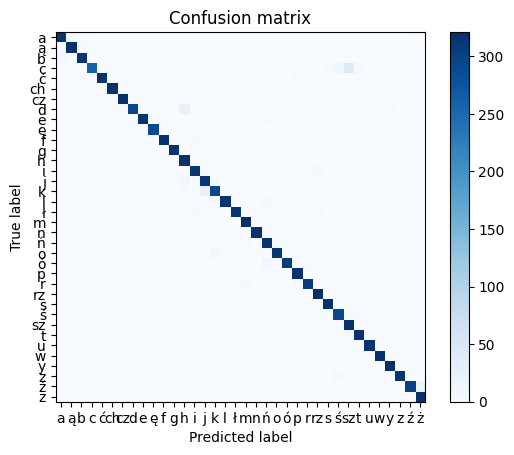

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

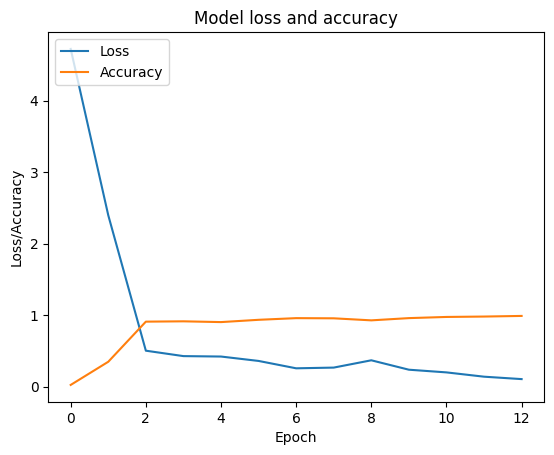

360/360 [==============================] - 14s 40ms/step


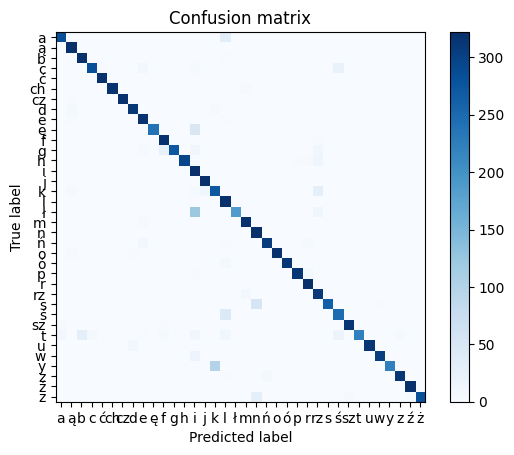

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

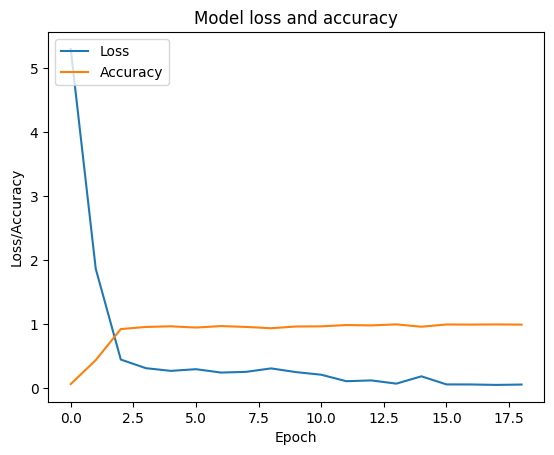

360/360 [==============================] - 14s 38ms/step


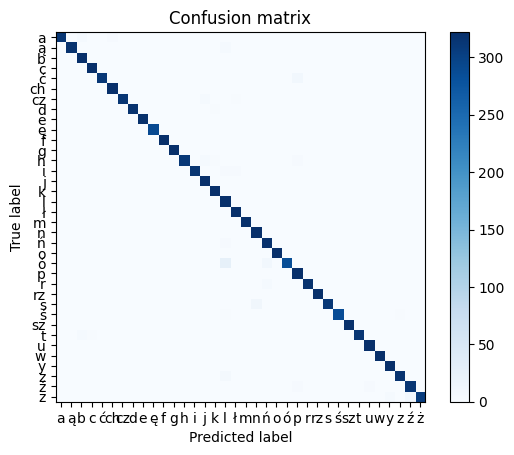

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

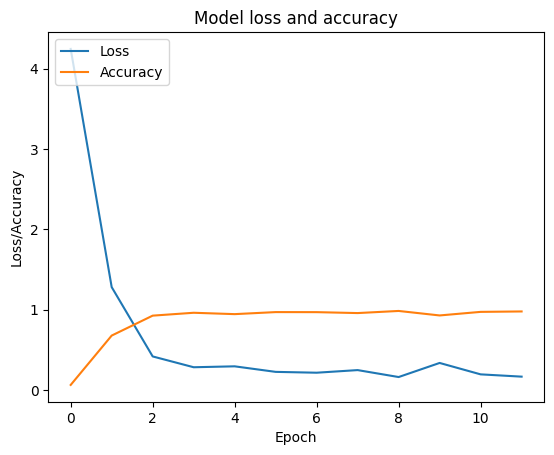

360/360 [==============================] - 14s 39ms/step


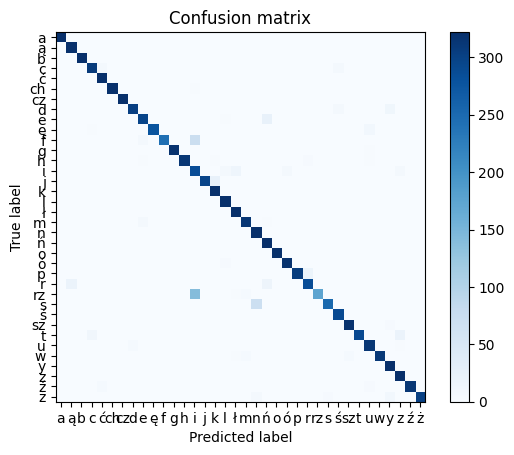

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

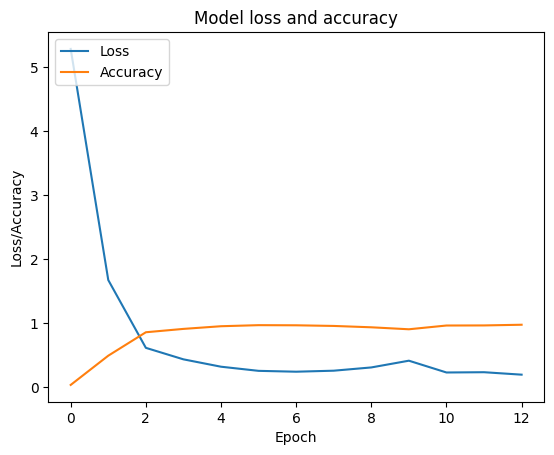

360/360 [==============================] - 15s 40ms/step


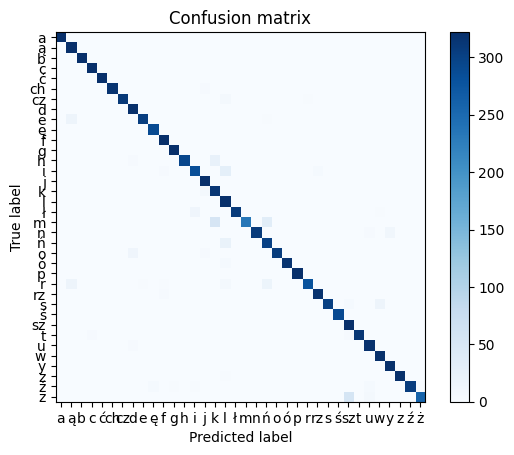

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

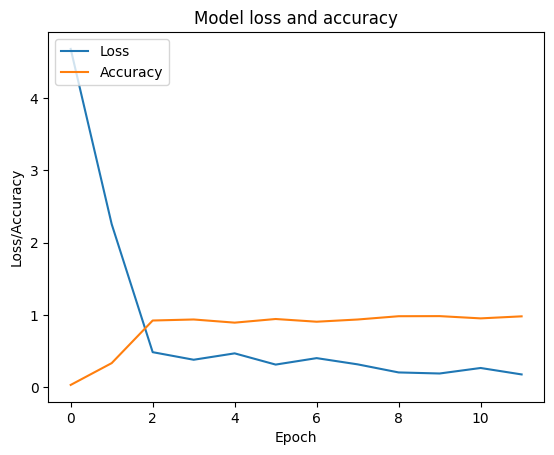

360/360 [==============================] - 15s 42ms/step


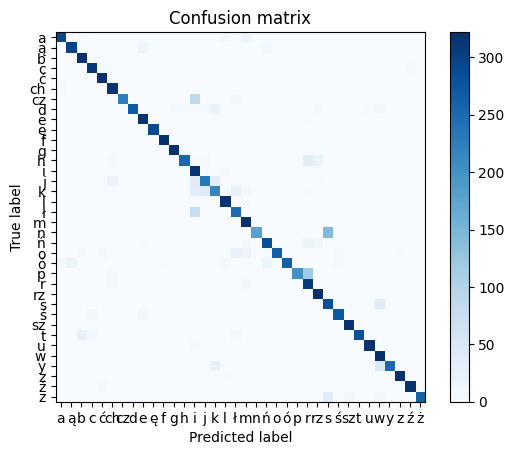

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

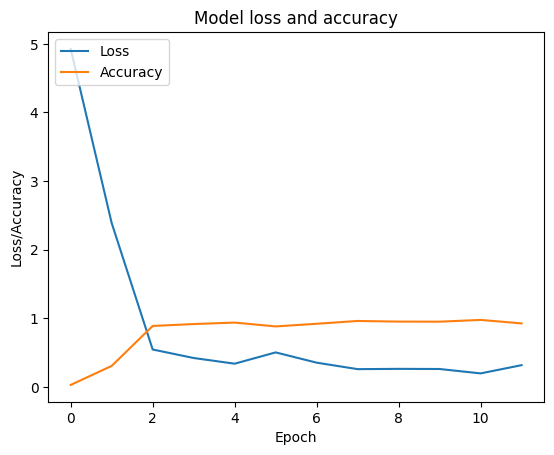

360/360 [==============================] - 15s 39ms/step


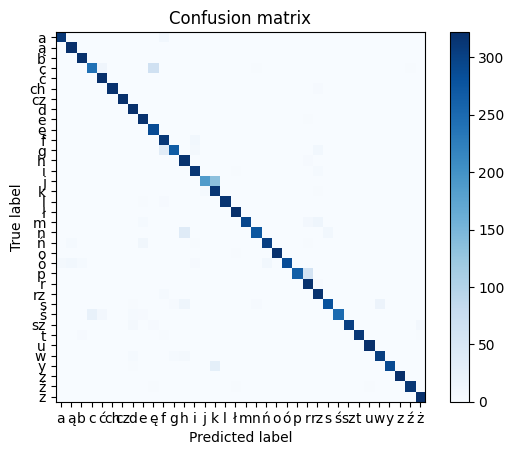

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

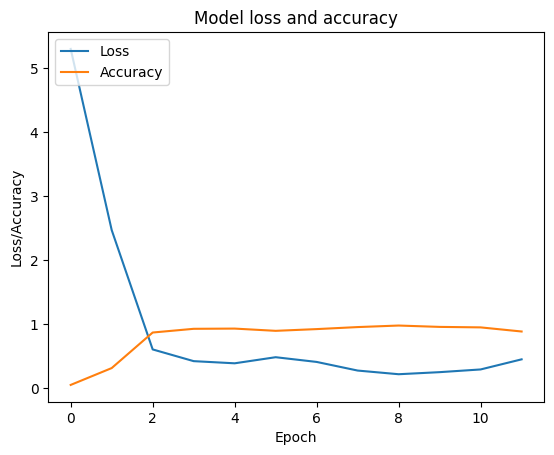

360/360 [==============================] - 13s 36ms/step


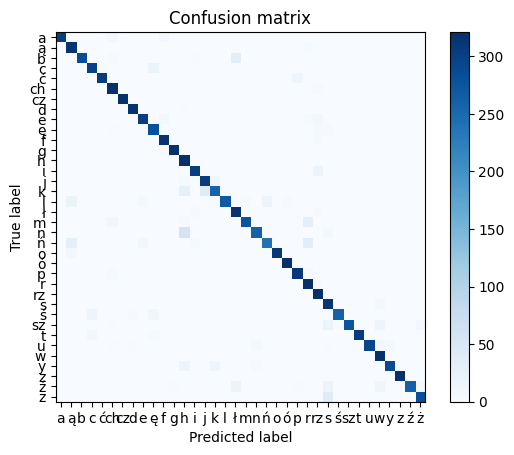

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

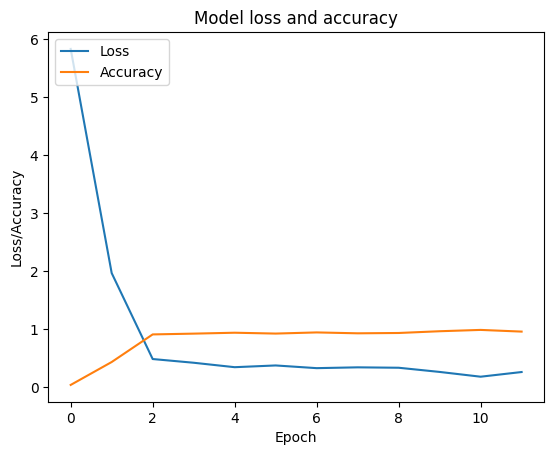

360/360 [==============================] - 14s 39ms/step


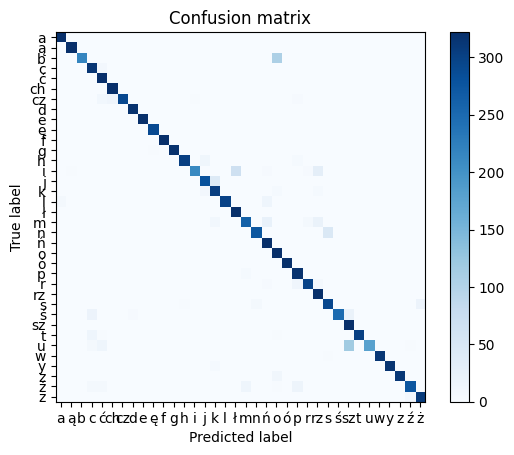

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

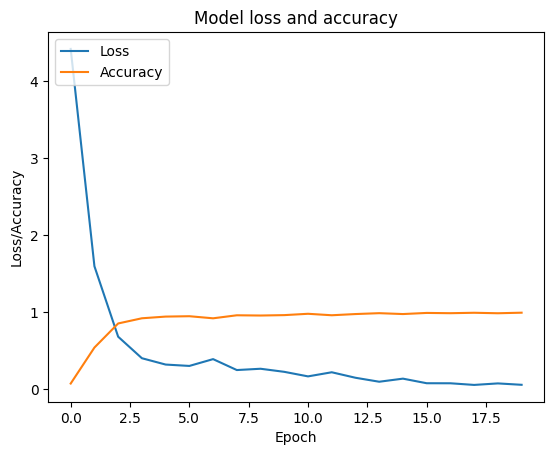

360/360 [==============================] - 15s 41ms/step


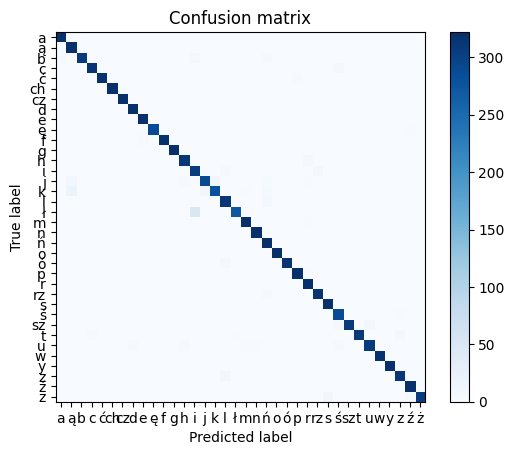

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

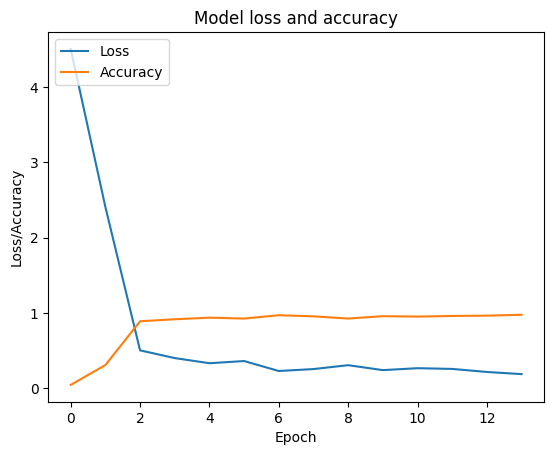

360/360 [==============================] - 15s 40ms/step


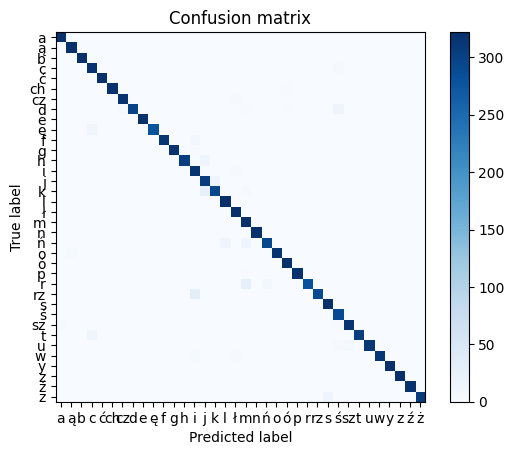

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

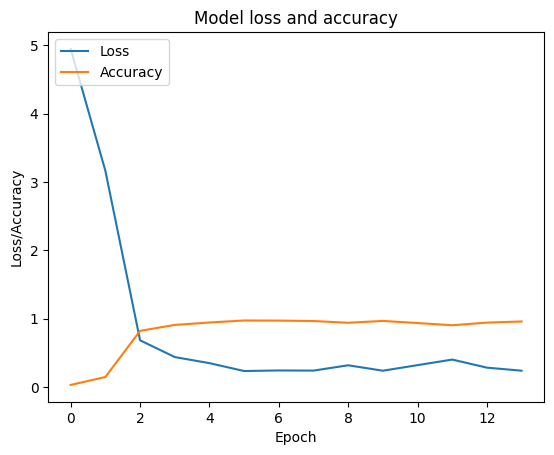

360/360 [==============================] - 14s 37ms/step


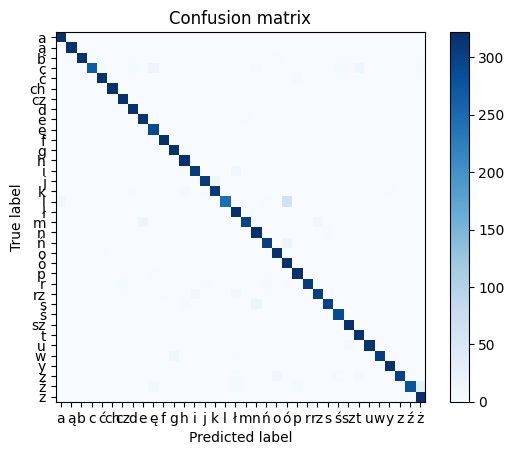

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

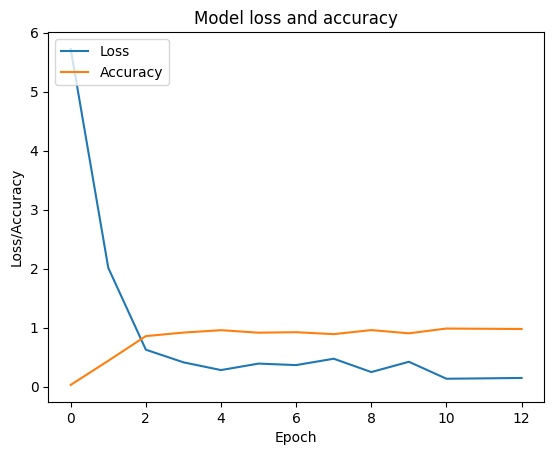

360/360 [==============================] - 14s 37ms/step


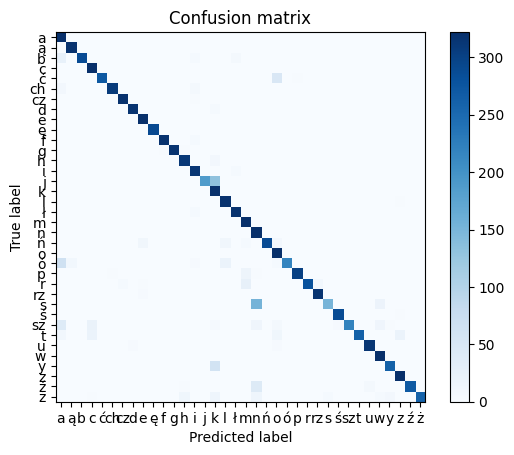

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

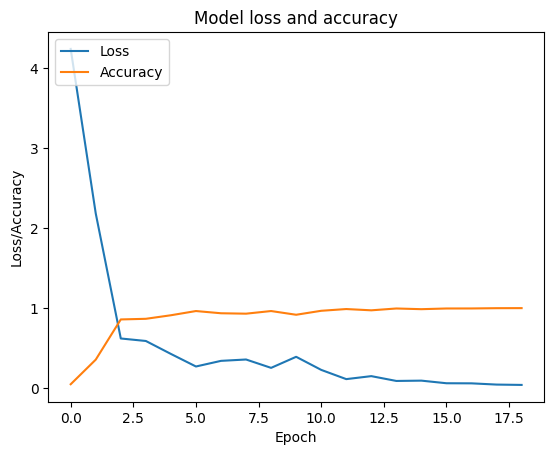

360/360 [==============================] - 15s 42ms/step


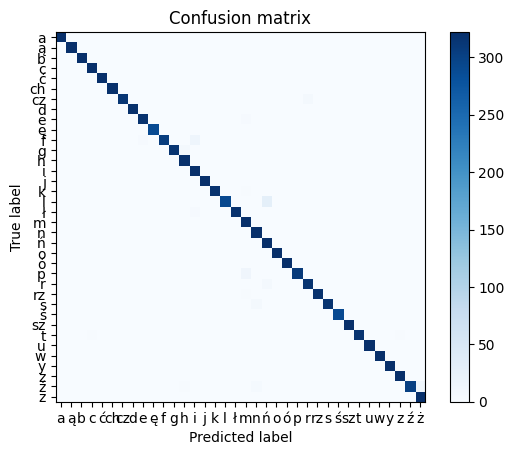

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

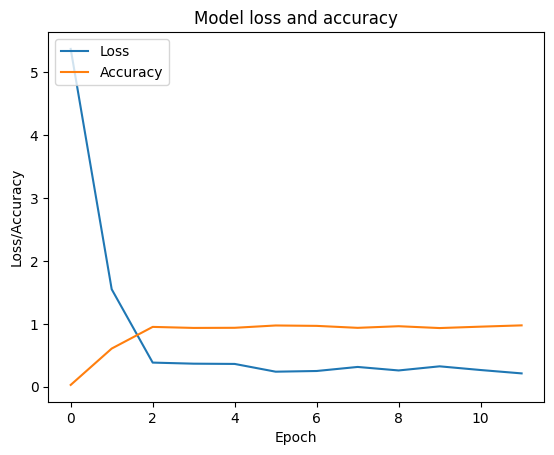

360/360 [==============================] - 15s 40ms/step


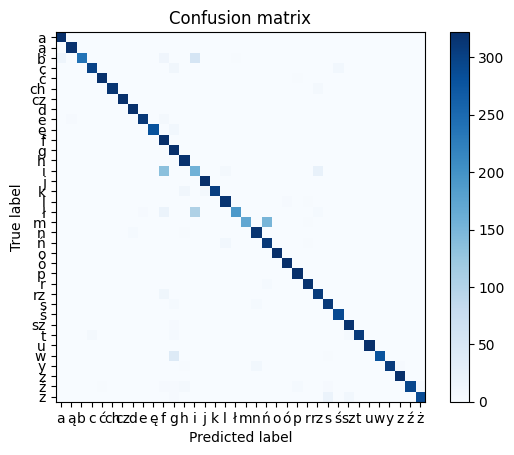

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

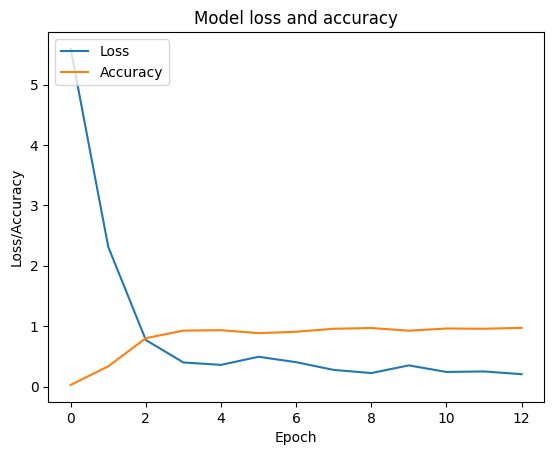

360/360 [==============================] - 16s 43ms/step


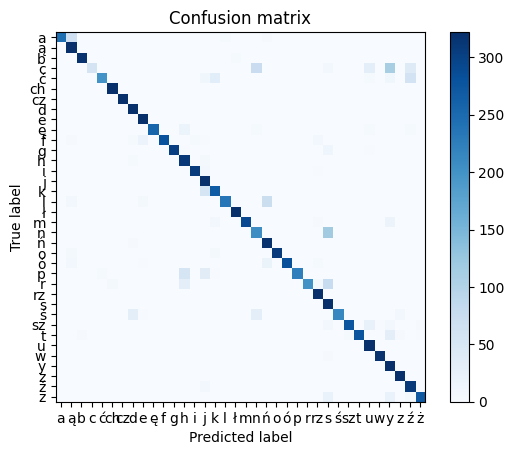

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

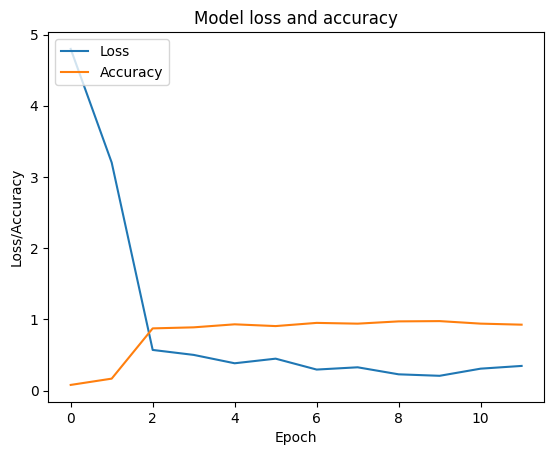

360/360 [==============================] - 15s 41ms/step


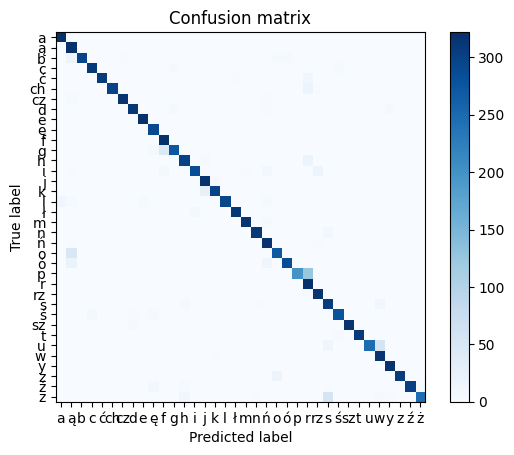

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

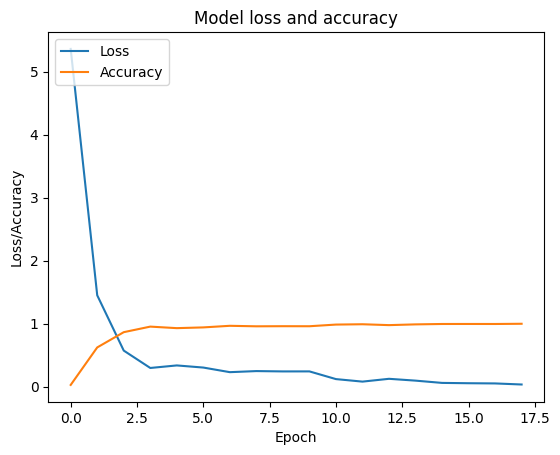

360/360 [==============================] - 15s 40ms/step


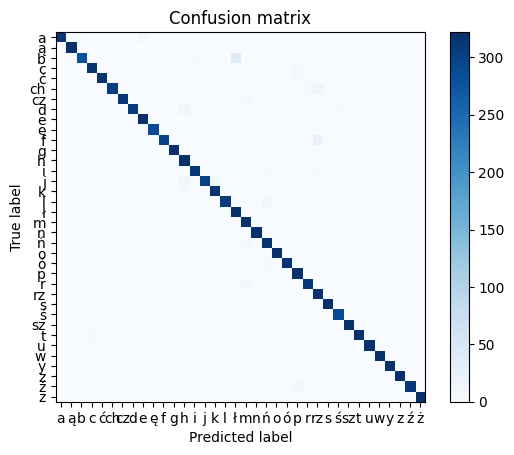

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

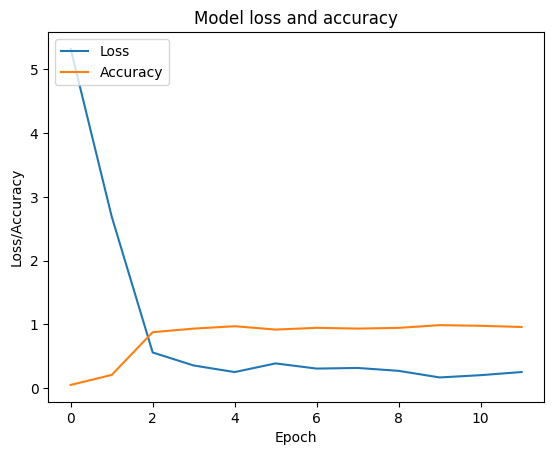

360/360 [==============================] - 16s 43ms/step


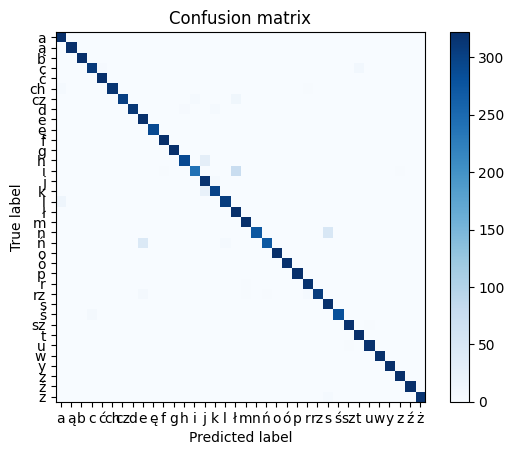

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

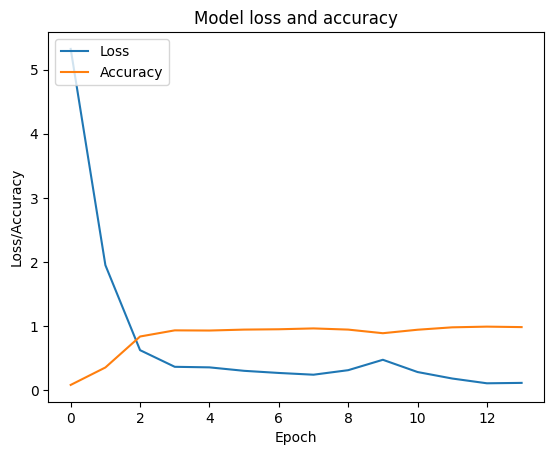

360/360 [==============================] - 16s 43ms/step


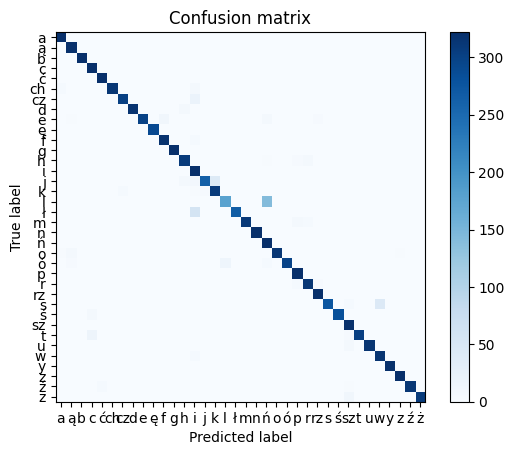

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

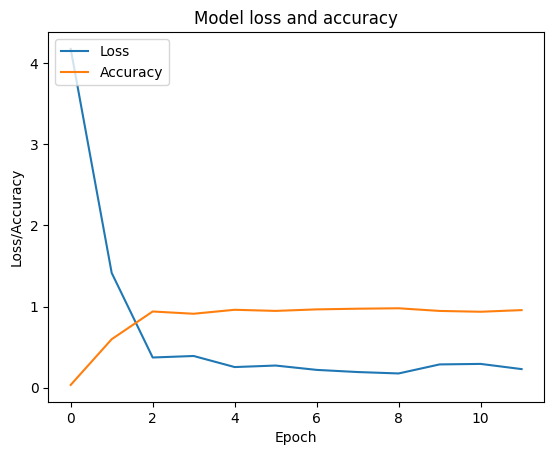

360/360 [==============================] - 15s 41ms/step


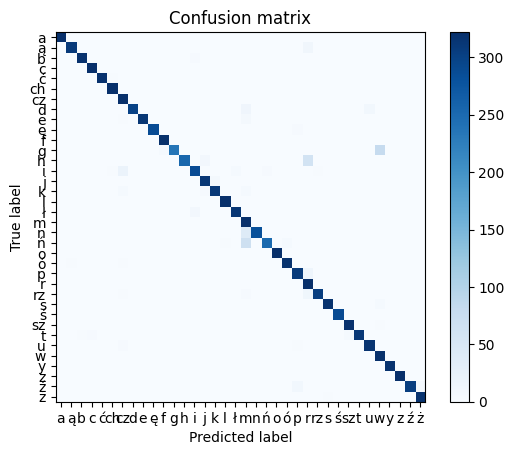

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

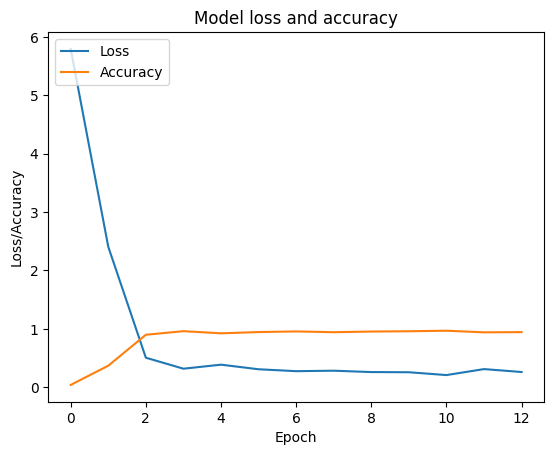

360/360 [==============================] - 17s 45ms/step


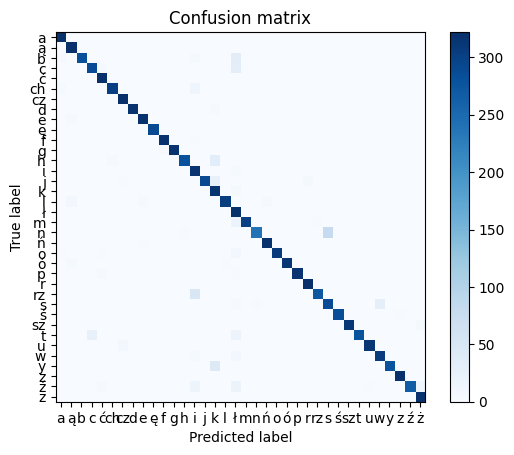

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

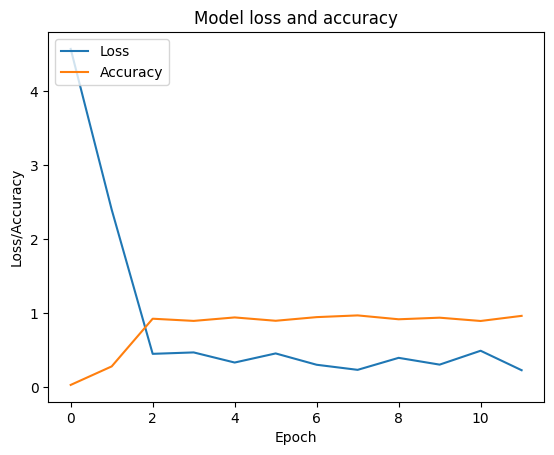

360/360 [==============================] - 15s 41ms/step


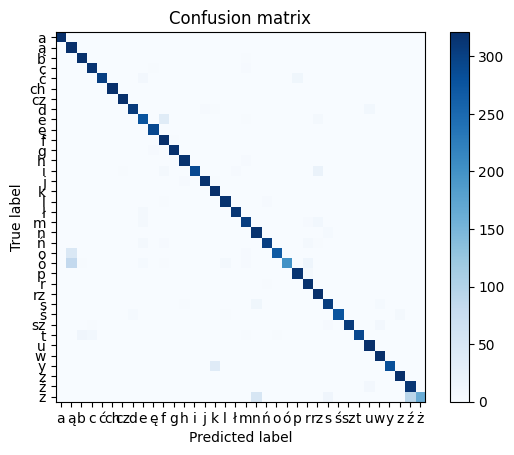

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

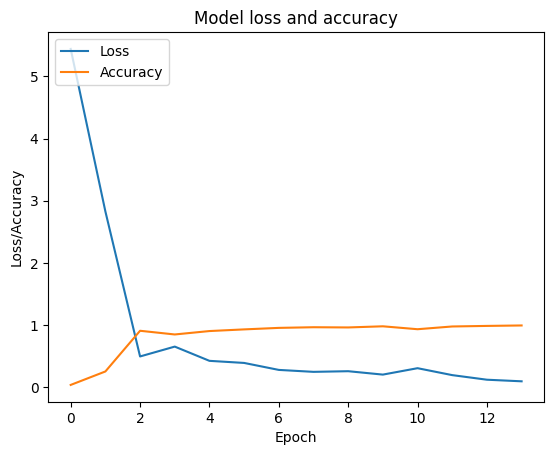

360/360 [==============================] - 15s 42ms/step


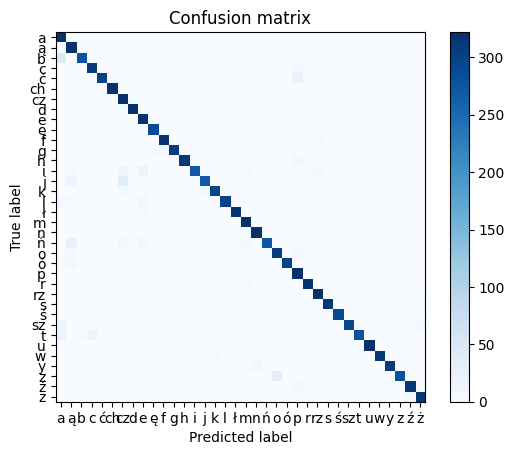

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

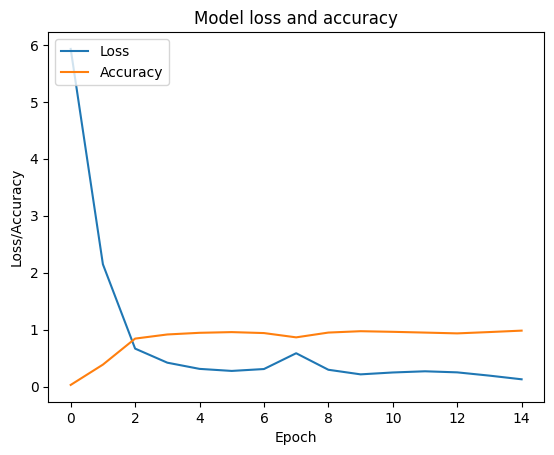

360/360 [==============================] - 15s 41ms/step


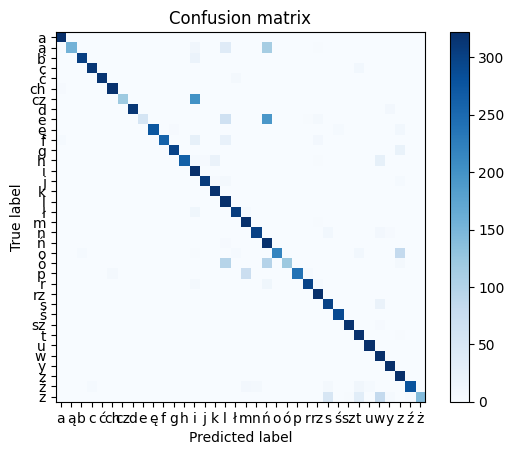

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

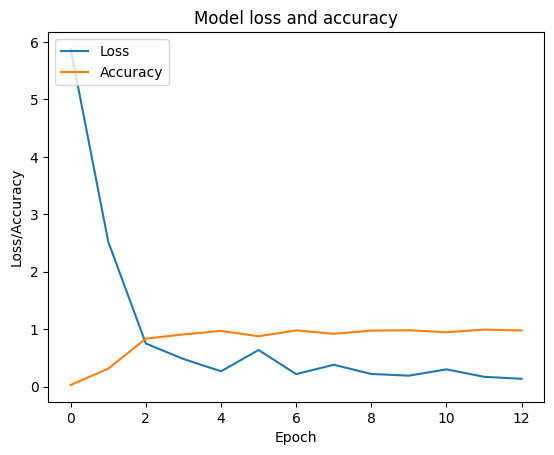

360/360 [==============================] - 15s 42ms/step


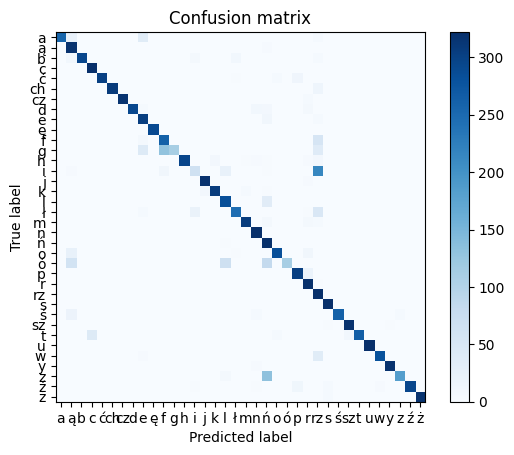

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

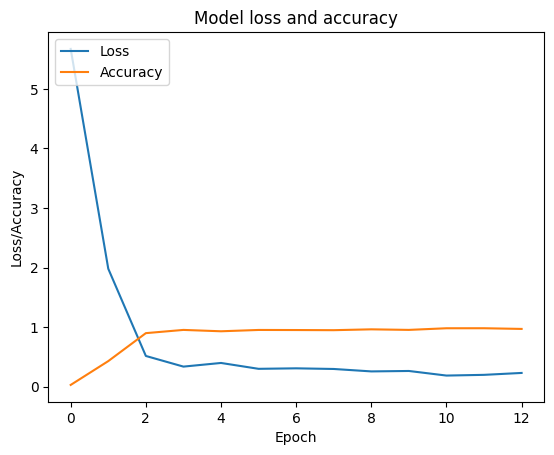

360/360 [==============================] - 15s 41ms/step


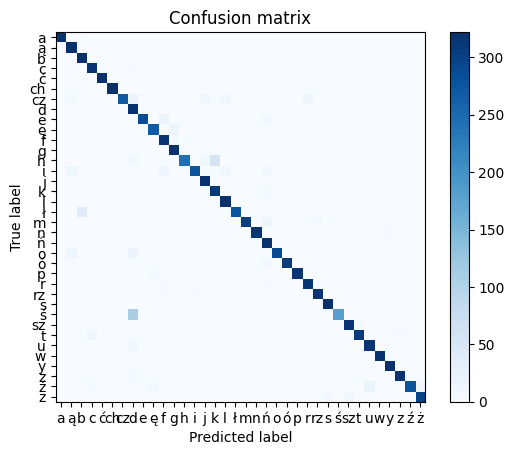

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

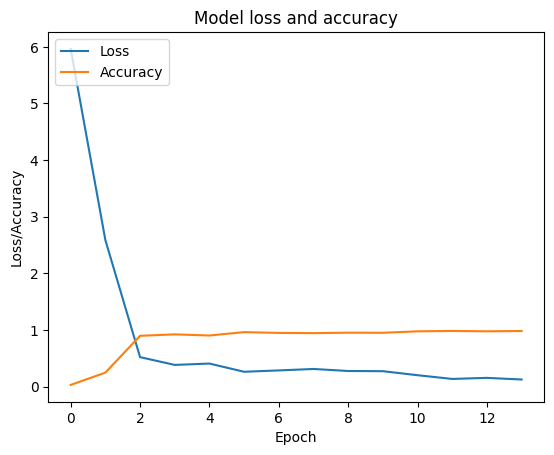

360/360 [==============================] - 16s 42ms/step


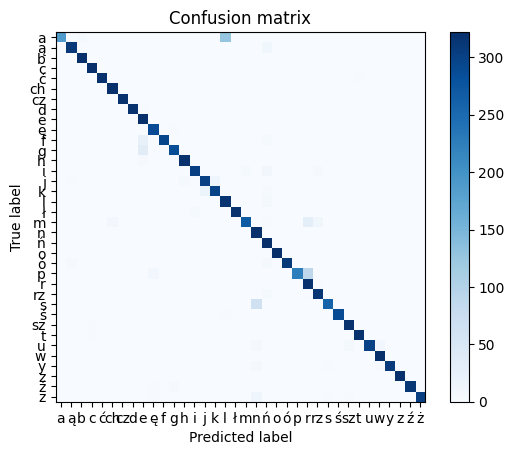

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

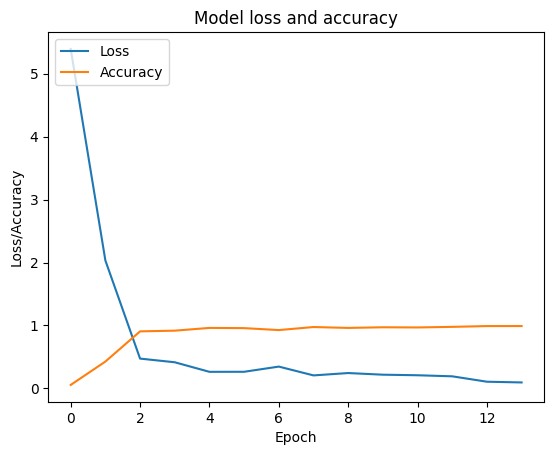

360/360 [==============================] - 16s 44ms/step


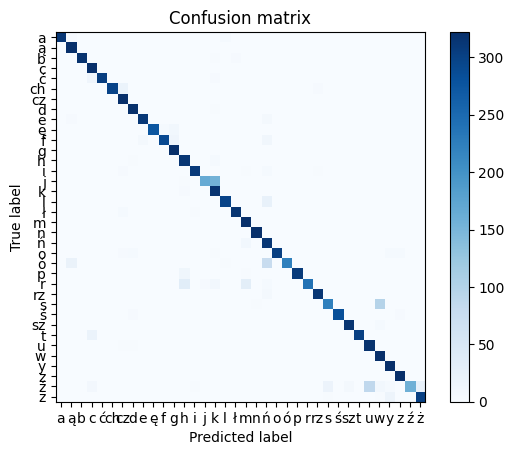

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

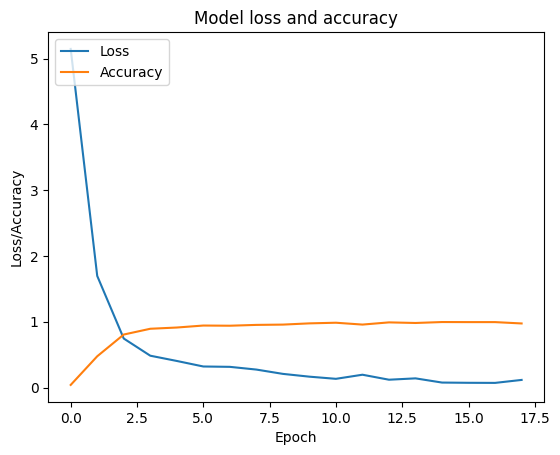

360/360 [==============================] - 15s 41ms/step


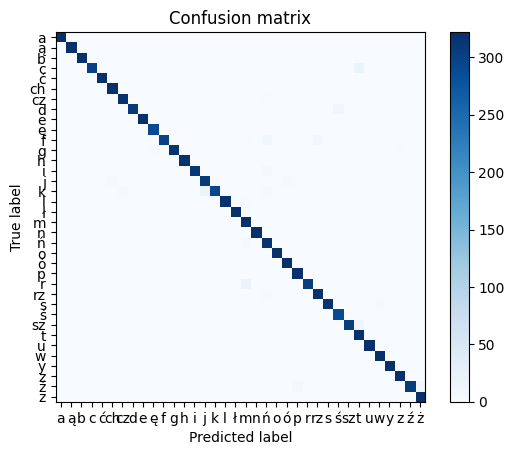

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

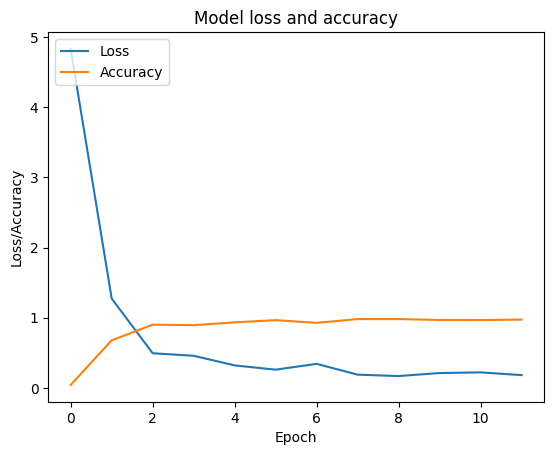

360/360 [==============================] - 17s 42ms/step


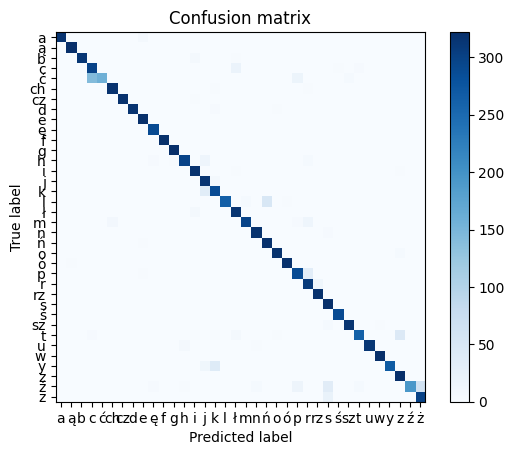

In [12]:
for selected_features in list_combinations:
    
    # droplist = [x for x in ADC_channels if x not in selected_features]
    
    # df.drop(columns =droplist)
    
    x = df[list(selected_features)+IMU_channels].values
    y = df['sign'].values
    x=x[:num_ts*SAMPLE_SIZE]
    y=y[:num_ts*SAMPLE_SIZE]
    Y_resh = np.reshape(y,(num_ts//SAMPLE_SIZE,SAMPLE_SIZE,1))
    Y = Y_resh[:,1,:]
    num_classes = len(np.unique(y))

    #Y_enc = [int.from_bytes(char.encode('utf-8'), byteorder="big") for char in Y ]

    Y_enc = pd.get_dummies(Y.flatten())



    X_resh = np.reshape(x,(num_ts//SAMPLE_SIZE, SAMPLE_SIZE, x.shape[1]))
    X_train, X_test, Y_train, Y_test = train_test_split(X_resh, Y_enc, test_size=0.2, random_state=0, stratify=Y)

    X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.2, random_state=0, stratify=Y_test)
    

    train_dataset = (X_train, Y_train)
    test_dataset = (X_test, Y_test)
    val_dataset = (X_val, Y_val)



    #train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    #test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    # MODEL CONSTANTS
    LAYERS = np.dot(1,[75, 75, 75])                # number of units in hidden and output layers
    M_TRAIN = X_train.shape[0]                     # number of training examples (2D)
    M_TEST = X_test.shape[0]                       # number of test examples (2D),full=X_test.shape[0]
    N = X_train.shape[2]                           # number of features
    BATCH = 256                           # batch size
    EPOCH = 60                                    # number of epochs
    LR = 2e-3                          # learning rate of the gradient descent
    LAMBD = 3e-2                         # lambda in L2 regularizaion
    DP = 0.5                           # dropout rate
    RDP = 0                           # recurrent dropout rate

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    checkpoint = ModelCheckpoint(filepath=log_dir+'/models/'+'model.{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5',
                                 monitor='val_categorical_accuracy',
                                 verbose=1,
                                 save_best_only=True,
                                 save_weights_only=False,
                                 mode='max')

    lr_decay = ReduceLROnPlateau(monitor='loss',
                                 patience=1, verbose=1,
                                 factor=0.5, min_lr=1e-6)

    early_stop = EarlyStopping(monitor='categorical_accuracy', min_delta=0.02,
                               patience=7, verbose=1, mode='auto',
                               baseline=0, restore_best_weights=True)

    initial_learning_rate = LR
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True)

    # MODEL DEFINITION
    model = Sequential()
    model.add(layers.Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='sigmoid', input_shape=(75, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.GRU(units=LAYERS[0],
                          activation='selu', recurrent_activation='hard_sigmoid',
                          kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
                          dropout=DP, recurrent_dropout=RDP,
                          return_sequences=True, return_state=False,
                          stateful=False, unroll=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='sigmoid', input_shape=(75, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.GRU(units=LAYERS[1],
                          activation='selu', recurrent_activation='hard_sigmoid',
                          kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
                          dropout=DP, recurrent_dropout=RDP,
                          return_sequences=True, return_state=False,
                          stateful=False, unroll=False))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='sigmoid', input_shape=(75, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.GRU(units=LAYERS[2],
                          activation='selu', recurrent_activation='hard_sigmoid',
                          kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
                          dropout=DP, recurrent_dropout=RDP,
                          return_sequences=False, return_state=False,
                          stateful=False, unroll=False))
    
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(36, activation='softmax'))

    opt = optimizers.Adam(learning_rate=LR,  clipnorm=1.)

    # MODEL COMPILATION
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['categorical_accuracy'])

    print(model.summary())
    print(selected_features)

    # CONVERTING & ENCODING LABELS


    # SPLITTING






    # TRAINING
    history = model.fit(X_train, Y_train, epochs=EPOCH, batch_size=BATCH,
                        shuffle=True,validation_data=val_dataset,
                        callbacks=[
                                    early_stop
                                    ,lr_decay
                                    ,checkpoint
                                    ,tensorboard_callback]
                        )


    #@model = load_model('logs/fit/20230111-125954model.82-0.54.hdf5')


    # EVALUATION
    train_loss, train_acc = model.evaluate(X_train, Y_train,
                                           batch_size=M_TRAIN, verbose=0)
    test_loss, test_acc = model.evaluate(X_test[:M_TEST], Y_test[:M_TEST],
                                         batch_size=M_TEST, verbose=0)


    # ACCURACY AND LOSS PLOTS

    print(max(history.history['val_categorical_accuracy']))

    plt.plot(history.history['val_loss'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model loss and accuracy')
    plt.ylabel('Loss/Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Loss', 'Accuracy'], loc='upper left')
    plt.show()


    # CONFUSION MATRIX
    oh_dict=dict(zip([i for i in range(num_classes)],list(sign_types_dict.keys())))

    y_pred = model.predict(X_test)
    y_int_pred_class = np.argmax(y_pred, axis=1)
    y_int_test_class = np.argmax(Y_test.values, axis=1)

    y_test_class = [oh_dict[i] for i in y_int_test_class]
    y_pred_class=[oh_dict[i] for i in y_int_pred_class]

    confusion_mat = confusion_matrix(y_test_class, y_pred_class, labels=list(sign_types_dict.keys()))
    plt.imshow(confusion_mat, cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks([cl for cl in range(num_classes)], sign_types_dict.keys())
    plt.yticks([cl for cl in range(num_classes)], sign_types_dict.keys())
    plt.show()

    
    acc_list.append([test_acc, selected_features])
    
    tf.keras.backend.clear_session()

    # tf.math.confusion_matrix(Y_test,y_pred)
    # #%%
    # # ROC PLOT
    # fpr = {}
    # tpr = {}
    # roc_auc = {}
    #
    # for i in range(3):
    #     fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_pred[:, i])
    #     roc_auc[i] = auc(fpr[i], tpr[i])
    #
    # plt.figure()
    # for i in range(3):
    #     plt.plot(fpr[i], tpr[i], label='ROC curve for class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    # plt.plot([0, 1], [0, 1], 'k--')
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.0])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('ROC curves for all classes')
    # plt.legend(loc="lower right")
    # plt.show()

In [13]:
pd.DataFrame(acc_list).to_csv('acc_list_combinations_pp_v2.csv')